In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import to_tree, ClusterNode, dendrogram
from typing import Dict, Tuple, List, Union, Optional
from ete3 import Tree
import os

#local
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

DATA_PATH = os.path.join(BASE_PATH, "../../../downloads/")  # where I dump new data
COMP_PATH = os.path.join(DATA_PATH,"1KGvs1KG")


#Wynton
# BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
# DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
# RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

# SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

# COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
# COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")



In [3]:
def get_window_dendrogram(w, idx, ymax = None, ymin = -.001, box_size = 0.008):
    fig, ax = plt.subplots(1, figsize=(25,3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    sch.set_link_color_palette(['darkgrey', 'grey','black'])
    Z=tree_complete[w][0]
    dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)
    #plt.xticks([])
    plt.xlim(left = -10)
    plt.ylim(bottom = ymin)
    if ymax is not None:
        plt.ylim(top = ymax)

    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)


    leaf_x = [(x * 10)+5 for x in dg['leaves']]
    leaf_y = [0] * 130

    sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832'}

    lineage_dict = {}
    for i in range(len(idx)):
        lineage_dict[i]=idx[i]
        
    colors = {}
    for k in lineage_dict.keys():
        i = k*10 + 5
        c = lineage_dict[k]
        if (c != 'hsmrca') & (c!='gagp'):
            c = c[:3]
        c = sup_pal[c]
        colors[i] = c

    new_colors = [colors[i] for i in leaf_x]

    # create new x for plotting leaves
    new_leaf_x = range(5,1305,10)
    #plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10)
    for x, y, z in zip(new_leaf_x, leaf_y, new_colors): # as rectangles
        rect = Rectangle((x-4.5, y-0.008), width = 9, height = box_size, facecolor = z, zorder = 10)
        #rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.008, facecolor = z, edgecolor = 'black', linewidth = 0.5, zorder = 10)
        ax.add_patch(rect)

    plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
    plt.ylabel('3D Divergence\n', size = 14) # label of the y-axis
    plt.title("Chromosome %s, Position %s" % (str(w[0]).strip('chr'), str(w[1])))
    plt.show()
    return Z


def one_window_tree(dict3d, w, tree_summary, tree_complete, link_method, idx):
        window_df = dict_3d[w].loc[idx][idx]
        length = len(idx)
        array = window_df.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
        condensed = array[np.triu_indices(length, k = 1)]
        Z = sch.linkage(condensed, method = link_method)
        dendrogram = sch.dendrogram(Z, labels=idx)
        whole_tree = [Z, dendrogram]

        cluster_sample_IDs = dendrogram['leaves']
        cluster_IDs = dendrogram['leaves_color_list']
        clusters_dict = dict(zip(cluster_sample_IDs, cluster_IDs))

        cluster_IDs_list = []
        for key, value in sorted(clusters_dict.items()):
                cluster_IDs_list.append(value)

        top_tree_y = dendrogram['dcoord'][-1]
        window_stats = cluster_IDs_list + top_tree_y


        return window_stats, whole_tree


def _scipy_tree_to_newick_list(node: ClusterNode, newick: List[str], parentdist: float, leaf_names: List[str]) -> List[str]:
    """Construct Newick tree from SciPy hierarchical clustering ClusterNode

    This is a recursive function to help build a Newick output string from a scipy.cluster.hierarchy.to_tree input with
    user specified leaf node names.

    Notes:
        This function is meant to be used with `to_newick`

    Args:
        node (scipy.cluster.hierarchy.ClusterNode): Root node is output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        parentdist (float): Distance of parent node of `node`
        newick (list of string): Newick string output accumulator list which needs to be reversed and concatenated (i.e. `''.join(newick)`) for final output
        leaf_names (list of string): Leaf node names

    Returns:
        (list of string): Returns `newick` list of Newick output strings
    """
    if node.is_leaf():
        return newick + [f'{leaf_names[node.id]}:{parentdist - node.dist}']

    if len(newick) > 0:
        newick.append(f'):{parentdist - node.dist}')
    else:
        newick.append(');')
    newick = _scipy_tree_to_newick_list(node.get_left(), newick, node.dist, leaf_names)
    newick.append(',')
    newick = _scipy_tree_to_newick_list(node.get_right(), newick, node.dist, leaf_names)
    newick.append('(')
    return newick


def to_newick(tree: ClusterNode, leaf_names: List[str]) -> str:
    """Newick tree output string from SciPy hierarchical clustering tree

    Convert a SciPy ClusterNode tree to a Newick format string.
    Use scipy.cluster.hierarchy.to_tree on a hierarchical clustering linkage matrix to create the root ClusterNode for the `tree` input of this function.

    Args:
        tree (scipy.cluster.hierarchy.ClusterNode): Output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        leaf_names (list of string): Leaf node names

    Returns:
        (string): Newick output string
    """
    newick_list = _scipy_tree_to_newick_list(tree, [], tree.dist, leaf_names)
    return ''.join(newick_list[::-1])

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Without Ancestral

## Set Up

In [5]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % DATA_PATH,
                       index_col=0)
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "%s/dict_seq.p" % DATA_PATH, "rb" ) )
matrix_seq = pickle.load( open( "%s/matrix_seq.p" % DATA_PATH, "rb" ) )

dict_3d = pickle.load( open( "%s/dict_3d.p" % DATA_PATH, "rb" ) )
matrix_3d = pickle.load( open( "%s/matrix_3d.p" % DATA_PATH, "rb" ) )


windows_tuples = list(dict_3d.keys())

sub_pops = list(set(comp_list.sub1).union(comp_list.sub2))
sub_pal = dict.fromkeys(sub_pops)
amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]
sub_pal['GBR'] = eur_pal[0]
sub_pal['FIN'] = eur_pal[1]
sub_pal['IBS'] = eur_pal[2]
sub_pal['CEU'] = eur_pal[3]
sub_pal['TSI'] = eur_pal[4]

sub_pal['PEL'] = amr_pal[0]
sub_pal['CLM'] = amr_pal[1]
sub_pal['MXL'] = amr_pal[2]
sub_pal['PUR'] = amr_pal[3]

sub_pal['CHB'] = eas_pal[0]
sub_pal['JPT'] = eas_pal[1]
sub_pal['CHS'] = eas_pal[2]
sub_pal['CDX'] = eas_pal[3]
sub_pal['KHV'] = eas_pal[4]

sub_pal['ITU'] = sas_pal[0]
sub_pal['PJL'] = sas_pal[1]
sub_pal['BEB'] = sas_pal[2]
sub_pal['STU'] = sas_pal[3]
sub_pal['GIH'] = sas_pal[4]

sub_pal['ASW'] = afr_pal[0]
sub_pal['ACB'] = afr_pal[1]
sub_pal['GWD'] = afr_pal[2]
sub_pal['LWK'] = afr_pal[3]
sub_pal['ESN'] = afr_pal[4]
sub_pal['YRI'] = afr_pal[5]
sub_pal['MSL'] = afr_pal[6]



In [6]:
matrix_3d

SAS_ITU_female_HG03781  EUR_IBS_female_HG01522  \
SAS_ITU_female_HG03781                     NaN                0.003100   
EUR_IBS_female_HG01522                0.003100                     NaN   
EUR_TSI_female_NA20769                0.002913                0.002915   
EAS_CDX_female_HG01799                0.002958                0.002795   
AFR_ESN_female_HG03159                0.004243                0.004179   
...                                        ...                     ...   
EUR_TSI_female_NA20533                0.002977                0.002750   
EUR_TSI_female_NA20529                0.002902                0.002774   
SAS_ITU_female_HG04209                0.002812                0.002931   
AFR_ESN_female_HG03511                0.004180                0.003906   
AFR_ASW_female_NA20317                0.003544                0.003452   

                        EUR_TSI_female_NA20769  EAS_CDX_female_HG01799  \
SAS_ITU_female_HG03781                0.002913                0.002958   
EUR_IBS_female_HG01522                0.002915                0.002795   
EUR_TSI_female_NA20769                     NaN                0.002909   
EAS_CDX_female_HG01799                0.002909                     NaN   
AFR_ESN_female_HG03159                0.004135                0.004026   
...                                        ...                     ...   
EUR_TSI_female_NA20533                0.002769                0.002824   
EUR_TSI_female_NA20529                0.002848                0.003177   
SAS_ITU_female_HG04209                0.002686                0.002656   
AFR_ESN_female_HG03511                0.003893                0.003892   
AFR_ASW_female_NA20317                0.003592                0.003616   

                        AFR_ESN_female_HG03159  AFR_ACB_female_HG02337  \
SAS_ITU_female_HG03781                0.004243                0.004067   
EUR_IBS_female_HG01522                0.004179                0.004311   
EUR_TSI_female_NA20769                0.004135                0.004075   
EAS_CDX_female_HG01799                0.004026                0.004044   
AFR_ESN_female_HG03159                     NaN                0.004066   
...                                        ...                     ...   
EUR_TSI_female_NA20533                0.004185                0.003923   
EUR_TSI_female_NA20529                0.004281                0.004094   
SAS_ITU_female_HG04209                0.004049                0.003946   
AFR_ESN_female_HG03511                0.004025                0.003983   
AFR_ASW_female_NA20317                0.003892                0.003818   

                        SAS_GIH_female_NA20894  AMR_MXL_female_NA19758  \
SAS_ITU_female_HG03781                0.002894                0.002970   
EUR_IBS_female_HG01522                0.002771                0.002940   
EUR_TSI_female_NA20769                0.002946                0.002927   
EAS_CDX_female_HG01799                0.002926                0.002566   
AFR_ESN_female_HG03159                0.004147                0.004150   
...                                        ...                     ...   
EUR_TSI_female_NA20533                0.003040                0.002927   
EUR_TSI_female_NA20529                0.003002                0.003028   
SAS_ITU_female_HG04209                0.002871                0.002554   
AFR_ESN_female_HG03511                0.003977                0.003706   
AFR_ASW_female_NA20317                0.003810                0.003507   

                        AFR_GWD_female_HG02814  SAS_PJL_female_HG02725  ...  \
SAS_ITU_female_HG03781                0.003808                0.002985  ...   
EUR_IBS_female_HG01522                0.003769                0.002611  ...   
EUR_TSI_female_NA20769                0.003788                0.002852  ...   
EAS_CDX_female_HG01799                0.003540                0.002541  ...   
AFR_ESN_female_HG03159                0.003805                0.004140  .

In [7]:
idx = sorted(set(comp_list.ind1).union(comp_list.ind2))
sub_idx = []
for i in idx:
    sub_idx.append(i[4:7])


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


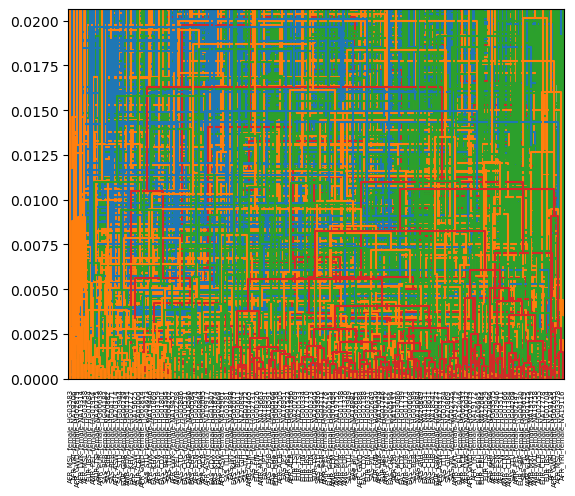

In [8]:
tree_summary = {}
tree_complete = {}
#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete', idx=idx)
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)


## Genome Avg

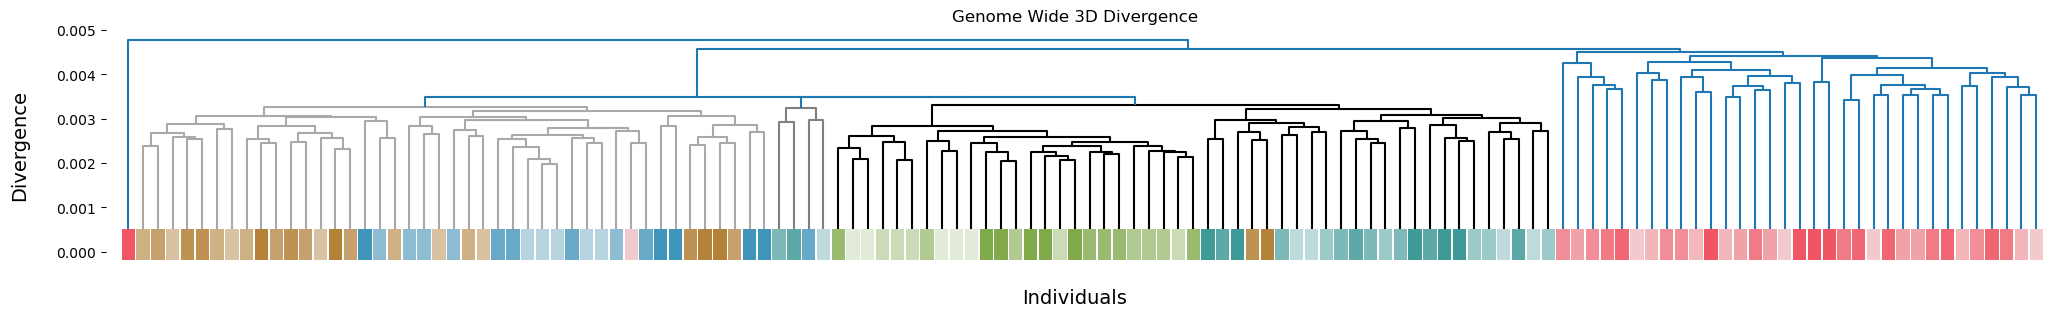

In [9]:
length = len(idx)
array = matrix_3d.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0002)
plt.tick_params(
axis='x',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 130

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832'}

lineage_dict = {}
for i in range(len(idx)):
    lineage_dict[i]=idx[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if c != 'anc':
        c = c[4:7]
    c = sub_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1305,10)
#plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
for x, y, z in zip(new_leaf_x, leaf_y, new_colors): # as rectangles
        rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.0085, facecolor = z, zorder = 10)
        #rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.008, facecolor = z, edgecolor = 'black', linewidth = 0.5, zorder = 10)
        ax.add_patch(rect)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide 3D Divergence')
plt.show()

In [10]:
avg_tree = Z

## Windows

In [11]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=list(idx) + ['coord_0','coord_1','coord_2','coord_3'])

counts_df = dataframe.drop(columns=['coord_0','coord_1', 'coord_2','coord_3']).apply(lambda s: s.value_counts(), axis=1).fillna(0)     
counts_df['depth'] = dataframe['coord_1']


### IDWs

In [12]:
idw = counts_df[(counts_df.C0==1 )|(counts_df.C1==1)|(counts_df.C2==1)|(counts_df.C3==1)|(counts_df.C4==1)|(counts_df.C5==1)]

In [13]:
idw_list = []
for r in idw.index:
    row = dataframe.loc[[r]]
    ind = row.where(row=='C0').dropna(how='all').dropna(axis=1).dropna(axis=1).columns[0]
    idw_list.append(ind)

In [14]:
len(idw_list)

1251

In [15]:
idw['individual'] = idw_list

In [16]:
idw

C0     C1     C2   C3   C4   C5     depth  \
(chr1, 3670016)    1.0   47.0   82.0  0.0  0.0  0.0  0.016704   
(chr1, 6291456)    1.0   16.0  113.0  0.0  0.0  0.0  0.003675   
(chr1, 7340032)    1.0  129.0    0.0  0.0  0.0  0.0  0.002926   
(chr1, 10485760)   1.0  129.0    0.0  0.0  0.0  0.0  0.019718   
(chr1, 11010048)   1.0  129.0    0.0  0.0  0.0  0.0  0.050779   
...                ...    ...    ...  ...  ...  ...       ...   
(chr22, 40894464)  1.0  129.0    0.0  0.0  0.0  0.0  0.009164   
(chr22, 43515904)  1.0  129.0    0.0  0.0  0.0  0.0  0.011355   
(chr22, 44564480)  1.0   62.0   67.0  0.0  0.0  0.0  0.025806   
(chr22, 45613056)  1.0  129.0    0.0  0.0  0.0  0.0  0.022792   
(chr22, 47185920)  1.0  129.0    0.0  0.0  0.0  0.0  0.328717   

                               individual  
(chr1, 3670016)    AFR_ASW_female_NA19901  
(chr1, 6291456)    AFR_ASW_female_NA19625  
(chr1, 7340032)    SAS_BEB_female_HG04183  
(chr1, 10485760)   AFR_MSL_female_HG03575  
(chr1, 11010048)   AFR_MSL_female_HG03575  
...                                   ...  
(chr22, 40894464)  SAS_STU_female_HG03673  
(chr22, 43515904)  AMR_PUR_female_HG01326  
(chr22, 44564480)  AFR_GWD_female_HG02879  
(chr22, 45613056)  AFR_ACB_female_HG02555  
(chr22, 47185920)  SAS_STU_female_HG03673  

[1251 rows x 8 columns]

In [17]:
vcf_index = pd.read_csv('%s/vcf_indexing.txt' % DATA_PATH, index_col=0)


In [18]:
vcf_index

ind1 super1 sub1    sex1   ind1.1  index        0
17  EUR_GBR_female_HG00130    EUR  GBR  female  HG00130     41  HG00130
18  EUR_GBR_female_HG00237    EUR  GBR  female  HG00237     92  HG00237
16  EUR_GBR_female_HG00238    EUR  GBR  female  HG00238     93  HG00238
15  EUR_GBR_female_HG00239    EUR  GBR  female  HG00239     94  HG00239
19  EUR_GBR_female_HG00255    EUR  GBR  female  HG00255    107  HG00255
..                     ...    ...  ...     ...      ...    ...      ...
49  SAS_GIH_female_NA20849    SAS  GIH  female  NA20849   2454  NA20849
45  SAS_GIH_female_NA20869    SAS  GIH  female  NA20869   2470  NA20869
47  SAS_GIH_female_NA20882    SAS  GIH  female  NA20882   2480  NA20882
46  SAS_GIH_female_NA20894    SAS  GIH  female  NA20894   2491  NA20894
48  SAS_GIH_female_NA20896    SAS  GIH  female  NA20896   2493  NA20896

[130 rows x 7 columns]

In [19]:
idw_params = idw['individual'].reset_index()

In [20]:
idw_params

index              individual
0       (chr1, 3670016)  AFR_ASW_female_NA19901
1       (chr1, 6291456)  AFR_ASW_female_NA19625
2       (chr1, 7340032)  SAS_BEB_female_HG04183
3      (chr1, 10485760)  AFR_MSL_female_HG03575
4      (chr1, 11010048)  AFR_MSL_female_HG03575
...                 ...                     ...
1246  (chr22, 40894464)  SAS_STU_female_HG03673
1247  (chr22, 43515904)  AMR_PUR_female_HG01326
1248  (chr22, 44564480)  AFR_GWD_female_HG02879
1249  (chr22, 45613056)  AFR_ACB_female_HG02555
1250  (chr22, 47185920)  SAS_STU_female_HG03673

[1251 rows x 2 columns]

In [21]:
idw_params['chr'], idw_params['pos'] = idw_params['index'].str

In [22]:
vcf_index = vcf_index.reset_index()

In [23]:
vcf_index[vcf_index['ind1']=='SAS_GIH_female_NA20896'].index[0]

129

In [24]:
def get_col_id(row):
    id_name = row.individual
    col_id = int(vcf_index[vcf_index['ind1']==id_name].index[0]) + 5
    print(id_name)
    print(col_id)
    return int(col_id)

In [25]:
idw_params['col_id'] = idw_params.apply(lambda x: get_col_id(x), axis=1)

AFR_ASW_female_NA19901
121
AFR_ASW_female_NA19625
115
SAS_BEB_female_HG04183
87
AFR_MSL_female_HG03575
72
AFR_MSL_female_HG03575
72
EAS_JPT_female_NA18951
100
AMR_MXL_female_NA19752
118
AFR_LWK_female_NA19446
113
AFR_LWK_female_NA19446
113
EAS_CHS_female_HG00566
16
AFR_ESN_female_HG03159
68
AFR_ESN_female_HG03159
68
AFR_YRI_female_NA19116
107
EAS_JPT_female_NA18991
102
AFR_ACB_female_HG02505
53
AFR_ACB_female_HG02505
53
EUR_CEU_female_NA07000
91
EUR_IBS_female_HG01746
35
AFR_ESN_female_HG03159
68
AFR_GWD_female_HG02679
58
AFR_ASW_female_NA20317
124
AFR_ESN_female_HG03159
68
SAS_BEB_female_HG04171
86
SAS_STU_female_HG03673
78
AFR_GWD_female_HG02888
63
EAS_JPT_female_NA18951
100
EUR_GBR_female_HG00130
5
AFR_MSL_female_HG03458
70
AFR_MSL_female_HG03458
70
AFR_MSL_female_HG03086
66
EUR_IBS_female_HG01710
34
EUR_IBS_female_HG01710
34
AFR_YRI_female_NA19129
108
AFR_YRI_female_NA19129
108
AFR_LWK_female_NA19024
104
AFR_LWK_female_NA19446
113
AFR_ASW_female_NA19901
121
AFR_ASW_female_NA19901
1

In [26]:
idw_params['end'] = idw_params['pos']+2**20
idw_params = idw_params[['col_id','chr','pos','end','individual']]

In [27]:
idw_params[idw_params.individual== 'AFR_ASW_female_NA19901']

col_id    chr        pos        end              individual
0        121   chr1    3670016    4718592  AFR_ASW_female_NA19901
36       121   chr1   93323264   94371840  AFR_ASW_female_NA19901
37       121   chr1   93847552   94896128  AFR_ASW_female_NA19901
190      121   chr2  209715200  210763776  AFR_ASW_female_NA19901
351      121   chr4  101711872  102760448  AFR_ASW_female_NA19901
352      121   chr4  102236160  103284736  AFR_ASW_female_NA19901
378      121   chr4  140509184  141557760  AFR_ASW_female_NA19901
379      121   chr4  141033472  142082048  AFR_ASW_female_NA19901
416      121   chr5   41943040   42991616  AFR_ASW_female_NA19901
493      121   chr6   23592960   24641536  AFR_ASW_female_NA19901
494      121   chr6   24117248   25165824  AFR_ASW_female_NA19901
495      121   chr6   24641536   25690112  AFR_ASW_female_NA19901
560      121   chr6  160956416  162004992  AFR_ASW_female_NA19901
820      121  chr10  119013376  120061952  AFR_ASW_female_NA19901
821      121  chr10  119537664  120586240  AFR_ASW_female_NA19901
942      121  chr12  124780544  125829120  AFR_ASW_female_NA19901
1053     121  chr15   73400320   74448896  AFR_ASW_female_NA19901
1054     121  chr15   73924608   74973184  AFR_ASW_female_NA19901
1055     121  chr15   74448896   75497472  AFR_ASW_female_NA19901
1082     121  chr16   29360128   30408704  AFR_ASW_female_NA19901
1102     121  chr16   85458944   86507520  AFR_ASW_female_NA19901
1120     121  chr17   40894464   41943040  AFR_ASW_female_NA19901
1125     121  chr17   54001664   55050240  AFR_ASW_female_NA19901

In [28]:
idw_params.to_csv('idw_mut_params.txt', header=False, index=False, sep='\t')

In [29]:
idw_params[idw_params.individual == 'AFR_YRI_female_NA19116'][idw_params.chr=='chr20']

col_id    chr       pos       end              individual
1211     107  chr20  41943040  42991616  AFR_YRI_female_NA19116
1212     107  chr20  42467328  43515904  AFR_YRI_female_NA19116
1218     107  chr20  56098816  57147392  AFR_YRI_female_NA19116

In [30]:
idw.individual.value_counts().head(n=50)

AFR_LWK_female_NA19446    24
AFR_ASW_female_NA19901    23
AFR_MSL_female_HG03086    23
AFR_ASW_female_NA19917    22
AFR_LWK_female_NA19314    22
AFR_ACB_female_HG01896    21
AFR_GWD_female_HG02679    21
AFR_MSL_female_HG03378    21
AFR_LWK_female_NA19457    20
AFR_GWD_female_HG02635    20
AFR_MSL_female_HG03458    19
AFR_ESN_female_HG02974    19
AFR_GWD_female_HG02888    19
AFR_LWK_female_NA19037    19
SAS_ITU_female_HG03772    18
AFR_ACB_female_HG02555    18
AFR_YRI_female_NA19172    17
AFR_ESN_female_HG03111    17
AFR_MSL_female_HG03583    17
AFR_MSL_female_HG03575    17
AFR_YRI_female_NA19116    16
SAS_STU_female_HG03673    16
AFR_LWK_female_NA19024    16
AFR_GWD_female_HG02879    15
EAS_KHV_female_HG01874    15
AFR_ESN_female_HG03159    15
AFR_ACB_female_HG02337    14
AFR_GWD_female_HG02814    14
EAS_KHV_female_HG02069    14
SAS_PJL_female_HG02655    14
SAS_BEB_female_HG03611    13
AMR_PUR_female_HG01191    13
AMR_PUR_female_HG01326    13
AFR_ACB_female_HG02505    13
EAS_CDX_female

Text(0, 0.5, 'window count')

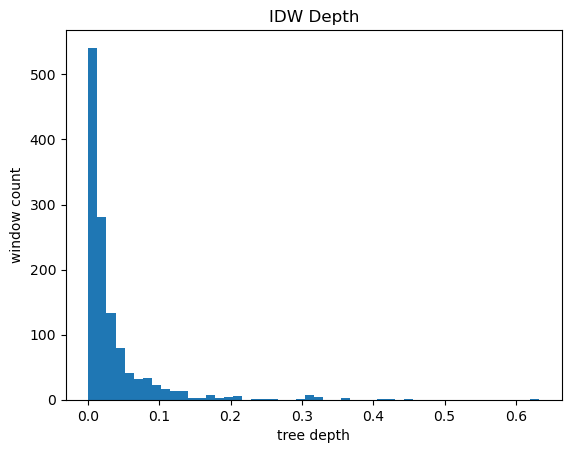

In [31]:
plt.hist(idw.depth, bins=50)
plt.title("IDW Depth")
plt.xlabel("tree depth")
plt.ylabel("window count")

In [32]:
def get_super_pop(idw_row):
    return idw_row.individual.split('_')[0]
    

In [33]:
idw_counts = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS'])
for key in idw_counts.keys():
    idw_counts[key] = 0

for i in range(idw.shape[0]):
    super_pop = get_super_pop(idw.iloc[i])
    idw_counts[super_pop] += 1

In [34]:
idw_params[idw_params.chr == 'chr20'][idw_params.pos==41943040]

col_id    chr       pos       end              individual
1211     107  chr20  41943040  42991616  AFR_YRI_female_NA19116

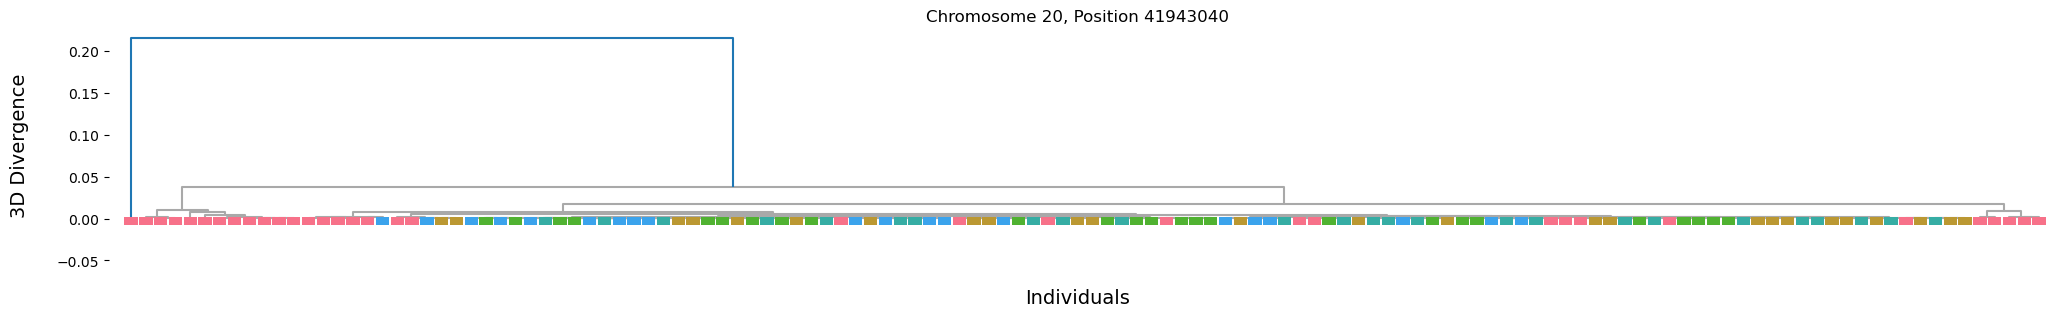

array([[3.60000000e+01, 4.70000000e+01, 1.11490745e-04, 2.00000000e+00],
       [5.70000000e+01, 6.00000000e+01, 1.19458770e-04, 2.00000000e+00],
       [9.80000000e+01, 9.90000000e+01, 1.27664777e-04, 2.00000000e+00],
       [5.60000000e+01, 9.40000000e+01, 1.57853336e-04, 2.00000000e+00],
       [4.90000000e+01, 1.09000000e+02, 1.76829031e-04, 2.00000000e+00],
       [1.16000000e+02, 1.22000000e+02, 1.82370475e-04, 2.00000000e+00],
       [6.40000000e+01, 7.90000000e+01, 2.03566619e-04, 2.00000000e+00],
       [6.30000000e+01, 7.50000000e+01, 2.03675974e-04, 2.00000000e+00],
       [4.60000000e+01, 1.17000000e+02, 2.08984595e-04, 2.00000000e+00],
       [1.27000000e+02, 1.30000000e+02, 2.09487630e-04, 3.00000000e+00],
       [9.20000000e+01, 1.04000000e+02, 2.13457135e-04, 2.00000000e+00],
       [7.20000000e+01, 1.13000000e+02, 2.14093821e-04, 2.00000000e+00],
       [3.70000000e+01, 1.08000000e+02, 2.36895935e-04, 2.00000000e+00],
       [5.20000000e+01, 1.24000000e+02, 2.38464897e

In [35]:
get_window_dendrogram(('chr20', 41943040), idx, ymin = -.05, box_size = 0.01)

In [36]:
sum(idw_counts.values())

1251

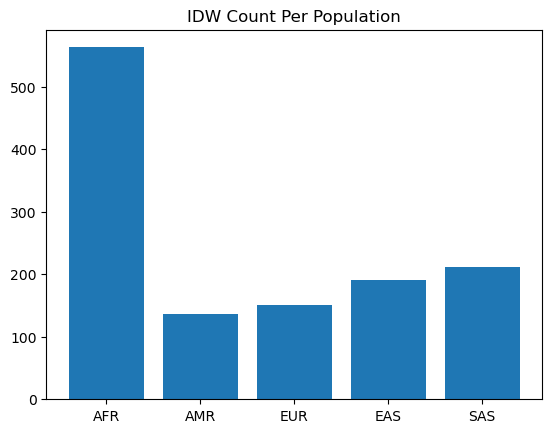

In [37]:
plt.bar(*zip(*idw_counts.items()))
plt.title('IDW Count Per Population')
plt.show()

In [39]:
idw.sort_values(by='depth')

C0     C1     C2   C3   C4   C5     depth  \
(chr2, 160432128)  1.0   17.0  112.0  0.0  0.0  0.0  0.000665   
(chr12, 87556096)  1.0  129.0    0.0  0.0  0.0  0.0  0.000691   
(chr11, 16252928)  1.0   60.0   69.0  0.0  0.0  0.0  0.000938   
(chr5, 88080384)   1.0  129.0    0.0  0.0  0.0  0.0  0.000965   
(chr7, 35651584)   1.0  129.0    0.0  0.0  0.0  0.0  0.000970   
...                ...    ...    ...  ...  ...  ...       ...   
(chr21, 16252928)  1.0  129.0    0.0  0.0  0.0  0.0  0.360948   
(chr6, 60293120)   1.0  129.0    0.0  0.0  0.0  0.0  0.413927   
(chr8, 114294784)  1.0  129.0    0.0  0.0  0.0  0.0  0.429153   
(chr14, 46137344)  1.0  129.0    0.0  0.0  0.0  0.0  0.444698   
(chr3, 174587904)  1.0  129.0    0.0  0.0  0.0  0.0  0.632987   

                               individual  
(chr2, 160432128)  EUR_CEU_female_NA06985  
(chr12, 87556096)  AFR_YRI_female_NA19172  
(chr11, 16252928)  AFR_ESN_female_HG02974  
(chr5, 88080384)   SAS_ITU_female_HG03772  
(chr7, 35651584)   AFR_MSL_female_HG03583  
...                                   ...  
(chr21, 16252928)  EUR_IBS_female_HG01522  
(chr6, 60293120)   EAS_CHS_female_HG00596  
(chr8, 114294784)  EAS_KHV_female_HG02127  
(chr14, 46137344)  AFR_ESN_female_HG02946  
(chr3, 174587904)  SAS_BEB_female_HG04183  

[1251 rows x 8 columns]

### FDWs

In [ ]:
fdw = counts_df[((counts_df.C0<=5 )& (counts_df.C0>=2 ))|
                ((counts_df.C0 == 0.0) & ((counts_df.C1<=5 )& (counts_df.C1>=2 )))
                # |
                # ((counts_df.C2<=5 )& (counts_df.C2>=2 ))|
                # ((counts_df.C3<=5 )& (counts_df.C3>=2 ))|
                # ((counts_df.C4<=5 )& (counts_df.C4>=2 ))|
                # ((counts_df.C5<=5 )& (counts_df.C5>=2 ))
                ]


In [ ]:
def get_smallest_cluster(r, fdw):
    df = fdw.drop(columns=['depth'])
    fdw_row = df.loc[[r]]
    # idx = fdw_row.where(fdw_row != 0.0).dropna(axis=1).idxmin(axis=1).values[0]
    # size = fdw_row.where(fdw_row != 0.0).dropna(axis=1).min(axis=1).values[0]
    
    if fdw_row.C0.values[0] != 0.0:
        idx = 'C0'
    else:
        idx = 'C1'
    size = fdw_row[idx]
    return idx, size

def get_cluster_inds(cluster_id, window):
    inds = dataframe.loc[[window]].where(dataframe.loc[[window]]==cluster_id).dropna(axis=1).columns
    return list(inds)


def get_cluster_purity(df):
    pure_super_list=[]
    supers = []
    pure_sub_list=[]
    subs = []
    cluster_sizes = []
    num_clusters = []
    cs = counts_df[['C0','C1','C2','C3','C4','C5']]
    for row in df.index:
        w = row
        c_n = cs.loc[[w]].where(cs.loc[[w]]!=0.0).dropna(axis=1).shape[1]
        c = get_smallest_cluster(w, df)
        c_id = c[0]
        c_size = int(c[1])
        inds = get_cluster_inds(c_id,w)
        super_pop = inds[0][:3]
        sub_pop = inds[0][4:7]
        pure_super = all(item.startswith(super_pop) for item in inds)
        pure_sub = all(item[4:7]==sub_pop for item in inds)
        pure_super_list.append(pure_super)
        pure_sub_list.append(pure_sub)

        cluster_sizes.append(c_size)
        num_clusters.append(c_n)
        if pure_super:
            supers.append(super_pop)
        else:
            supers.append(np.nan)
        if pure_sub:
            subs.append(sub_pop)
        else:
            subs.append(np.nan)
    df['pure_super'] = pure_super_list
    df['pure_sub'] = pure_sub_list

    df['super'] = supers
    df['sub'] = subs

    df['cluster_size'] = cluster_sizes
    df['num_clusters'] = num_clusters
    return df

    

In [ ]:
fdw = get_cluster_purity(fdw)

In [ ]:
fdw[fdw.pure_sub==True].super.value_counts().plot.bar()
plt.title('Pure Subpop "Few" Driven Windows by Super Pop')

In [ ]:
fdw[fdw.pure_sub==True].super.value_counts()

In [ ]:
fdw

In [ ]:
fdw[fdw.pure_sub==True].super.value_counts().sum()

### Homogeneous windows

In [ ]:
test = get_cluster_purity(counts_df)

In [ ]:
test

In [ ]:
test.cluster_size.plot.hist(bins=50)
plt.title('Size of first cluster')

In [ ]:
super_pure = test[test.pure_super]
sub_pure = test[test.pure_sub]

In [ ]:
plt.hist(super_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (super)")

In [ ]:
plt.hist(sub_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (sub)")

In [ ]:
super_pure.loc[[super_pure.cluster_size.idxmax()]]

In [ ]:
dendrogram = get_window_dendrogram(super_pure.cluster_size.idxmax(), idx)

In [ ]:
dendrogram = get_window_dendrogram(sub_pure.cluster_size.idxmax(), idx)

In [31]:
match = []
for x in range(1,131):
    match.append(x)
len(match)

130

# Clustering with Ancestral

## Set Up

In [26]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % DATA_PATH,
                       index_col=0)
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "%s/dict_seq.p" % DATA_PATH, "rb" ) )
matrix_seq = pickle.load( open( "%s/matrix_seq.p" % DATA_PATH, "rb" ) )

dict_3d = pickle.load( open( "%s/dict_3d.p" % DATA_PATH, "rb" ) )
matrix_3d = pickle.load( open( "%s/matrix_3d.p" % DATA_PATH, "rb" ) )


windows_tuples = list(dict_3d.keys())

sub_pops = list(set(comp_list.sub1).union(comp_list.sub2))
sub_pal = dict.fromkeys(sub_pops)
amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]
sub_pal['GBR'] = eur_pal[0]
sub_pal['FIN'] = eur_pal[1]
sub_pal['IBS'] = eur_pal[2]
sub_pal['CEU'] = eur_pal[3]
sub_pal['TSI'] = eur_pal[4]

sub_pal['PEL'] = amr_pal[0]
sub_pal['CLM'] = amr_pal[1]
sub_pal['MXL'] = amr_pal[2]
sub_pal['PUR'] = amr_pal[3]

sub_pal['CHB'] = eas_pal[0]
sub_pal['JPT'] = eas_pal[1]
sub_pal['CHS'] = eas_pal[2]
sub_pal['CDX'] = eas_pal[3]
sub_pal['KHV'] = eas_pal[4]

sub_pal['ITU'] = sas_pal[0]
sub_pal['PJL'] = sas_pal[1]
sub_pal['BEB'] = sas_pal[2]
sub_pal['STU'] = sas_pal[3]
sub_pal['GIH'] = sas_pal[4]

sub_pal['ASW'] = afr_pal[0]
sub_pal['ACB'] = afr_pal[1]
sub_pal['GWD'] = afr_pal[2]
sub_pal['LWK'] = afr_pal[3]
sub_pal['ESN'] = afr_pal[4]
sub_pal['YRI'] = afr_pal[5]
sub_pal['MSL'] = afr_pal[6]

sub_pal['hsmrca'] = 'grey'
sub_pal['gagp'] = 'black'

In [27]:
idx_wa = sorted(set(comp_list.ind1).union(comp_list.ind2))
idx = idx_wa + ['anc']

anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
anc_div.columns = ['_'.join(col) for col in anc_div.columns.values]
anc_div = anc_div[idx_wa]

for w in dict_3d.keys():
    b = anc_div.loc[[w]]
    b = b.reset_index(drop=True).rename(index={0:'anc'})
    a = dict_3d[w].copy()
    a = a[idx_wa].loc[idx_wa].append(b)
    a['anc'] = b.T['anc']

    dict_3d[w] = a

In [28]:
sub_idx = []
for i in idx:
    sub_idx.append(i[4:7])
sub_idx = sub_idx[:-1]
sub_idx.append('anc')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


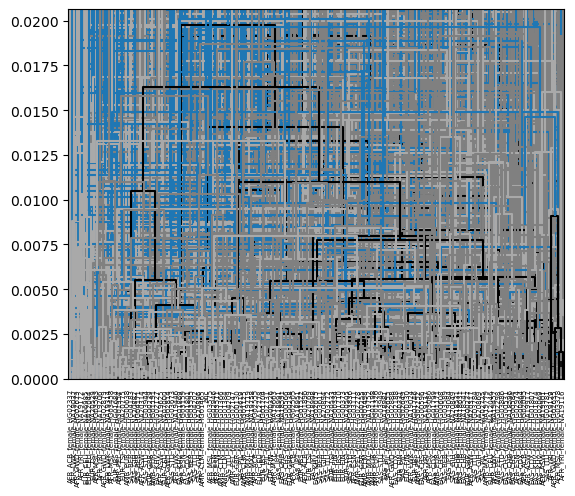

In [29]:
tree_summary = {}
tree_complete = {}
#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete', idx=idx)
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)


## Genome Avg

In [30]:
b = pd.DataFrame(anc_div.mean(), columns=['anc'])
a = matrix_3d.copy()
a = a[idx_wa].loc[idx_wa].append(b['anc'])
a['anc'] = b['anc']

KeyError: 'anc'

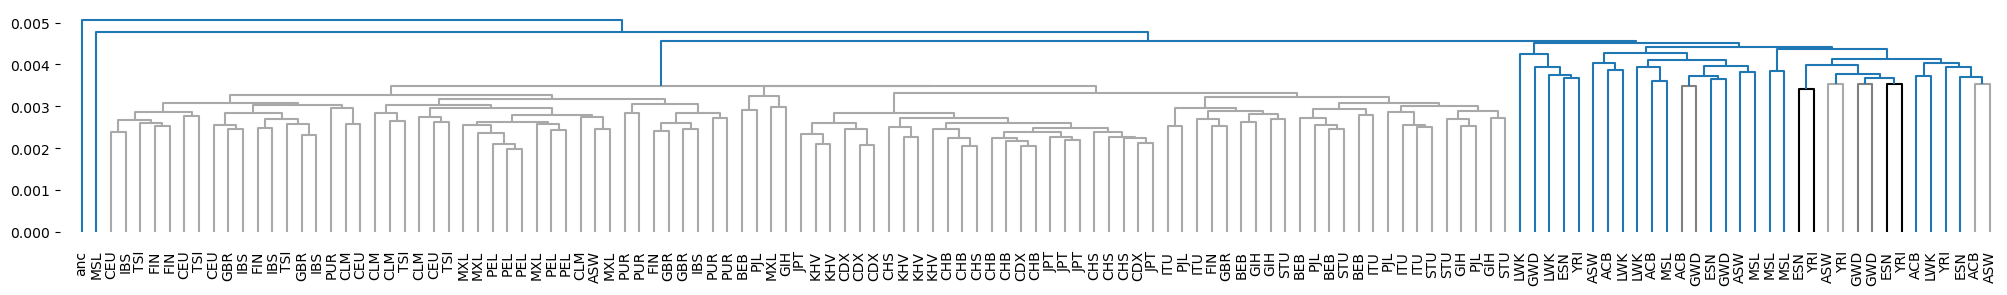

In [31]:
length = len(idx)
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0002)
# plt.tick_params(
# axis='x',          # changes apply to the x-axis
# which='both',      # both major and minor ticks are affected
# bottom=False,      # ticks along the bottom edge are off
# top=False,         # ticks along the top edge are off
# labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 131

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'anc':'grey'}

lineage_dict = {}
for i in range(len(idx)):
    lineage_dict[i]=idx[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if c != 'anc':
        c = c[4:7]
    c = sub_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1315,10)
#plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
for x, y, z in zip(new_leaf_x, leaf_y, new_colors): # as rectangles
        rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.0085, facecolor = z, zorder = 10)
        #rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.008, facecolor = z, edgecolor = 'black', linewidth = 0.5, zorder = 10)
        ax.add_patch(rect)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide 3D Divergence')
plt.show()

In [ ]:
avg_tree = Z

## Windows

In [ ]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=list(idx) + ['coord_0','coord_1','coord_2','coord_3'])

counts_df = dataframe.drop(columns=['coord_0','coord_1', 'coord_2','coord_3']).apply(lambda s: s.value_counts(), axis=1).fillna(0)     
counts_df['depth'] = dataframe['coord_1']


### IDWs

In [ ]:
idw = counts_df[(counts_df.C0==1 )|(counts_df.C1==1)|(counts_df.C2==1)|(counts_df.C3==1)|(counts_df.C4==1)|(counts_df.C5==1)]

In [ ]:
idw_list = []
for r in idw.index:
    row = dataframe.loc[[r]]
    ind = row.where(row=='C0').dropna(how='all').dropna(axis=1).dropna(axis=1).columns[0]
    idw_list.append(ind)

In [ ]:
len(idw_list)

In [ ]:
idw['individual'] = idw_list

In [ ]:
idw.individual.value_counts().head(n=50)

In [ ]:
plt.hist(idw.depth, bins=50)
plt.title("IDW Depth")
plt.xlabel("tree depth")
plt.ylabel("window count")

In [ ]:
def get_super_pop(idw_row):
    return idw_row.individual.split('_')[0]
    

In [ ]:
idw_counts = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS','anc'])
for key in idw_counts.keys():
    idw_counts[key] = 0

for i in range(idw.shape[0]):
    super_pop = get_super_pop(idw.iloc[i])
    idw_counts[super_pop] += 1

In [ ]:
idw[idw.individual=='anc']

In [ ]:
get_window_dendrogram(('chr20', 59768832), idx)

In [ ]:
get_window_dendrogram(('chr20', 41943040), idx)

In [ ]:
sum(idw_counts.values())

In [ ]:
plt.bar(*zip(*idw_counts.items()))
plt.title('IDW Count Per Population')
plt.show()

### FDWs

In [ ]:
fdw = counts_df[((counts_df.C0<=5 )& (counts_df.C0>=2 ))|
                ((counts_df.C0 == 0.0) & ((counts_df.C1<=5 )& (counts_df.C1>=2 )))
                # |
                # ((counts_df.C2<=5 )& (counts_df.C2>=2 ))|
                # ((counts_df.C3<=5 )& (counts_df.C3>=2 ))|
                # ((counts_df.C4<=5 )& (counts_df.C4>=2 ))|
                # ((counts_df.C5<=5 )& (counts_df.C5>=2 ))
                ]


In [ ]:
def get_smallest_cluster(r, fdw):
    df = fdw.drop(columns=['depth'])
    fdw_row = df.loc[[r]]
    # idx = fdw_row.where(fdw_row != 0.0).dropna(axis=1).idxmin(axis=1).values[0]
    # size = fdw_row.where(fdw_row != 0.0).dropna(axis=1).min(axis=1).values[0]
    
    if fdw_row.C0.values[0] != 0.0:
        idx = 'C0'
    else:
        idx = 'C1'
    size = fdw_row[idx]
    return idx, size

def get_cluster_inds(cluster_id, window):
    inds = dataframe.loc[[window]].where(dataframe.loc[[window]]==cluster_id).dropna(axis=1).columns
    return list(inds)


def get_cluster_purity(df):
    pure_super_list=[]
    supers = []
    pure_sub_list=[]
    subs = []
    cluster_sizes = []
    num_clusters = []
    cs = counts_df[['C0','C1','C2','C3','C4','C5']]
    for row in df.index:
        w = row
        c_n = cs.loc[[w]].where(cs.loc[[w]]!=0.0).dropna(axis=1).shape[1]
        c = get_smallest_cluster(w, df)
        c_id = c[0]
        c_size = int(c[1])
        inds = get_cluster_inds(c_id,w)
        super_pop = inds[0][:3]
        sub_pop = inds[0][4:7]
        pure_super = all(item.startswith(super_pop) for item in inds)
        pure_sub = all(item[4:7]==sub_pop for item in inds)
        pure_super_list.append(pure_super)
        pure_sub_list.append(pure_sub)

        cluster_sizes.append(c_size)
        num_clusters.append(c_n)
        if pure_super:
            supers.append(super_pop)
        else:
            supers.append(np.nan)
        if pure_sub:
            subs.append(sub_pop)
        else:
            subs.append(np.nan)
    df['pure_super'] = pure_super_list
    df['pure_sub'] = pure_sub_list

    df['super'] = supers
    df['sub'] = subs

    df['cluster_size'] = cluster_sizes
    df['num_clusters'] = num_clusters
    return df

    

In [ ]:
fdw = get_cluster_purity(fdw)

In [ ]:
fdw[fdw.pure_sub==True].super.value_counts().plot.bar()
plt.title('Pure Subpop "Few" Driven Windows by Super Pop')

In [ ]:
fdw[fdw.pure_sub==True].super.value_counts()

In [ ]:
fdw

In [ ]:
fdw[fdw.pure_sub==True].super.value_counts().sum()

### Homogeneous windows

In [ ]:
test = get_cluster_purity(counts_df)

In [ ]:
test

In [ ]:
test.cluster_size.plot.hist(bins=50)
plt.title('Size of first cluster')

In [ ]:
super_pure = test[test.pure_super]
sub_pure = test[test.pure_sub]

In [ ]:
plt.hist(super_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (super)")

In [ ]:
plt.hist(sub_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (sub)")

In [ ]:
super_pure.loc[[super_pure.cluster_size.idxmax()]]

In [ ]:
dendrogram = get_window_dendrogram(super_pure.cluster_size.idxmax(), idx)

In [ ]:
dendrogram = get_window_dendrogram(sub_pure.cluster_size.idxmax(), idx)

## ETE

### Convert to Newick

In [ ]:
trees = {}
for w in windows_tuples:
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    trees[w] = T
trees['avg'] = Tree(to_newick(hc.to_tree(Z), idx))

### Monophyletic?

In [ ]:
pops = {key: [] for key in ['AFR','EUR','AMR','SAS','EAS','anc']}
for i in idx:
    pop = i[:3]
    pops[pop].append(i)


In [ ]:
mono = pd.DataFrame(index = windows_tuples, columns = pops.keys())

In [ ]:
pops['EAS']

In [ ]:
count = 1
for w in tree_complete.keys():
    print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in pops.keys():
        status = T.check_monophyly(values=pops[p], target_attr="name")[0]
        mono.at[w,p] = status
    count += 1


In [ ]:
mono[mono.eq(True).any(1)]

In [ ]:
for w in mono[mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [ ]:
mono[mono.anc==True]

In [ ]:
test.loc[mono[mono.eq(True).any(1)].index]

In [ ]:
sub_pops = {key: [] for key in sub_idx}
for i in idx:
    if i != 'anc':
        pop = i[4:7]
    else:
        pop = i
    sub_pops[pop].append(i)

In [ ]:
sub_pops

In [ ]:
sub_mono = pd.DataFrame(index = windows_tuples, columns = sub_pops.keys())
count = 0
for w in tree_complete.keys():
    if count%100 == 0:
        print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in sub_pops.keys():
        status = T.check_monophyly(values=sub_pops[p], target_attr="name")[0]
        sub_mono.at[w,p] = status
    count += 1

In [ ]:
sub_mono[sub_mono.eq(True).any(1)]

In [ ]:
for w in sub_mono[sub_mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [ ]:
test.loc[sub_mono[sub_mono.eq(True).any(1)].index]

##### Toy example

In [ ]:

t =  Tree("((((((a, e), i), o),h), u), ((f, g), j));")
print(t)

In [ ]:
t.check_monophyly(values=["a", "e", "i", "o", "u"], target_attr="name")

In [ ]:
t.check_monophyly(values=["a", "e", "i", "o"], target_attr="name")

In [ ]:
t.check_monophyly(values=["i", "o"], target_attr="name")

### Compare trees

In [ ]:
w = ('chr1', 1048576)

In [ ]:
trees['avg'].compare(trees[w])

In [ ]:
tree_comp_stats = pd.DataFrame(index = windows_tuples, columns=['norm_rf','ref_edges_in_source','source_edges_in_ref'])
for w in trees.keys():
    comp = trees['avg'].compare(trees[w]).keys()
    norm = comp['norm_rf']
    rs = comp['ref_edges_in_source']
    sr = comp['source_edges_in_ref']
    

In [ ]:
tree_comp_stats = pd.DataFrame(index = windows_tuples, columns=['norm_rf','ref_edges_in_source','source_edges_in_ref'])
comp = trees['avg'].compare(trees[w])
norm = comp['norm_rf']
rs = comp['ref_edges_in_source']
sr = comp['source_edges_in_ref']

In [ ]:
w

In [ ]:
tree_comp_stats.loc[[w]] = pd.Series([norm, rs, sr])

In [ ]:
tree_comp_stats.loc[[w]]

In [ ]:
pd.Series([norm, rs, sr])

In [4]:
comp_list_div = pd.read_csv('/Users/egilbertson/Box Sync/UCSF/CapraLab/3DGenome/dowloads/comp_tables/pairwise_subsample_divergence_per_region.csv',
                       index_col=0, header=[0,1])

In [14]:
comp_list_div

comparison                              chr1            \
                        ind1                    ind2   1048576   1572864   
0     AFR_ASW_female_NA19917  AFR_ASW_female_NA19901  0.002916  0.002642   
1     AFR_ASW_female_NA19917  AFR_ASW_female_NA20314  0.003368  0.003113   
2     AFR_ASW_female_NA19917  AFR_ASW_female_NA20317  0.005616  0.005741   
3     AFR_ASW_female_NA19917  AFR_ASW_female_NA19625  0.001083  0.000987   
4     AFR_ASW_female_NA19917  AFR_ACB_female_HG02337  0.004772  0.003917   
...                      ...                     ...       ...       ...   
8380  EUR_CEU_female_NA12044  EUR_CEU_female_NA06985  0.000444  0.000827   
8381  EUR_CEU_female_NA12044  EUR_CEU_female_NA12046  0.001705  0.002864   
8382  EUR_CEU_female_NA07000  EUR_CEU_female_NA06985  0.000357  0.001259   
8383  EUR_CEU_female_NA07000  EUR_CEU_female_NA12046  0.001549  0.001963   
8384  EUR_CEU_female_NA06985  EUR_CEU_female_NA12046  0.001212  0.002358   

                                                                  ...  \
       3145728   3670016   4194304   4718592   5242880   5767168  ...   
0     0.004029  0.007402  0.010136  0.009374  0.000996  0.001766  ...   
1     0.001651  0.002624  0.003899  0.001373  0.001263  0.000837  ...   
2     0.005796  0.005081  0.010498  0.006152  0.001684  0.001222  ...   
3     0.006169  0.007602  0.015629  0.006208  0.000884  0.002776  ...   
4     0.004503  0.001559  0.003921  0.004111  0.002610  0.001258  ...   
...        ...       ...       ...       ...       ...       ...  ...   
8380  0.002490  0.003190  0.001763  0.003326  0.000523  0.000520  ...   
8381  0.011693  0.004009  0.001121  0.003053  0.000749  0.000547  ...   
8382  0.003997  0.002877  0.003096  0.002503  0.000722  0.000491  ...   
8383  0.006190  0.000782  0.003412  0.002886  0.000459  0.000288  ...   
8384  0.011098  0.001587  0.001233  0.003011  0.001017  0.000562  ...   

         chr22                                                              \
      44040192  44564480  45088768  45613056  46137344  46661632  47185920   
0     0.000213  0.001059  0.000585  0.001615  0.002721  0.004927  0.006682   
1     0.000267  0.002378  0.001247  0.001511  0.001297  0.003779  0.006823   
2     0.000233  0.006657  0.000521  0.001512  0.005782  0.013636  0.006390   
3     0.000112  0.007094  0.000556  0.001335  0.001772  0.002821  0.008394   
4     0.000148  0.009049  0.001011  0.001090  0.001719  0.004808  0.010305   
...        ...       ...       ...       ...       ...       ...       ...   
8380  0.000107  0.008162  0.000953  0.000293  0.000960  0.003482  0.002110   
8381  0.000091  0.007685  0.001046  0.000204  0.002035  0.004998  0.001505   
8382  0.000085  0.000766  0.000659  0.000431  0.001160  0.002826  0.001525   
8383  0.000074  0.001594  0.001506  0.000342  0.001014  0.004192  0.004069   
8384  0.000065  0.000791  0.001294  0.000173  0.000715  0.001015  0.003620   

                                    
      47710208  48234496  48758784  
0     0.009843  0.020992  0.005003  
1     0.002870  0.005452  0.007676  
2     0.009242  0.014130  0.009758  
3     0.009905  0.010043  0.009556  
4     0.032339  0.049506  0.008769  
...        ...       ...       ...  
8380  0.033791  0.140259  0.000996  
8381  0.024544  0.042609  0.002429  
8382  0.020518  0.115685  0.003922  
8383  0.047974  0.061173  0.002962  
8384  0.092030  0.263461  0.002272  

[8385 rows x 4875 columns]

In [28]:
allVall_melted = pd.concat([comp_list_div.melt(col_level=1, id_vars=['ind1','ind2'], ignore_index=True)[['ind1','ind2']], comp_list_div.drop(columns=['comparison']).melt(var_name=['chrm','start_pos'], value_name='3d_divergence')], axis=1)

In [31]:
allVall_melted

ind1                    ind2   chrm start_pos  \
0         AFR_ASW_female_NA19917  AFR_ASW_female_NA19901   chr1   1048576   
1         AFR_ASW_female_NA19917  AFR_ASW_female_NA20314   chr1   1048576   
2         AFR_ASW_female_NA19917  AFR_ASW_female_NA20317   chr1   1048576   
3         AFR_ASW_female_NA19917  AFR_ASW_female_NA19625   chr1   1048576   
4         AFR_ASW_female_NA19917  AFR_ACB_female_HG02337   chr1   1048576   
...                          ...                     ...    ...       ...   
40860100  EUR_CEU_female_NA12044  EUR_CEU_female_NA06985  chr22  48758784   
40860101  EUR_CEU_female_NA12044  EUR_CEU_female_NA12046  chr22  48758784   
40860102  EUR_CEU_female_NA07000  EUR_CEU_female_NA06985  chr22  48758784   
40860103  EUR_CEU_female_NA07000  EUR_CEU_female_NA12046  chr22  48758784   
40860104  EUR_CEU_female_NA06985  EUR_CEU_female_NA12046  chr22  48758784   

          3d_divergence  
0              0.002916  
1              0.003368  
2              0.005616  
3              0.001083  
4              0.004772  
...                 ...  
40860100       0.000996  
40860101       0.002429  
40860102       0.003922  
40860103       0.002962  
40860104       0.002272  

[40860105 rows x 5 columns]

In [33]:
allVall_melted.to_csv('melted_130v130_1KG_subsample.csv', index=False)

In [23]:
comp_list_div.drop(columns=['comparison']).melt(var_name=['chrm','start_pos'])

chrm start_pos     value
0          chr1   1048576  0.002916
1          chr1   1048576  0.003368
2          chr1   1048576  0.005616
3          chr1   1048576  0.001083
4          chr1   1048576  0.004772
...         ...       ...       ...
40860100  chr22  48758784  0.000996
40860101  chr22  48758784  0.002429
40860102  chr22  48758784  0.003922
40860103  chr22  48758784  0.002962
40860104  chr22  48758784  0.002272

[40860105 rows x 3 columns]

In [ ]:
vals = comp_list_div.drop(columns=['comparison'])

In [ ]:
plt.hist(vals.values)
plt.xlabel()
plt.ylabel()
plt.title('Modern Human 3D Divergence')

In [ ]:
np.array(vals)

In [ ]:
plt.hist(vals.to_numpy().flatten(), bins=500)
plt.xlim(0,.05)

In [ ]:
a = plt.hist(vals.to_numpy().flatten(), bins=500)

In [ ]:
a[1]


# GAGP Ancestral

### Setup

In [16]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % DATA_PATH,
                       index_col=0)
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "%s/dict_seq.p" % DATA_PATH, "rb" ) )
matrix_seq = pickle.load( open( "%s/matrix_seq.p" % DATA_PATH, "rb" ) )

dict_3d = pickle.load( open( "%s/dict_3d.p" % DATA_PATH, "rb" ) )
matrix_3d = pickle.load( open( "%s/matrix_3d.p" % DATA_PATH, "rb" ) )

hsmrca_gagp = pd.read_table('%s/3dcomp_hsmrca_ancestral_vs_GAGP_ancestral.txt' % DATA_PATH, index_col=[0,1])

In [17]:
hsmrca_gagp['div'] = 1-hsmrca_gagp['spearman']

In [18]:
idx_wa = sorted(set(comp_list.ind1).union(comp_list.ind2))
idx_hsmrca = idx_wa + ['hsmrca']
idx = idx_hsmrca + ['gagp']

In [19]:
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
anc_div.columns = ['_'.join(col) for col in anc_div.columns.values]
anc_div = anc_div[idx_wa]

In [20]:
anc_div

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
chr   windowStartPos                                                   
chr1  1048576                       0.002145                0.002544   
      1572864                       0.002573                0.002437   
      3145728                       0.002661                0.004008   
      3670016                       0.001535                0.005334   
      4194304                       0.006836                0.008826   
...                                      ...                     ...   
chr22 46661632                      0.002007                0.003897   
      47185920                      0.007332                0.013263   
      47710208                      0.040250                0.037040   
      48234496                      0.174392                0.184011   
      48758784                      0.003188                0.004675   

                      AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
chr   windowStartPos                                                   
chr1  1048576                       0.001664                0.002128   
      1572864                       0.002389                0.001460   
      3145728                       0.000488                0.010969   
      3670016                       0.005152                0.004676   
      4194304                       0.008016                0.009743   
...                                      ...                     ...   
chr22 46661632                      0.002699                0.001549   
      47185920                      0.002461                0.005819   
      47710208                      0.084514                0.088557   
      48234496                      0.266555                0.257334   
      48758784                      0.005659                0.003884   

                      AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
chr   windowStartPos                                                   
chr1  1048576                       0.000579                0.002980   
      1572864                       0.001208                0.003699   
      3145728                       0.000547                0.003088   
      3670016                       0.004733                0.004916   
      4194304                       0.007900                0.009536   
...                                      ...                     ...   
chr22 46661632                      0.003613                0.002671   
      47185920                      0.013099                0.002522   
      47710208                      0.077542                0.041064   
      48234496                      0.259194                0.170398   
      48758784                      0.003720                0.005778   

                      AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
chr   windowStartPos                                                   
chr1  1048576                       0.001438                0.003243   
      1572864                       0.002295                0.003997   
      3145728                       0.000711                0.003723   
      3670016                       0.008182                0.003026   
      4194304                       0.011100                0.004359   
...                                      ...                     ...   
chr22 46661632                      0.003643                0.003650   
      47185920                      0.003424                0.005533   
      47710208                      0.053077                0.027338   
      48234496                      0.212776                0.155913   
      48758784                      0.007842                0.003974   

                      AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
chr   windowStartPos                                                  ...   
chr1  1048576                       0.001168                0.000983  ...   
      1572864                       0.00108

In [21]:
gagp_spear = pd.read_table('%s/comp_tables/gagp_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])

gagp_div = 1-gagp_spear
gagp_div.columns = ['_'.join(col) for col in gagp_div.columns.values]
gagp_div = gagp_div[idx_wa]
gagp_div['hsmrca'] = hsmrca_gagp['div']

In [22]:
gagp_div

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
chr   windowStartPos                                                   
chr1  1048576                       0.008404                0.008182   
      1572864                       0.016416                0.014865   
      3145728                       0.013215                0.011112   
      3670016                       0.003961                0.009546   
      4194304                       0.010945                0.012956   
...                                      ...                     ...   
chr22 46661632                      0.019560                0.022695   
      47185920                      0.033137                0.032343   
      47710208                      0.042977                0.028334   
      48234496                      0.360869                0.376308   
      48758784                      0.118080                0.111680   

                      AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
chr   windowStartPos                                                   
chr1  1048576                       0.009063                0.010326   
      1572864                       0.020508                0.016719   
      3145728                       0.005573                0.015156   
      3670016                       0.007891                0.008430   
      4194304                       0.009178                0.013801   
...                                      ...                     ...   
chr22 46661632                      0.016650                0.016535   
      47185920                      0.043679                0.046889   
      47710208                      0.078852                0.080540   
      48234496                      0.395655                0.398917   
      48758784                      0.124027                0.113013   

                      AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
chr   windowStartPos                                                   
chr1  1048576                       0.008001                0.009496   
      1572864                       0.016144                0.014069   
      3145728                       0.005402                0.003763   
      3670016                       0.008618                0.008693   
      4194304                       0.013866                0.018425   
...                                      ...                     ...   
chr22 46661632                      0.021732                0.016796   
      47185920                      0.049414                0.038902   
      47710208                      0.062151                0.035958   
      48234496                      0.376601                0.355022   
      48758784                      0.116147                0.114520   

                      AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
chr   windowStartPos                                                   
chr1  1048576                       0.008850                0.009788   
      1572864                       0.017819                0.019415   
      3145728                       0.004553                0.013007   
      3670016                       0.012711                0.005280   
      4194304                       0.015813                0.006580   
...                                      ...                     ...   
chr22 46661632                      0.020089                0.017554   
      47185920                      0.035443                0.040977   
      47710208                      0.039721                0.029304   
      48234496                      0.360523                0.371214   
      48758784                      0.115161                0.111557   

                      AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
chr   windowStartPos                                                  ...   
chr1  1048576                       0.008270                0.006787  ...   
      1572864                       0.01608

In [23]:
for w in dict_3d.keys():
    b = anc_div.loc[[w]]
    b = b.reset_index(drop=True).rename(index={0:'hsmrca'})
    a = dict_3d[w].copy()
    a = a[idx_wa].loc[idx_wa].append(b)
    a['hsmrca'] = b.T['hsmrca']

    c = gagp_div.loc[[w]]
    c = c.reset_index(drop=True).rename(index={0:'gagp'})
    a = a[idx_hsmrca].loc[idx_hsmrca].append(c)
    a['gagp'] = c.T['gagp']

    dict_3d[w] = a

In [24]:
sub_idx = []
for i in idx:
    sub_idx.append(i[4:7])
sub_idx = sub_idx[:-2]
sub_idx.append('hsmrca')
sub_idx.append('gagp')

In [25]:
dict_3d[w]

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
AFR_ACB_female_HG01896                     NaN                0.006499   
AFR_ACB_female_HG02095                0.006499                     NaN   
AFR_ACB_female_HG02337                0.002956                0.008792   
AFR_ACB_female_HG02505                0.001120                0.005929   
AFR_ACB_female_HG02555                0.002114                0.006540   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.007758                0.002106   
SAS_STU_female_HG03944                0.002913                0.006188   
SAS_STU_female_HG03949                0.002147                0.008086   
hsmrca                                0.003188                0.004675   
gagp                                  0.118080                0.111680   

                        AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
AFR_ACB_female_HG01896                0.002956                0.001120   
AFR_ACB_female_HG02095                0.008792                0.005929   
AFR_ACB_female_HG02337                     NaN                0.003994   
AFR_ACB_female_HG02505                0.003994                     NaN   
AFR_ACB_female_HG02555                0.002056                0.001917   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.010068                0.007880   
SAS_STU_female_HG03944                0.003699                0.003067   
SAS_STU_female_HG03949                0.002353                0.002663   
hsmrca                                0.005659                0.003884   
gagp                                  0.124027                0.113013   

                        AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
AFR_ACB_female_HG01896                0.002114                0.003580   
AFR_ACB_female_HG02095                0.006540                0.008518   
AFR_ACB_female_HG02337                0.002056                0.004209   
AFR_ACB_female_HG02505                0.001917                0.003932   
AFR_ACB_female_HG02555                     NaN                0.003321   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.008687                0.010353   
SAS_STU_female_HG03944                0.003024                0.001576   
SAS_STU_female_HG03949                0.001903                0.001179   
hsmrca                                0.003720                0.005778   
gagp                                  0.116147                0.114520   

                        AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
AFR_ACB_female_HG01896                0.007582                0.006855   
AFR_ACB_female_HG02095                0.003737                0.001246   
AFR_ACB_female_HG02337                0.011469                0.008769   
AFR_ACB_female_HG02505                0.007275                0.006636   
AFR_ACB_female_HG02555                0.009445                0.007367   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.006544                0.001579   
SAS_STU_female_HG03944                0.009295                0.007179   
SAS_STU_female_HG03949                0.010108                0.008766   
hsmrca                                0.007842                0.003974   
gagp                                  0.115161                0.111557   

                        AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
AFR_ACB_female_HG01896                0.002891                0.002315  ...   
AFR_ACB_female_HG02095                0.006712                0.008715  ...   
AFR_ACB_female_HG02337                0.003719                0.004959  ...   
AFR_ACB_female_HG02505                0.003043                0.002816  ...   
AFR_ACB_female_HG02555                0.003487                0.004386  .

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


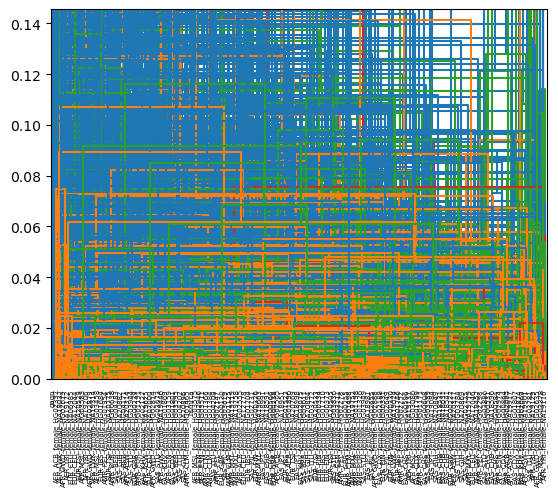

In [26]:
tree_summary = {}
tree_complete = {}
#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete', idx=idx)
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)

### Genome AVG w/ GAGP and HSMRCA

In [27]:
b = pd.DataFrame(anc_div.mean(), columns=['hsmrca'])
a = matrix_3d.copy()
a = a[idx_wa].loc[idx_wa].append(b['hsmrca'])
a['hsmrca'] = b['hsmrca']

c = pd.DataFrame(gagp_div.mean(), columns=['gagp'])

a = a[idx_hsmrca].loc[idx_hsmrca].append(c['gagp'])
a['gagp'] = c['gagp']

In [28]:
a

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
AFR_ACB_female_HG01896                     NaN                0.003937   
AFR_ACB_female_HG02095                0.003937                     NaN   
AFR_ACB_female_HG02337                0.003889                0.004011   
AFR_ACB_female_HG02505                0.004065                0.003786   
AFR_ACB_female_HG02555                0.003898                0.003978   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.003942                0.003971   
SAS_STU_female_HG03944                0.004037                0.003896   
SAS_STU_female_HG03949                0.003960                0.003769   
hsmrca                                0.004175                0.004517   
gagp                                  0.017177                0.017463   

                        AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
AFR_ACB_female_HG01896                0.003889                0.004065   
AFR_ACB_female_HG02095                0.004011                0.003786   
AFR_ACB_female_HG02337                     NaN                0.004178   
AFR_ACB_female_HG02505                0.004178                     NaN   
AFR_ACB_female_HG02555                0.003981                0.003863   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.004227                0.003638   
SAS_STU_female_HG03944                0.004040                0.003824   
SAS_STU_female_HG03949                0.003977                0.003821   
hsmrca                                0.004594                0.004341   
gagp                                  0.017663                0.017278   

                        AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
AFR_ACB_female_HG01896                0.003898                0.004089   
AFR_ACB_female_HG02095                0.003978                0.004113   
AFR_ACB_female_HG02337                0.003981                0.004121   
AFR_ACB_female_HG02505                0.003863                0.003760   
AFR_ACB_female_HG02555                     NaN                0.004025   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.003634                0.003690   
SAS_STU_female_HG03944                0.003742                0.003651   
SAS_STU_female_HG03949                0.003940                0.003553   
hsmrca                                0.004432                0.004621   
gagp                                  0.017380                0.017782   

                        AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
AFR_ACB_female_HG01896                0.003789                0.004003   
AFR_ACB_female_HG02095                0.003536                0.004006   
AFR_ACB_female_HG02337                0.003876                0.004078   
AFR_ACB_female_HG02505                0.003756                0.004115   
AFR_ACB_female_HG02555                0.003878                0.004156   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.003660                0.004120   
SAS_STU_female_HG03944                0.003829                0.004157   
SAS_STU_female_HG03949                0.003728                0.004207   
hsmrca                                0.004246                0.004479   
gagp                                  0.017204                0.017418   

                        AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
AFR_ACB_female_HG01896                0.003812                0.003784  ...   
AFR_ACB_female_HG02095                0.003707                0.003530  ...   
AFR_ACB_female_HG02337                0.003756                0.003818  ...   
AFR_ACB_female_HG02505                0.003610                0.003911  ...   
AFR_ACB_female_HG02555                0.003743                0.004031  .

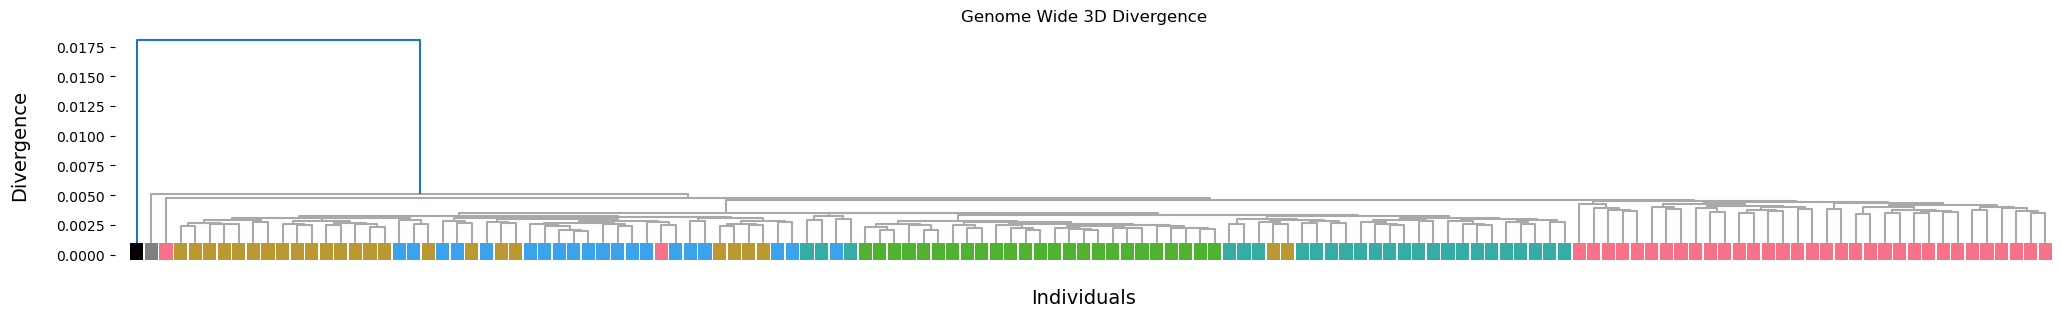

In [31]:
length = len(idx)
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0005)
plt.tick_params(
axis='x',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 132

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'hsmrca':'grey', 'gagp':'black'}

lineage_dict = {}
for i in range(len(idx)):
    lineage_dict[i]=idx[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if (c != 'hsmrca') & (c!='gagp'):
        c = c[:3]
    c = sup_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1325,10)
#plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
for x, y, z in zip(new_leaf_x, leaf_y, new_colors): # as rectangles
        rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.009, facecolor = z, zorder = 10)
        #rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.008, facecolor = z, edgecolor = 'black', linewidth = 0.5, zorder = 10)
        ax.add_patch(rect)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide 3D Divergence')
plt.show()

#### Sequence Average

In [20]:
hsmrca_gagp_seq = pd.read_table('%s/SeqComps_hsmrca_ancestral_vs_GAGP_ancestral.txt' % DATA_PATH, index_col=[0,1], names=['chr','windowStartPos','hsmrcaCov','gagpCov','seqID'], skiprows=1)
hsmrca_gagp_seq = hsmrca_gagp_seq.loc[windows.index]
hsmrca_gagp_seq.seqID = hsmrca_gagp_seq.seqID.astype('float')
hsmrca_gagp_seq['seqDiff'] = 1-hsmrca_gagp_seq['seqID'] 

hsmrca_seq = pd.DataFrame(index = anc_div.index, columns = anc_div.columns)
gagp_seq = pd.DataFrame(index = anc_div.index, columns = anc_div.columns)
for i in anc_div.columns:
    print(i)
    # HSMRCA
    filename = "%s1KGvsHSMRCA/SeqComps_%s_vs_hsmrca_ancestral.txt" % (DATA_PATH, i)
    cols = ['chr','windowStartPos','modernCov','hsmrcaCov','seqID']

    icomp = pd.read_table(filename, index_col=[0,1], names=cols, skiprows=1)
    icomp = icomp.loc[windows.index]
    icomp.seqID = icomp.seqID.astype('float')
    icomp['seqDiff'] = 1-icomp['seqID']

    hsmrca_seq[i] = icomp['seqDiff']


    #GAGP
    filename = "%s1KGvsGAGP/SeqComps_%s_vs_GAGP_ancestral.txt" % (DATA_PATH, i)
    cols = ['chr','windowStartPos','modernCov','gagpCov','seqID']

    icomp = pd.read_table(filename, index_col=[0,1], names=cols, skiprows=1)
    icomp = icomp.loc[windows.index]
    icomp.seqID = icomp.seqID.astype('float')
    icomp['seqDiff'] = 1-icomp['seqID'] 

    gagp_seq[i] = icomp['seqDiff']


AFR_ACB_female_HG01896
AFR_ACB_female_HG02095
AFR_ACB_female_HG02337
AFR_ACB_female_HG02505
AFR_ACB_female_HG02555
AFR_ASW_female_NA19625
AFR_ASW_female_NA19901
AFR_ASW_female_NA19917
AFR_ASW_female_NA20314
AFR_ASW_female_NA20317
AFR_ESN_female_HG02946
AFR_ESN_female_HG02974
AFR_ESN_female_HG03111
AFR_ESN_female_HG03159
AFR_ESN_female_HG03511
AFR_GWD_female_HG02635
AFR_GWD_female_HG02679
AFR_GWD_female_HG02814
AFR_GWD_female_HG02879
AFR_GWD_female_HG02888
AFR_LWK_female_NA19024
AFR_LWK_female_NA19037
AFR_LWK_female_NA19314
AFR_LWK_female_NA19446
AFR_LWK_female_NA19457
AFR_MSL_female_HG03086
AFR_MSL_female_HG03378
AFR_MSL_female_HG03458
AFR_MSL_female_HG03575
AFR_MSL_female_HG03583
AFR_YRI_female_NA19116
AFR_YRI_female_NA19129
AFR_YRI_female_NA19137
AFR_YRI_female_NA19172
AFR_YRI_female_NA19206
AMR_CLM_female_HG01125
AMR_CLM_female_HG01366
AMR_CLM_female_HG01384
AMR_CLM_female_HG01465
AMR_CLM_female_HG01498
AMR_MXL_female_NA19663
AMR_MXL_female_NA19719
AMR_MXL_female_NA19752
AMR_MXL_fem

In [21]:
gagp_seq['hsmrca'] = hsmrca_gagp_seq['seqDiff']

In [22]:
gagp_seq

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
chr   windowStartPos                                                   
chr1  1048576                       0.007053                0.006964   
      1572864                       0.008629                0.008608   
      3145728                       0.008642                0.008781   
      3670016                       0.008368                0.008478   
      4194304                       0.008193                0.008269   
...                                      ...                     ...   
chr22 46661632                      0.008937                0.008935   
      47185920                      0.008929                0.008879   
      47710208                      0.009295                0.009254   
      48234496                      0.010205                0.010213   
      48758784                      0.010369                0.010429   

                      AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
chr   windowStartPos                                                   
chr1  1048576                       0.007178                0.007017   
      1572864                       0.008640                0.008593   
      3145728                       0.008676                0.008631   
      3670016                       0.008425                0.008378   
      4194304                       0.008251                0.008286   
...                                      ...                     ...   
chr22 46661632                      0.008901                0.008793   
      47185920                      0.008980                0.008880   
      47710208                      0.009315                0.009295   
      48234496                      0.010245                0.010159   
      48758784                      0.010476                0.010405   

                      AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
chr   windowStartPos                                                   
chr1  1048576                       0.006925                0.007000   
      1572864                       0.008597                0.008670   
      3145728                       0.008838                0.008762   
      3670016                       0.008541                0.008419   
      4194304                       0.008295                0.008204   
...                                      ...                     ...   
chr22 46661632                      0.008889                0.008862   
      47185920                      0.009017                0.008822   
      47710208                      0.009403                0.009174   
      48234496                      0.010256                0.010043   
      48758784                      0.010431                0.010168   

                      AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
chr   windowStartPos                                                   
chr1  1048576                       0.007051                0.007048   
      1572864                       0.008601                0.008559   
      3145728                       0.008660                0.008604   
      3670016                       0.008404                0.008415   
      4194304                       0.008237                0.008263   
...                                      ...                     ...   
chr22 46661632                      0.008778                0.008950   
      47185920                      0.008824                0.008949   
      47710208                      0.009321                0.009356   
      48234496                      0.010302                0.010218   
      48758784                      0.010472                0.010306   

                      AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
chr   windowStartPos                                                  ...   
chr1  1048576                       0.006997                0.006783  ...   
      1572864                       0.00850

In [23]:
gagp_seq

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
chr   windowStartPos                                                   
chr1  1048576                       0.007053                0.006964   
      1572864                       0.008629                0.008608   
      3145728                       0.008642                0.008781   
      3670016                       0.008368                0.008478   
      4194304                       0.008193                0.008269   
...                                      ...                     ...   
chr22 46661632                      0.008937                0.008935   
      47185920                      0.008929                0.008879   
      47710208                      0.009295                0.009254   
      48234496                      0.010205                0.010213   
      48758784                      0.010369                0.010429   

                      AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
chr   windowStartPos                                                   
chr1  1048576                       0.007178                0.007017   
      1572864                       0.008640                0.008593   
      3145728                       0.008676                0.008631   
      3670016                       0.008425                0.008378   
      4194304                       0.008251                0.008286   
...                                      ...                     ...   
chr22 46661632                      0.008901                0.008793   
      47185920                      0.008980                0.008880   
      47710208                      0.009315                0.009295   
      48234496                      0.010245                0.010159   
      48758784                      0.010476                0.010405   

                      AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
chr   windowStartPos                                                   
chr1  1048576                       0.006925                0.007000   
      1572864                       0.008597                0.008670   
      3145728                       0.008838                0.008762   
      3670016                       0.008541                0.008419   
      4194304                       0.008295                0.008204   
...                                      ...                     ...   
chr22 46661632                      0.008889                0.008862   
      47185920                      0.009017                0.008822   
      47710208                      0.009403                0.009174   
      48234496                      0.010256                0.010043   
      48758784                      0.010431                0.010168   

                      AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
chr   windowStartPos                                                   
chr1  1048576                       0.007051                0.007048   
      1572864                       0.008601                0.008559   
      3145728                       0.008660                0.008604   
      3670016                       0.008404                0.008415   
      4194304                       0.008237                0.008263   
...                                      ...                     ...   
chr22 46661632                      0.008778                0.008950   
      47185920                      0.008824                0.008949   
      47710208                      0.009321                0.009356   
      48234496                      0.010302                0.010218   
      48758784                      0.010472                0.010306   

                      AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
chr   windowStartPos                                                  ...   
chr1  1048576                       0.006997                0.006783  ...   
      1572864                       0.00850

In [24]:
for w in dict_seq.keys():
    b = hsmrca_seq.loc[[w]]
    b = b.reset_index(drop=True).rename(index={0:'hsmrca'})
    a = dict_seq[w].copy()
    a = a[idx_wa].loc[idx_wa].append(b)
    a['hsmrca'] = b.T['hsmrca']

    c = gagp_seq.loc[[w]]
    c = c.reset_index(drop=True).rename(index={0:'gagp'})
    a = a[idx_hsmrca].loc[idx_hsmrca].append(c)
    a['gagp'] = c.T['gagp']

    dict_seq[w] = a

In [1]:
b = pd.DataFrame(hsmrca_seq.mean(), columns=['hsmrca'])
a = matrix_seq.copy()
a = a[idx_wa].loc[idx_wa].append(b['hsmrca'])
a['hsmrca'] = b['hsmrca']

c = pd.DataFrame(gagp_seq.mean(), columns=['gagp'])

a = a[idx_hsmrca].loc[idx_hsmrca].append(c['gagp'])
a['gagp'] = c['gagp']

sup_idx = [i.split('_', 1)[0] for i in idx]

NameError: name 'pd' is not defined

In [ ]:
a

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
AFR_ACB_female_HG01896                     NaN                0.001297   
AFR_ACB_female_HG02095                0.001297                     NaN   
AFR_ACB_female_HG02337                0.001293                0.001292   
AFR_ACB_female_HG02505                0.001294                0.001296   
AFR_ACB_female_HG02555                0.001291                0.001295   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001325                0.001317   
SAS_STU_female_HG03944                0.001318                0.001312   
SAS_STU_female_HG03949                0.001323                0.001311   
hsmrca                                0.001613                0.001622   
gagp                                  0.006359                0.006367   

                        AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
AFR_ACB_female_HG01896                0.001293                0.001294   
AFR_ACB_female_HG02095                0.001292                0.001296   
AFR_ACB_female_HG02337                     NaN                0.001290   
AFR_ACB_female_HG02505                0.001290                     NaN   
AFR_ACB_female_HG02555                0.001297                0.001285   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001301                0.001303   
SAS_STU_female_HG03944                0.001293                0.001294   
SAS_STU_female_HG03949                0.001290                0.001293   
hsmrca                                0.001614                0.001613   
gagp                                  0.006358                0.006357   

                        AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
AFR_ACB_female_HG01896                0.001291                0.001299   
AFR_ACB_female_HG02095                0.001295                0.001295   
AFR_ACB_female_HG02337                0.001297                0.001295   
AFR_ACB_female_HG02505                0.001285                0.001293   
AFR_ACB_female_HG02555                     NaN                0.001291   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001305                0.001204   
SAS_STU_female_HG03944                0.001293                0.001195   
SAS_STU_female_HG03949                0.001295                0.001195   
hsmrca                                0.001617                0.001602   
gagp                                  0.006361                0.006344   

                        AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
AFR_ACB_female_HG01896                0.001293                0.001296   
AFR_ACB_female_HG02095                0.001306                0.001299   
AFR_ACB_female_HG02337                0.001295                0.001296   
AFR_ACB_female_HG02505                0.001300                0.001302   
AFR_ACB_female_HG02555                0.001294                0.001296   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001307                0.001304   
SAS_STU_female_HG03944                0.001295                0.001300   
SAS_STU_female_HG03949                0.001298                0.001299   
hsmrca                                0.001619                0.001614   
gagp                                  0.006363                0.006359   

                        AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
AFR_ACB_female_HG01896                0.001319                0.001294  ...   
AFR_ACB_female_HG02095                0.001305                0.001300  ...   
AFR_ACB_female_HG02337                0.001285                0.001283  ...   
AFR_ACB_female_HG02505                0.001288                0.001284  ...   
AFR_ACB_female_HG02555                0.001287                0.001298  .

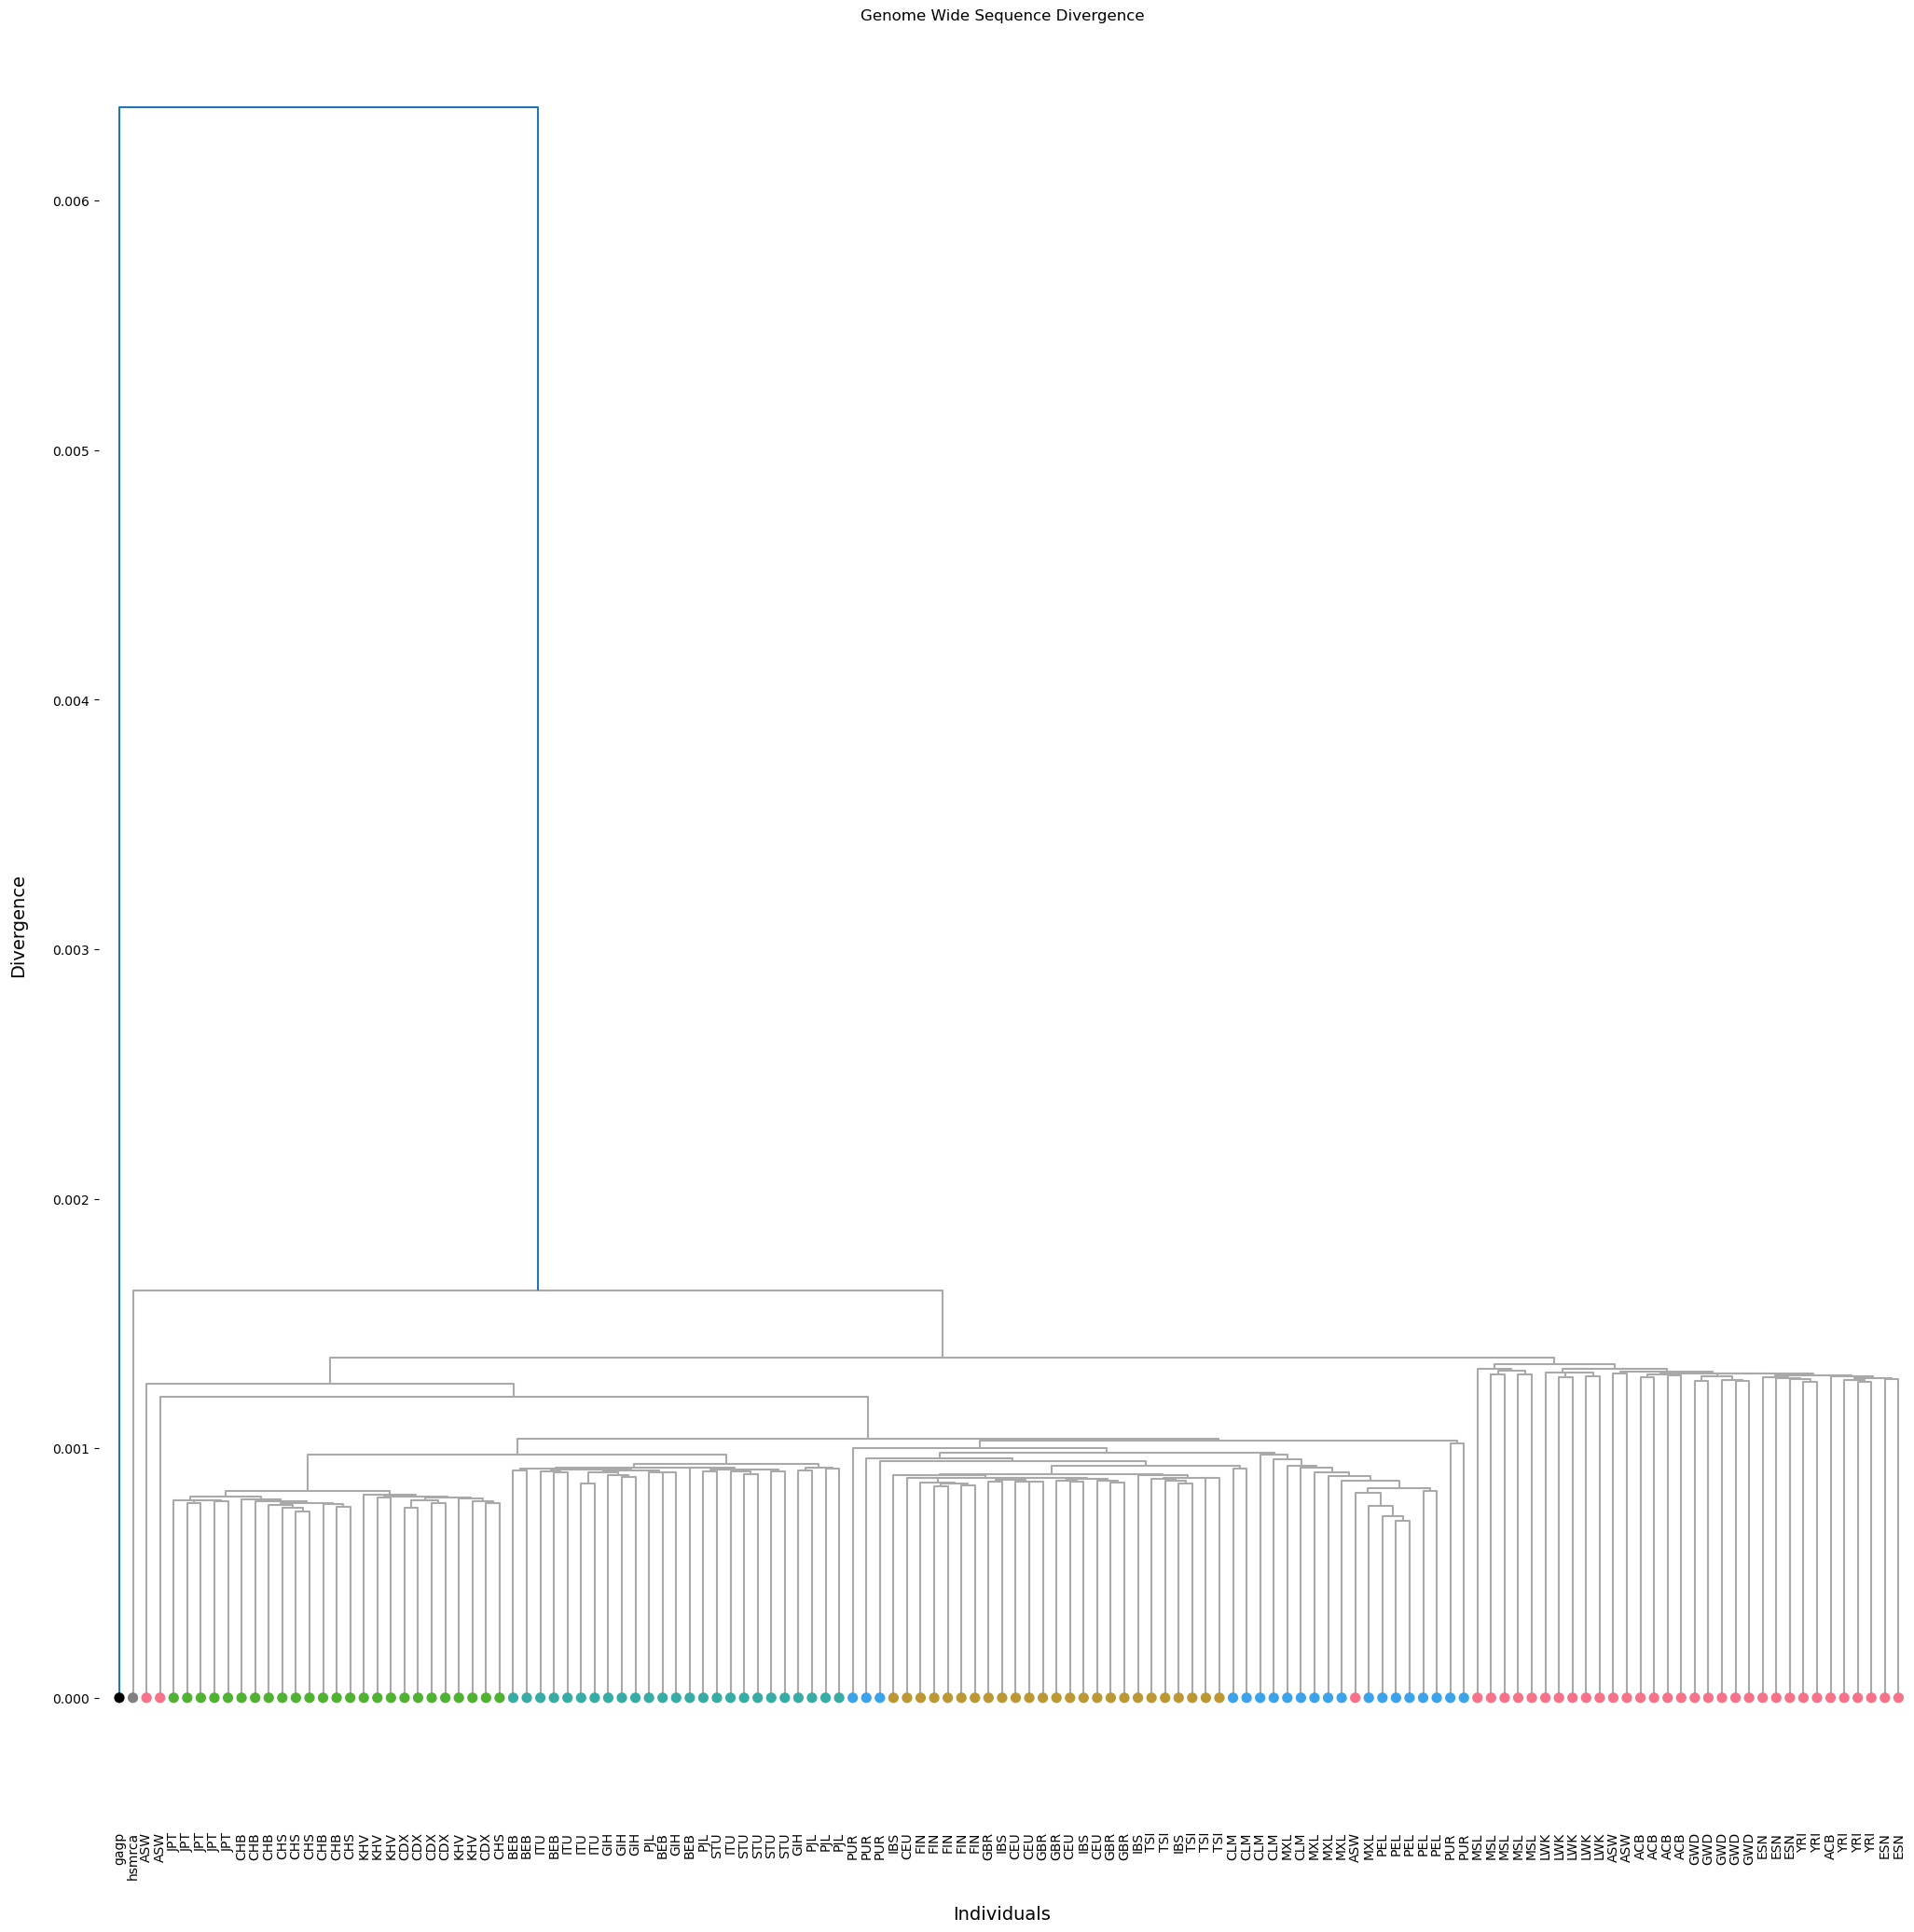

In [ ]:
length = len(idx)
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,25))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0005)
# plt.tick_params(
# axis='x',          # changes apply to the x-axis
# which='both',      # both major and minor ticks are affected
# bottom=False,      # ticks along the bottom edge are off
# top=False,         # ticks along the top edge are off
# labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 132

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'hsmrca':'grey', 'gagp':'black'}

lineage_dict = {}
for i in range(len(idx)):
    lineage_dict[i]=idx[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if (c != 'hsmrca') & (c!='gagp'):
        c = c[:3]
    c = sup_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1325,10)
plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide Sequence Divergence')
plt.show()

In [ ]:
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')
T = Tree(to_newick(hc.to_tree(Z), sup_idx), format=1)


In [ ]:
def name_internal_nodes(T):
    for node in T.traverse():
        if node.is_leaf()==False:
            # list names of leaves
            leaf_names=[leaf.name for leaf in node.iter_leaves()]
            names_unique = list(set(leaf_names))
            # if all leaves have the same name, give that name to the node
            if (len(names_unique)==1):
                node.name = names_unique[0]

def collapsed_leaf(node):
    if len(node2labels[node]) == 1:
       return True
    else:
       return False

In [ ]:
t1 = T
print(t1.get_ascii(show_internal=True))


                                    /-AFR
                                 /-|
                                |   \-AFR
                              /-|
                             |  |      /-AFR
                             |  |   /-|
                           /-|   \-|   \-AFR
                          |  |     |
                          |  |      \-AFR
                          |  |
                          |   \-AFR
                          |
                        /-|            /-AFR
                       |  |         /-|
                       |  |      /-|   \-AFR
                       |  |     |  |
                       |  |   /-|   \-AFR
                       |  |  |  |
                       |   \-|   \-AFR
                     /-|     |
                    |  |      \-AFR
                    |  |
                    |  |         /-AFR
                    |  |      /-|
                    |  |   /-|   \-AFR
                    |  |  |  |
                    |  

In [ ]:
name_internal_nodes(t1)
print(t1.get_ascii(show_internal=True))


                                    /-AFR
                                 /AFR
                                |   \-AFR
                              /AFR
                             |  |      /-AFR
                             |  |   /AFR
                           /AFR  \AFR  \-AFR
                          |  |     |
                          |  |      \-AFR
                          |  |
                          |   \-AFR
                          |
                        /AFR           /-AFR
                       |  |         /AFR
                       |  |      /AFR  \-AFR
                       |  |     |  |
                       |  |   /AFR  \-AFR
                       |  |  |  |
                       |   \AFR  \-AFR
                     /AFR    |
                    |  |      \-AFR
                    |  |
                    |  |         /-AFR
                    |  |      /AFR
                    |  |   /AFR  \-AFR
                    |  |  |  |
                  

In [ ]:
node2labels = t1.get_cached_content(store_attr="name")

In [ ]:
t2 = Tree( t1.write(is_leaf_fn=collapsed_leaf, quoted_node_names=True), quoted_node_names=True)
print(t2.get_ascii(show_internal=True))


         /-AFR
        |
        |            /-AMR
        |           |
        |           |                              /-AMR
        |           |                           /-|
        |           |                          |  |   /-AMR
        |           |                        /-|   \-|
        |           |                       |  |      \-AFR
        |           |                     /-|  |
        |           |                    |  |   \-AMR
        |           |                  /-|  |
        |           |                 |  |   \-AMR
        |           |               /-|  |
        |         /-|              |  |   \-AMR
        |        |  |            /-|  |
        |        |  |           |  |   \-AMR
      /-|        |  |         /-|  |
     |  |        |  |        |  |   \-AMR
     |  |        |  |      /-|  |
     |  |        |  |     |  |   \-AMR
     |  |        |  |     |  |
     |  |        |  |     |   \-AMR
     |  |        |  |   /-|
     |  |      /-|

In [ ]:
from ete3 import TreeStyle
ts = TreeStyle()
ts.show_leaf_name = True
t2.show(tree_style=ts)

### Windows

In [ ]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=list(idx) + ['coord_0','coord_1','coord_2','coord_3'])

counts_df = dataframe.drop(columns=['coord_0','coord_1', 'coord_2','coord_3']).apply(lambda s: s.value_counts(), axis=1).fillna(0)     
counts_df['depth'] = dataframe['coord_1']

#### IDWs

In [18]:
dataframe

AFR_ACB_female_HG01896 AFR_ACB_female_HG02095  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C1                     C2   
(chr1, 4194304)                       C1                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C3   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ACB_female_HG02337 AFR_ACB_female_HG02505  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C1                     C2   
(chr1, 4194304)                       C1                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C1   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ACB_female_HG02555 AFR_ASW_female_NA19625  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C2   
(chr1, 3670016)                       C2                     C2   
(chr1, 4194304)                       C2                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C1   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ASW_female_NA19901 AFR_ASW_female_NA19917  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C0                     C1   
(chr1, 4194304)                       C2                     C1   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C1   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ASW_female_NA20314 AFR_ASW_female_NA20317  ...  \
(chr1, 1048576)                       C1                     C1  ...   
(chr1, 1572864)                       C1                     C1  ...   
(chr1, 3145728)                       C3                     C3  ...   
(chr1, 3670016)                       C1                     C2  ...   
(chr1, 4194304)                       C1                     C2  ...   
...                                  ...                    ...  ...   
(chr22, 46661632)                     C1                     C3  ...   
(chr22, 47185920)                     C1                     C1  ...   
(chr22, 47710208)                     C2                     C2  ...   
(chr22, 48234496)                     C2                     C2  ...   
(chr22

In [19]:
idw = counts_df[(counts_df.C0==1 )|(counts_df.C1==1)|(counts_df.C2==1)|(counts_df.C3==1)|(counts_df.C4==1)]
idw_list = []
for r in idw.index:
    row = dataframe.loc[[r]]
    ind = row.where(row=='C0').dropna(how='all').dropna(axis=1).dropna(axis=1).columns[0]
    idw_list.append(ind)

In [20]:
len(idw_list)

2724

In [21]:
idw['individual'] = idw_list

In [22]:
idw.individual.value_counts().tail(n=50)

EAS_CHS_female_HG00608    4
EAS_CHB_female_NA18596    4
EUR_GBR_female_HG00255    4
EUR_IBS_female_HG01704    4
SAS_BEB_female_HG04171    4
EUR_FIN_female_HG00326    4
AMR_CLM_female_HG01384    4
EAS_KHV_female_HG02075    4
SAS_STU_female_HG03949    4
EUR_TSI_female_NA20769    4
SAS_BEB_female_HG04183    4
EUR_TSI_female_NA20529    4
EUR_FIN_female_HG00330    4
AMR_MXL_female_NA19758    4
SAS_GIH_female_NA20849    3
EUR_TSI_female_NA20505    3
EAS_CHB_female_NA18531    3
EUR_IBS_female_HG01746    3
SAS_PJL_female_HG02649    3
EUR_GBR_female_HG00239    3
AFR_ACB_female_HG02095    3
AMR_PEL_female_HG02252    3
SAS_GIH_female_NA20896    3
EAS_CHB_female_NA18541    3
SAS_BEB_female_HG03589    3
EAS_CHB_female_NA18591    3
EAS_CDX_female_HG00864    3
AMR_CLM_female_HG01366    2
AMR_MXL_female_NA19752    2
AMR_PEL_female_HG02278    2
AFR_YRI_female_NA19206    2
AMR_MXL_female_NA19779    2
EUR_FIN_female_HG00334    2
AMR_PUR_female_HG00638    2
AMR_MXL_female_NA19663    2
EUR_TSI_female_NA205

Text(0, 0.5, 'window count')

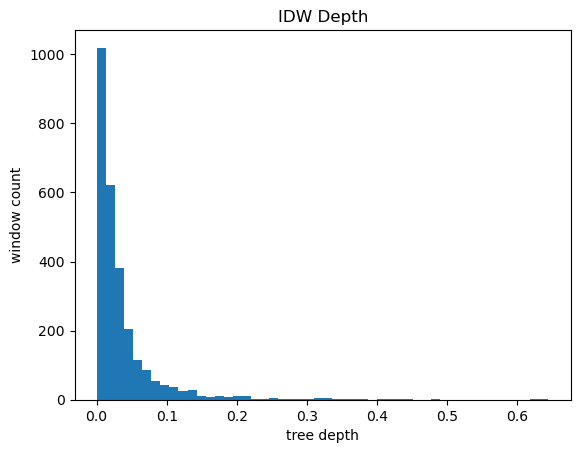

In [23]:
plt.hist(idw.depth, bins=50)
plt.title("IDW Depth")
plt.xlabel("tree depth")
plt.ylabel("window count")

In [24]:
def get_super_pop(idw_row):
    return idw_row.individual.split('_')[0]

In [25]:
idw_counts = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS','hsmrca','gagp'])
for key in idw_counts.keys():
    idw_counts[key] = 0

for i in range(idw.shape[0]):
    super_pop = get_super_pop(idw.iloc[i])
    idw_counts[super_pop] += 1

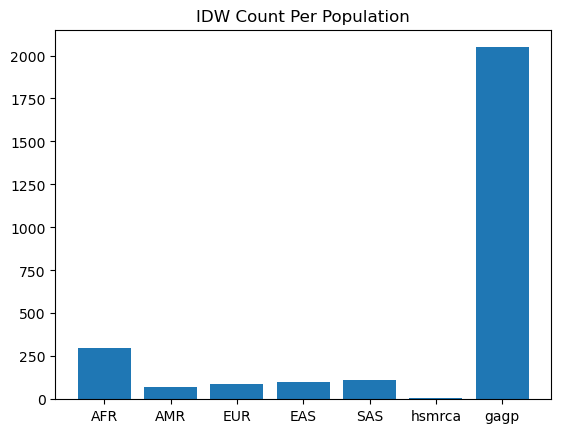

In [26]:
plt.bar(*zip(*idw_counts.items()))
plt.title('IDW Count Per Population')
plt.show()

In [27]:
sum(idw_counts.values())

2724

In [28]:
idw_counts.items()

dict_items([('AFR', 298), ('AMR', 72), ('EUR', 87), ('EAS', 103), ('SAS', 111), ('hsmrca', 5), ('gagp', 2048)])

In [29]:
298+72+87+103+111+5+2048

2724

#### FDWs

In [30]:
fdw = counts_df[((counts_df.C0<=5 )& (counts_df.C0>=2 ))|
                ((counts_df.C0 == 0.0) & ((counts_df.C1<=5 )& (counts_df.C1>=2 )))
                 # |
                # ((counts_df.C2<=5 )& (counts_df.C2>=2 ))|
                # ((counts_df.C3<=5 )& (counts_df.C3>=2 ))|
                # ((counts_df.C4<=5 )& (counts_df.C4>=2 ))|
                # ((counts_df.C5<=5 )& (counts_df.C5>=2 ))

]

In [31]:
def get_smallest_cluster(r, fdw):
    df = fdw.drop(columns=['depth'])
    fdw_row = df.loc[[r]]
    # idx = fdw_row.where(fdw_row != 0.0).dropna(axis=1).idxmin(axis=1).values[0]
    # size = fdw_row.where(fdw_row != 0.0).dropna(axis=1).min(axis=1).values[0]
    
    if fdw_row.C0.values[0] != 0.0:
        idx = 'C0'
    else:
        idx = 'C1'
    size = fdw_row[idx]
    return idx, size

def get_cluster_inds(cluster_id, window):
    inds = dataframe.loc[[window]].where(dataframe.loc[[window]]==cluster_id).dropna(axis=1).columns
    return list(inds)


def get_cluster_purity(df):
    pure_super_list=[]
    supers = []
    pure_sub_list=[]
    subs = []
    cluster_sizes = []
    num_clusters = []
    cs = counts_df[['C0','C1','C2','C3','C4']]
    for row in df.index:
        w = row
        c_n = cs.loc[[w]].where(cs.loc[[w]]!=0.0).dropna(axis=1).shape[1]
        c = get_smallest_cluster(w, df)
        c_id = c[0]
        c_size = int(c[1])
        inds = get_cluster_inds(c_id,w)
        super_pop = inds[0][:3]
        sub_pop = inds[0][4:7]
        pure_super = all(item.startswith(super_pop) for item in inds)
        pure_sub = all(item[4:7]==sub_pop for item in inds)
        pure_super_list.append(pure_super)
        pure_sub_list.append(pure_sub)

        cluster_sizes.append(c_size)
        num_clusters.append(c_n)
        if pure_super:
            supers.append(super_pop)
        else:
            supers.append(np.nan)
        if pure_sub:
            subs.append(sub_pop)
        else:
            subs.append(np.nan)
    df['pure_super'] = pure_super_list
    df['pure_sub'] = pure_sub_list

    df['super'] = supers
    df['sub'] = subs

    df['cluster_size'] = cluster_sizes
    df['num_clusters'] = num_clusters
    return df

    

In [32]:
fdw = get_cluster_purity(fdw)

In [33]:
fdw

C0     C1     C2     C3   C4     depth  pure_super  \
(chr1, 7340032)    2.0  130.0    0.0    0.0  0.0  0.003397       False   
(chr1, 9437184)    0.0    4.0  128.0    0.0  0.0  0.143960        True   
(chr1, 9961472)    0.0    4.0  128.0    0.0  0.0  0.031789        True   
(chr1, 15204352)   0.0    4.0  128.0    0.0  0.0  0.035709       False   
(chr1, 15728640)   0.0    4.0  128.0    0.0  0.0  0.021883       False   
...                ...    ...    ...    ...  ...       ...         ...   
(chr22, 26214400)  0.0    4.0   20.0  108.0  0.0  0.003762       False   
(chr22, 26738688)  0.0    2.0  130.0    0.0  0.0  0.030918        True   
(chr22, 27262976)  0.0    2.0  130.0    0.0  0.0  0.005388        True   
(chr22, 30932992)  0.0    3.0  129.0    0.0  0.0  0.019767        True   
(chr22, 31457280)  0.0    2.0  130.0    0.0  0.0  0.015619        True   

                   pure_sub super  sub  cluster_size  num_clusters  
(chr1, 7340032)       False   NaN  NaN             2             2  
(chr1, 9437184)       False   EUR  NaN             4             2  
(chr1, 9961472)       False   EUR  NaN             4             2  
(chr1, 15204352)      False   NaN  NaN             4             2  
(chr1, 15728640)      False   NaN  NaN             4             2  
...                     ...   ...  ...           ...           ...  
(chr22, 26214400)     False   NaN  NaN             4             3  
(chr22, 26738688)     False   EAS  NaN             2             2  
(chr22, 27262976)     False   EAS  NaN             2             2  
(chr22, 30932992)     False   SAS  NaN             3             2  
(chr22, 31457280)     False   SAS  NaN             2             2  

[777 rows x 12 columns]

Text(0.5, 1.0, 'Pure Subpop "Few" Driven Windows by Super Pop')

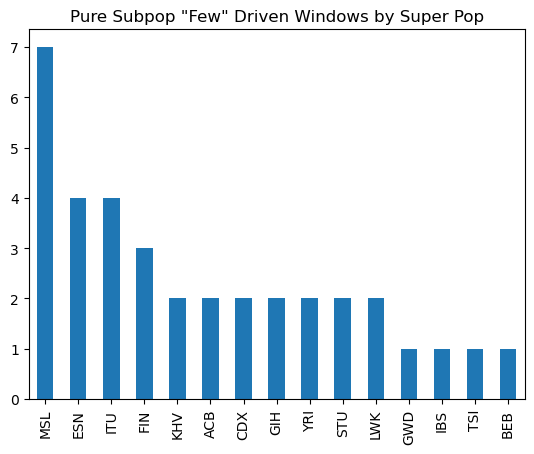

In [35]:
fdw[fdw.pure_sub==True]['sub'].value_counts().plot.bar()
plt.title('Pure Subpop "Few" Driven Windows by Super Pop')

In [36]:
fdw[fdw.pure_super==True].super.value_counts()

AFR    238
SAS     30
EAS     25
EUR     23
AMR      8
Name: super, dtype: int64

Text(0.5, 1.0, 'Pure Super pop "Few" Driven Windows by Super Pop')

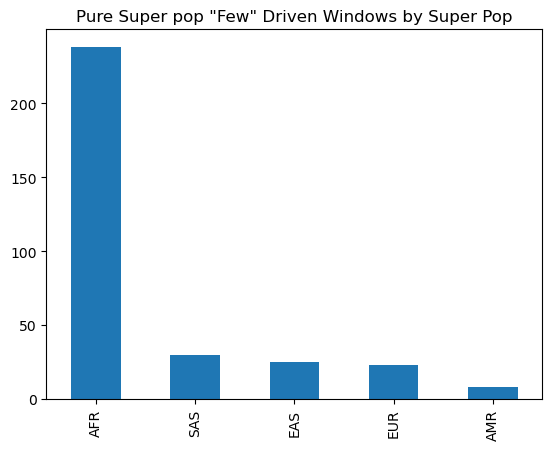

In [37]:
fdw[fdw.pure_super==True].super.value_counts().plot.bar()
plt.title('Pure Super pop "Few" Driven Windows by Super Pop')

In [38]:
fdw

C0     C1     C2     C3   C4     depth  pure_super  \
(chr1, 7340032)    2.0  130.0    0.0    0.0  0.0  0.003397       False   
(chr1, 9437184)    0.0    4.0  128.0    0.0  0.0  0.143960        True   
(chr1, 9961472)    0.0    4.0  128.0    0.0  0.0  0.031789        True   
(chr1, 15204352)   0.0    4.0  128.0    0.0  0.0  0.035709       False   
(chr1, 15728640)   0.0    4.0  128.0    0.0  0.0  0.021883       False   
...                ...    ...    ...    ...  ...       ...         ...   
(chr22, 26214400)  0.0    4.0   20.0  108.0  0.0  0.003762       False   
(chr22, 26738688)  0.0    2.0  130.0    0.0  0.0  0.030918        True   
(chr22, 27262976)  0.0    2.0  130.0    0.0  0.0  0.005388        True   
(chr22, 30932992)  0.0    3.0  129.0    0.0  0.0  0.019767        True   
(chr22, 31457280)  0.0    2.0  130.0    0.0  0.0  0.015619        True   

                   pure_sub super  sub  cluster_size  num_clusters  
(chr1, 7340032)       False   NaN  NaN             2             2  
(chr1, 9437184)       False   EUR  NaN             4             2  
(chr1, 9961472)       False   EUR  NaN             4             2  
(chr1, 15204352)      False   NaN  NaN             4             2  
(chr1, 15728640)      False   NaN  NaN             4             2  
...                     ...   ...  ...           ...           ...  
(chr22, 26214400)     False   NaN  NaN             4             3  
(chr22, 26738688)     False   EAS  NaN             2             2  
(chr22, 27262976)     False   EAS  NaN             2             2  
(chr22, 30932992)     False   SAS  NaN             3             2  
(chr22, 31457280)     False   SAS  NaN             2             2  

[777 rows x 12 columns]

In [39]:
fdw[fdw.pure_super==True].super.value_counts()

AFR    238
SAS     30
EAS     25
EUR     23
AMR      8
Name: super, dtype: int64

In [40]:
238+30+25+23+8

324

#### Homogeneous windows

In [41]:
test = get_cluster_purity(counts_df)

Text(0.5, 1.0, 'Size of first cluster')

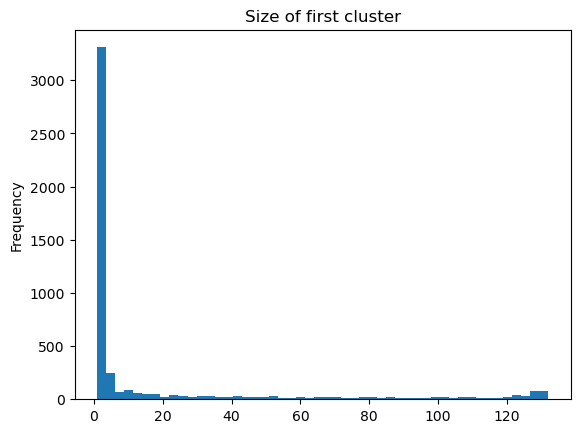

In [42]:
test.cluster_size.plot.hist(bins=50)
plt.title('Size of first cluster')

In [43]:
super_pure = test[test.pure_super]
sub_pure = test[test.pure_sub]

Text(0.5, 1.0, 'Homogeneous Cluster Size Distribution (super)')

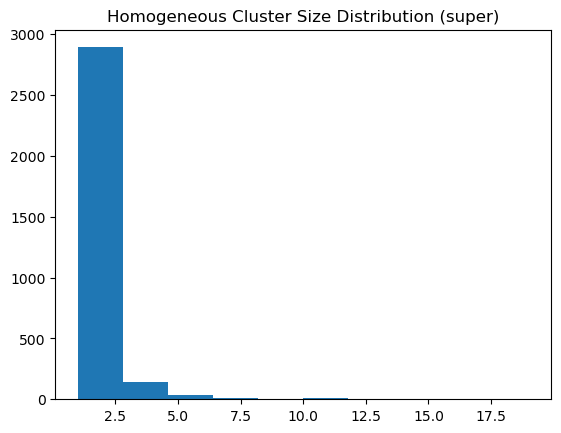

In [44]:
plt.hist(super_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (super)")

Text(0.5, 1.0, 'Homogeneous Cluster Size Distribution (sub)')

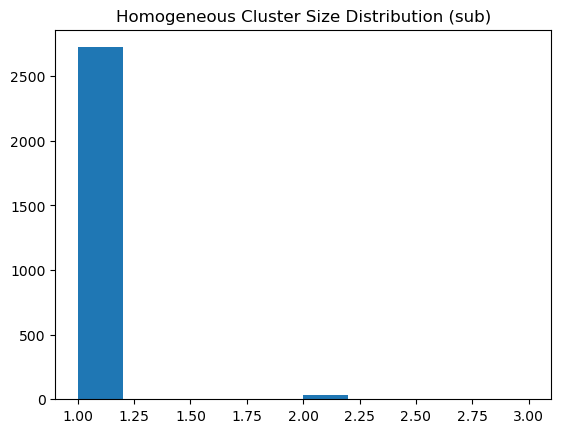

In [45]:
plt.hist(sub_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (sub)")

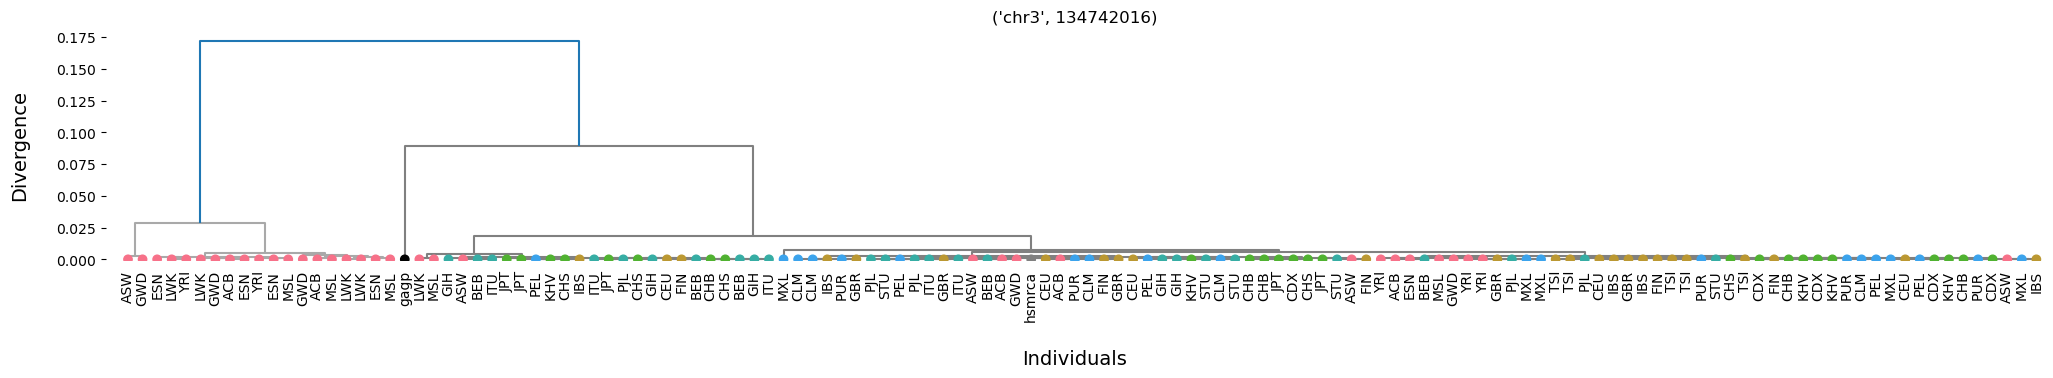

In [46]:
dendrogram = get_window_dendrogram(super_pure.cluster_size.idxmax(), idx)

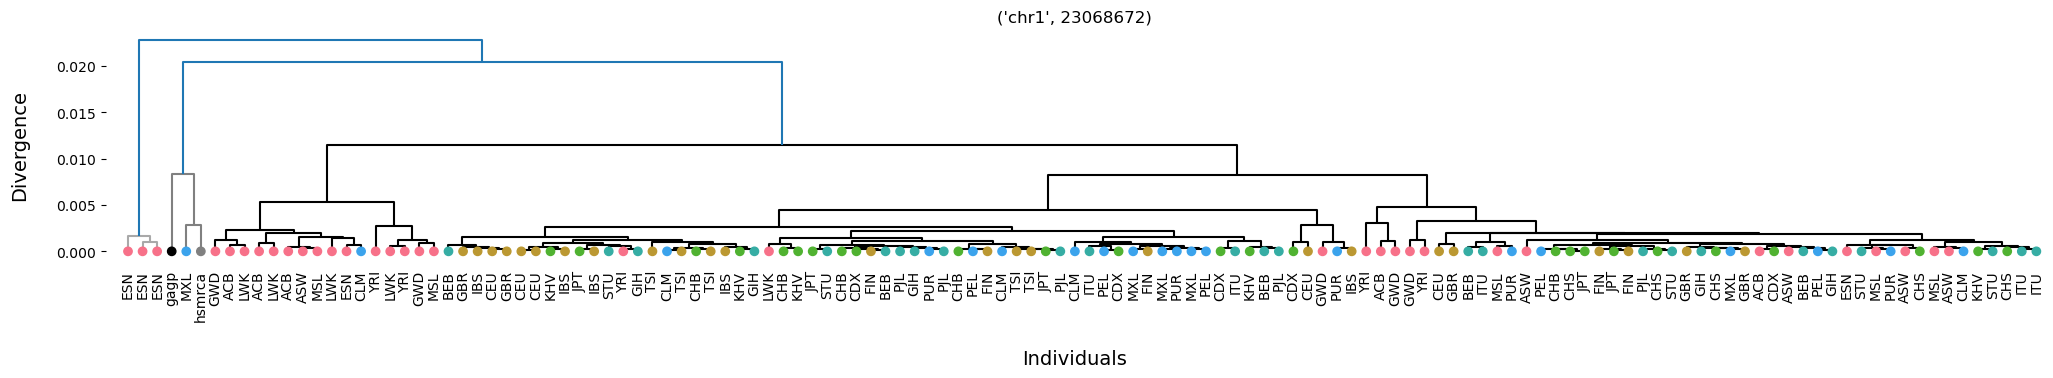

In [47]:
dendrogram = get_window_dendrogram(sub_pure.cluster_size.idxmax(), idx)

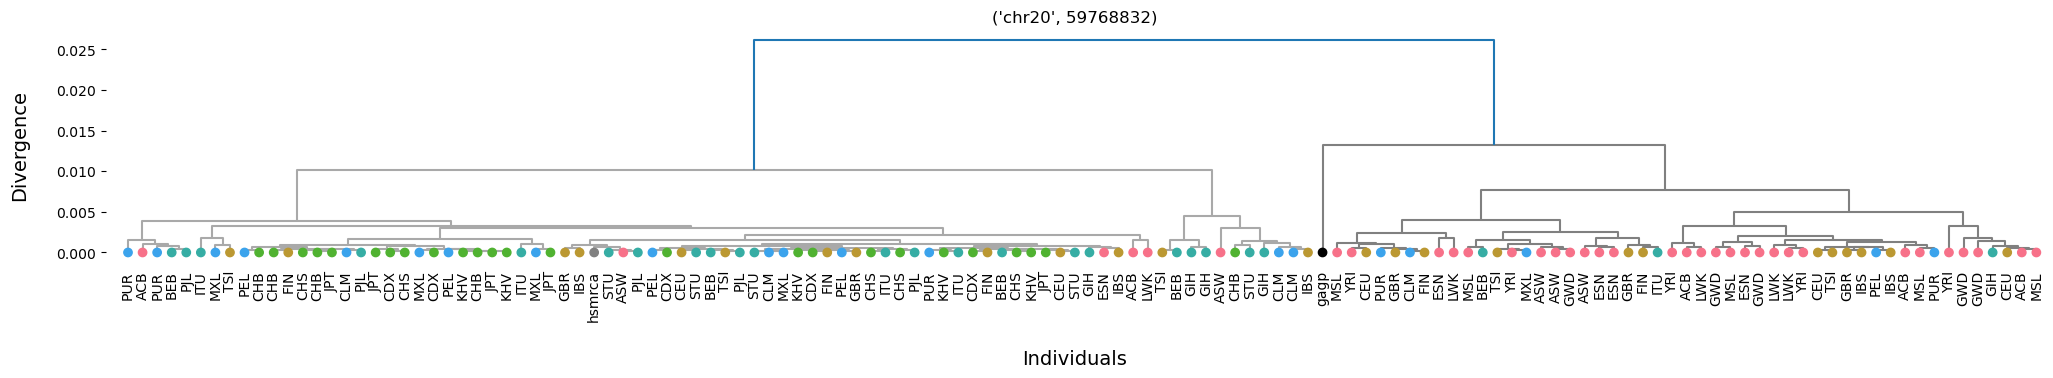

In [48]:
dendrogram = get_window_dendrogram(("chr20", 59768832), idx)

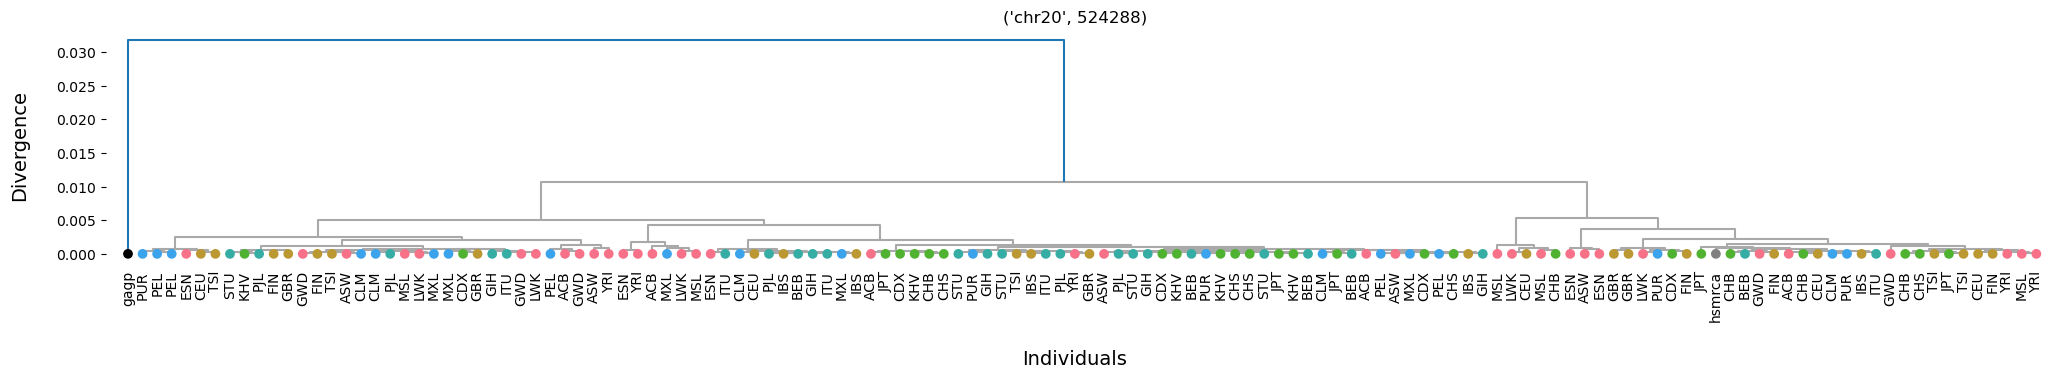

In [49]:
dendrogram = get_window_dendrogram(("chr20", 524288), idx)

### Pull windows to compare to obs/exp 3D divergence windows

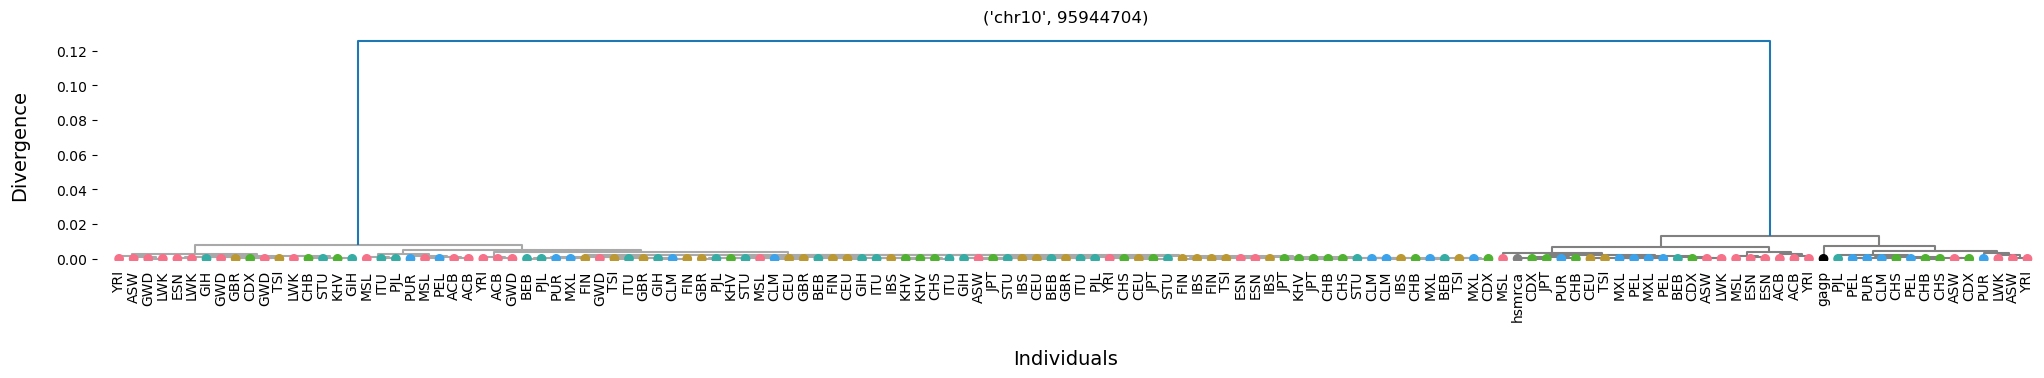

In [23]:
dendrogram = get_window_dendrogram(('chr10', 95944704), idx)

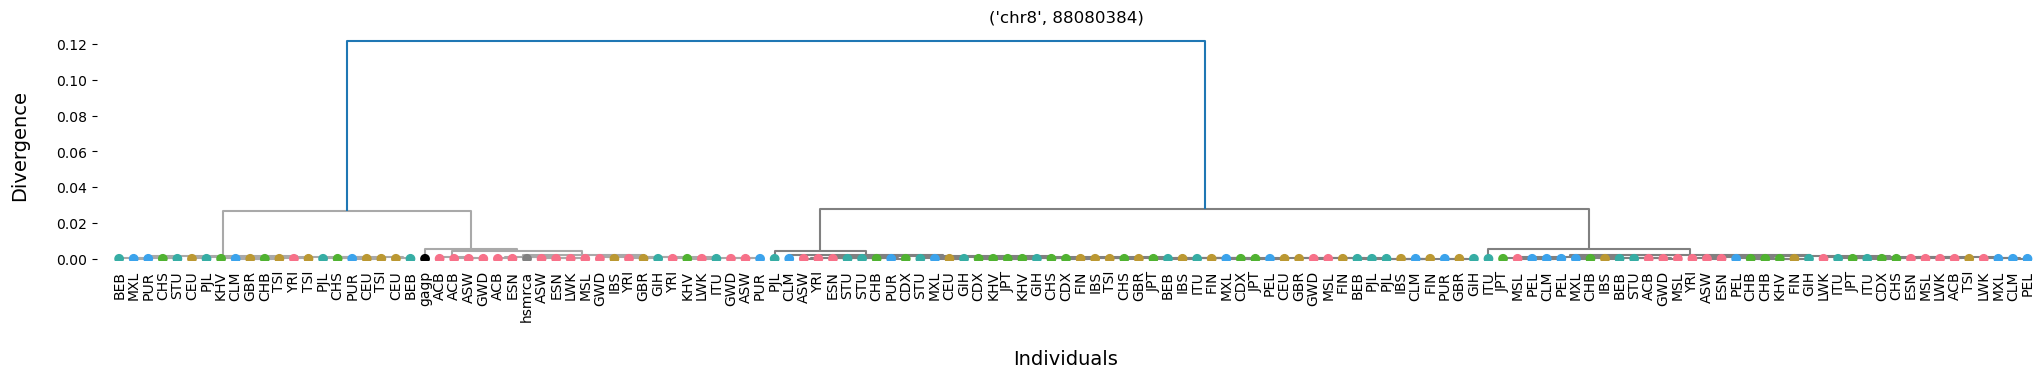

In [24]:
dendrogram = get_window_dendrogram(('chr8', 88080384), idx)

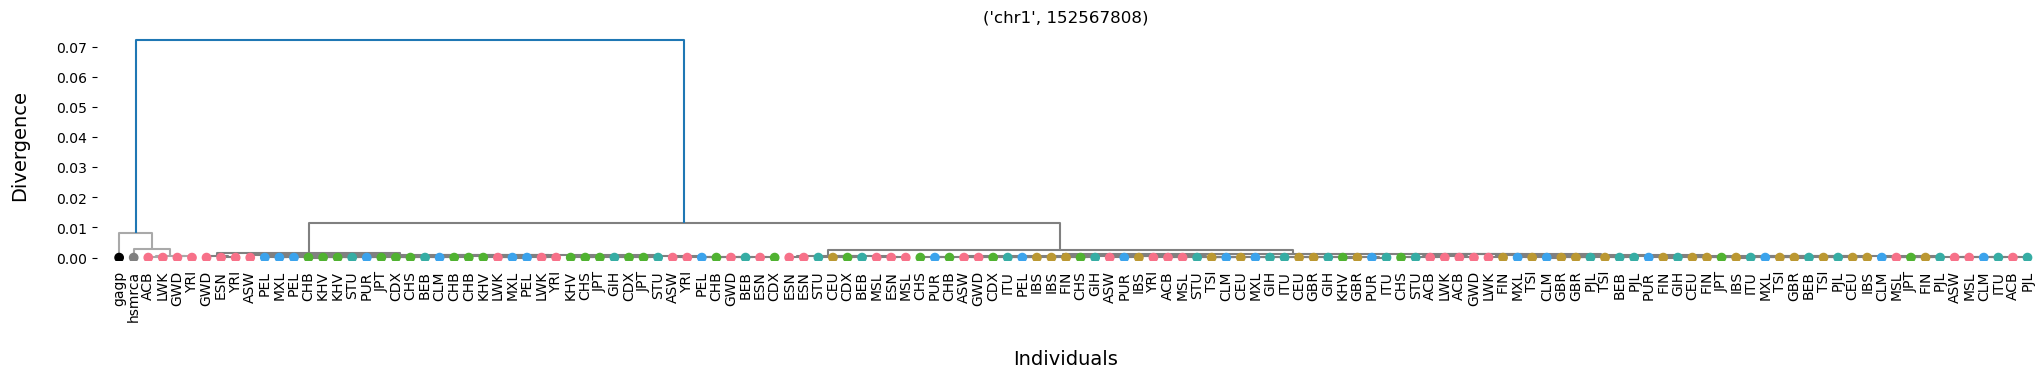

In [25]:
dendrogram = get_window_dendrogram(('chr1', 152567808), idx)

## ETE

In [54]:
hc

<module 'scipy.cluster.hierarchy' from '/Users/egilbertson/miniconda3/envs/modern3d_64/lib/python3.9/site-packages/scipy/cluster/hierarchy.py'>

In [55]:
trees = {}
for w in windows_tuples:
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    trees[w] = T


In [56]:
length = len(idx)
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')
trees['avg'] = Tree(to_newick(hc.to_tree(Z), idx))

### Monophyletic

In [57]:
pops = {key: [] for key in ['AFR','EUR','AMR','SAS','EAS','hsmrca','gagp']}
for i in idx:
    if (i!='hsmrca') & (i!='gagp'):
        pop = i[:3]
    else:
        pop = i
    pops[pop].append(i)

In [58]:
mono = pd.DataFrame(index = windows_tuples, columns = pops.keys())

In [59]:
count = 1
for w in tree_complete.keys():
    print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in pops.keys():
        status = T.check_monophyly(values=pops[p], target_attr="name")[0]
        mono.at[w,p] = status
    count += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [60]:
mono[mono.eq(True).any(1)]

AFR    EUR    AMR    SAS    EAS hsmrca   gagp
(chr1, 122683392)  True  False  False  False  False  False  False
(chr1, 123207680)  True  False  False  False  False  False  False
(chr1, 123731968)  True  False  False  False  False  False  False
(chr3, 92274688)   True  False  False  False  False  False  False
(chr5, 47710208)   True  False  False  False  False  False  False
(chr5, 48234496)   True  False  False  False  False  False  False
(chr9, 43515904)   True  False  False  False  False  False  False
(chr12, 35127296)  True  False  False  False  False  False  False
(chr17, 23592960)  True  False  False  False  False  False  False
(chr17, 24117248)  True  False  False  False  False  False  False
(chr18, 17301504)  True  False  False  False  False  False  False
(chr18, 19398656)  True  False  False  False  False  False  False
(chr19, 25165824)  True  False  False  False  False  False  False
(chr19, 25690112)  True  False  False  False  False  False  False

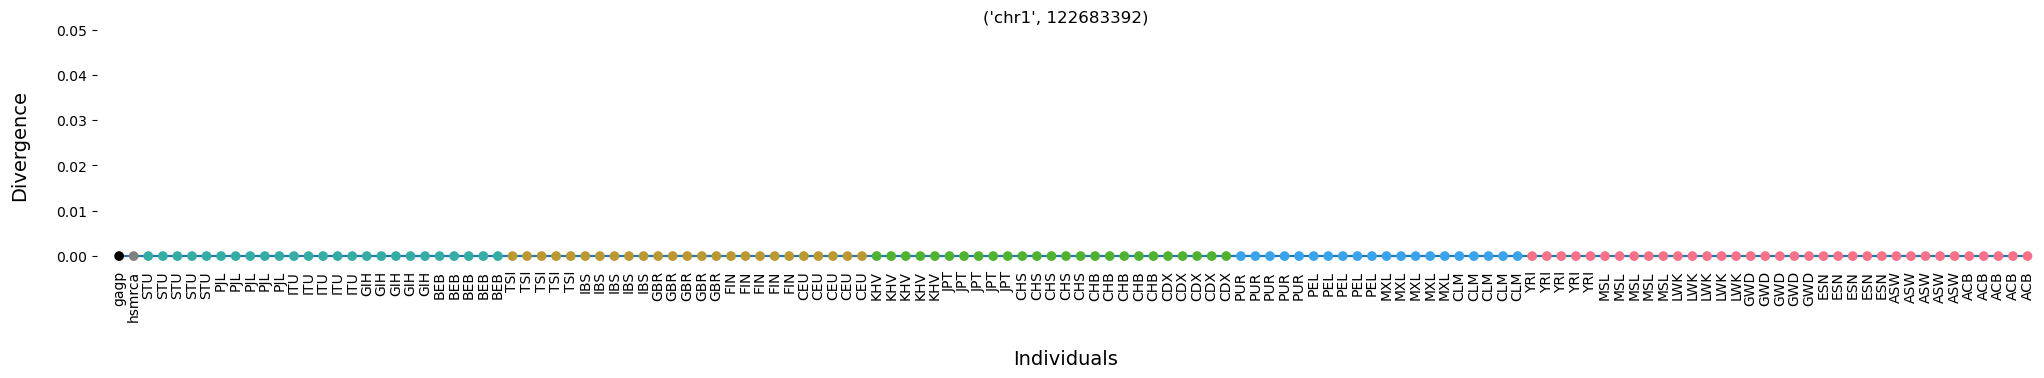

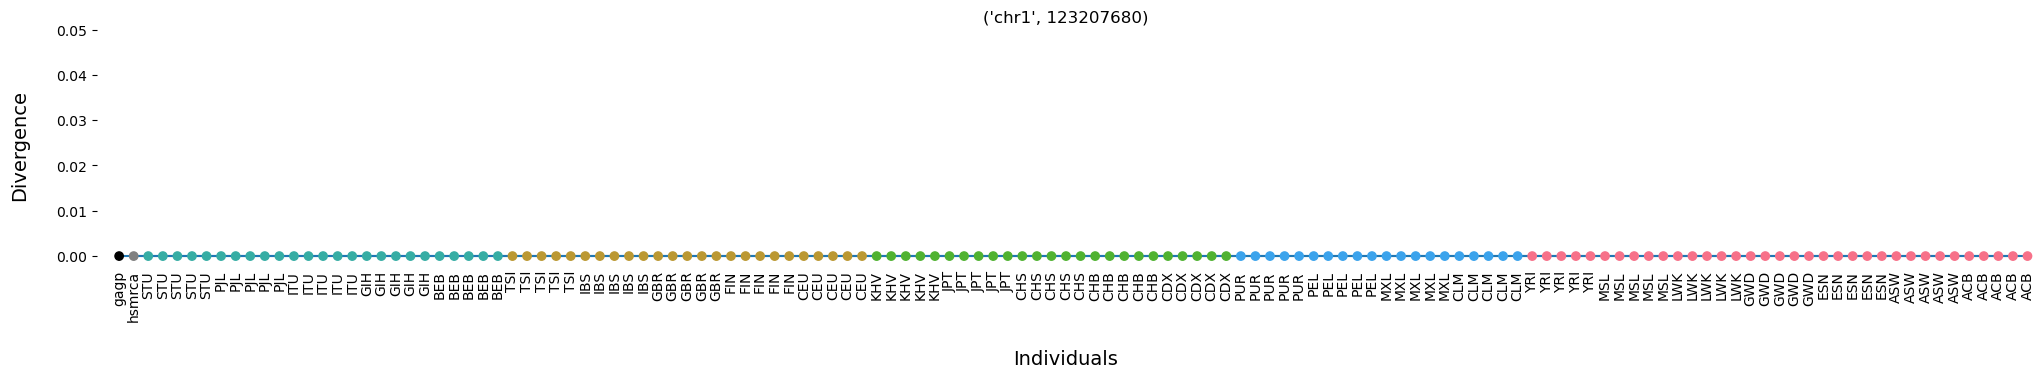

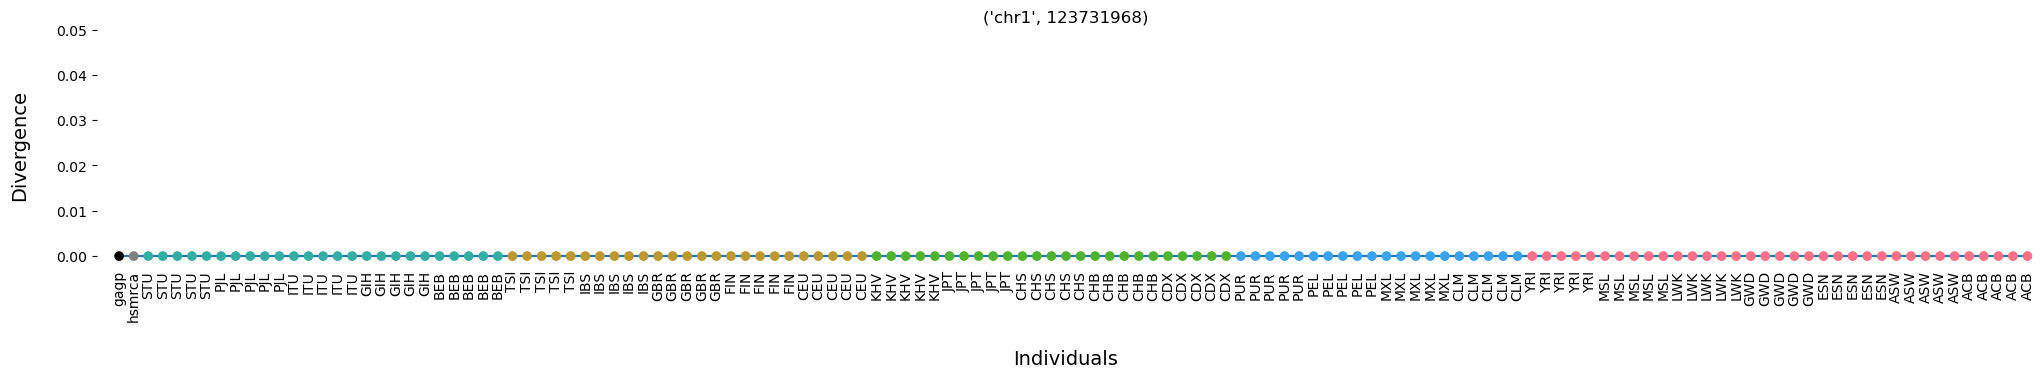

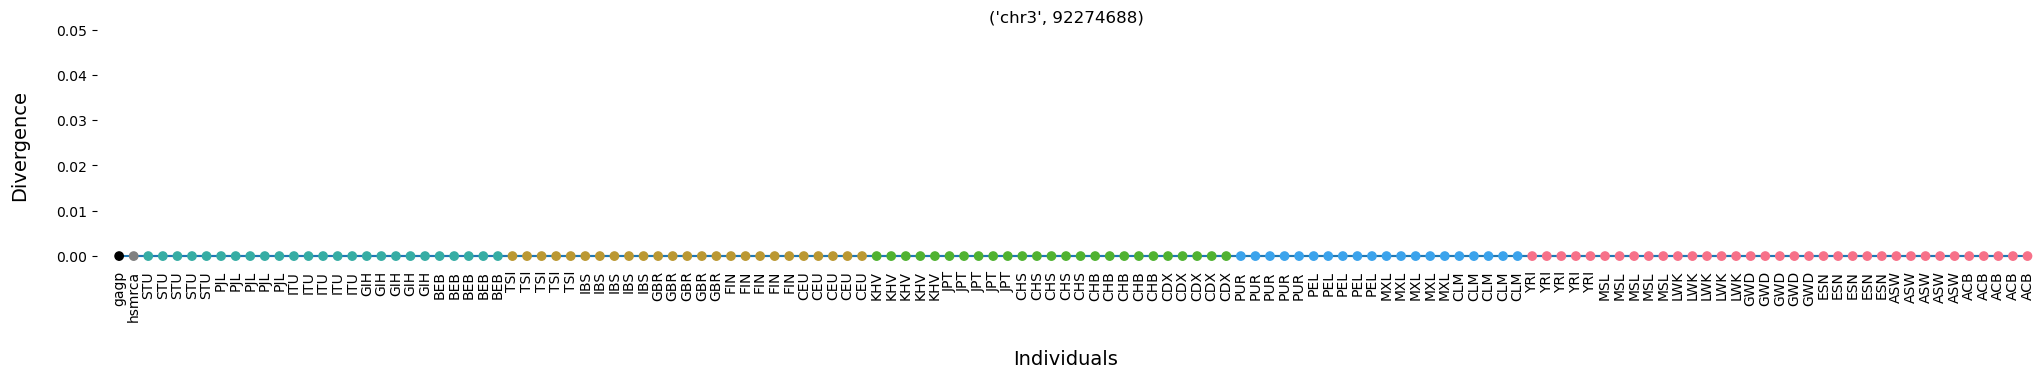

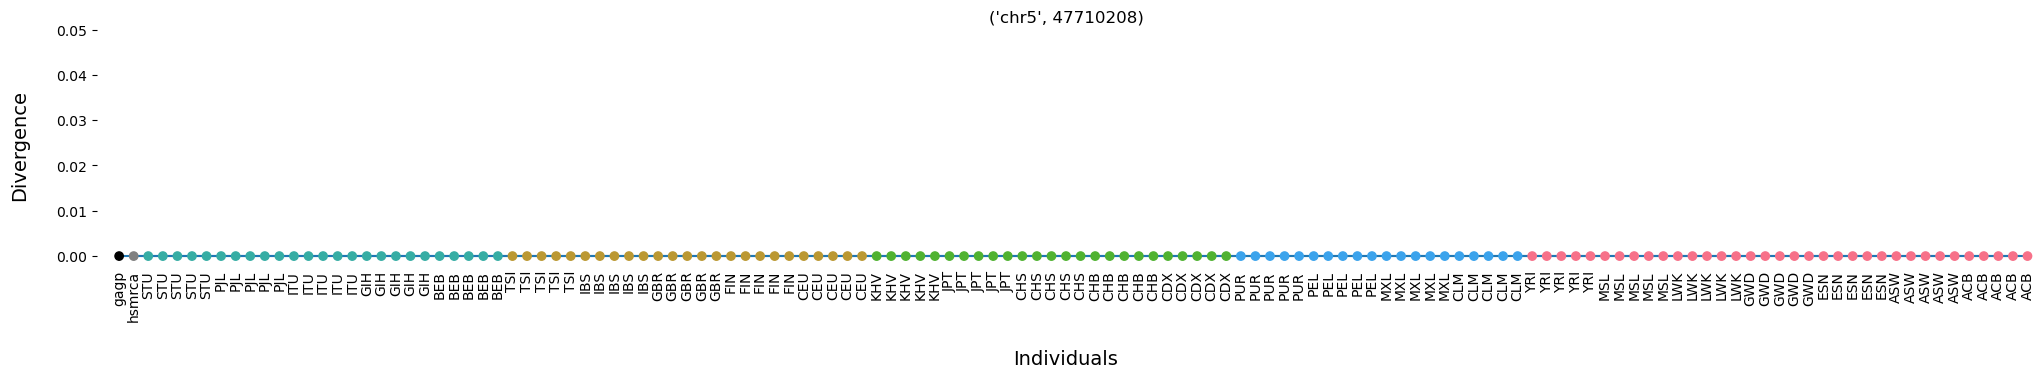

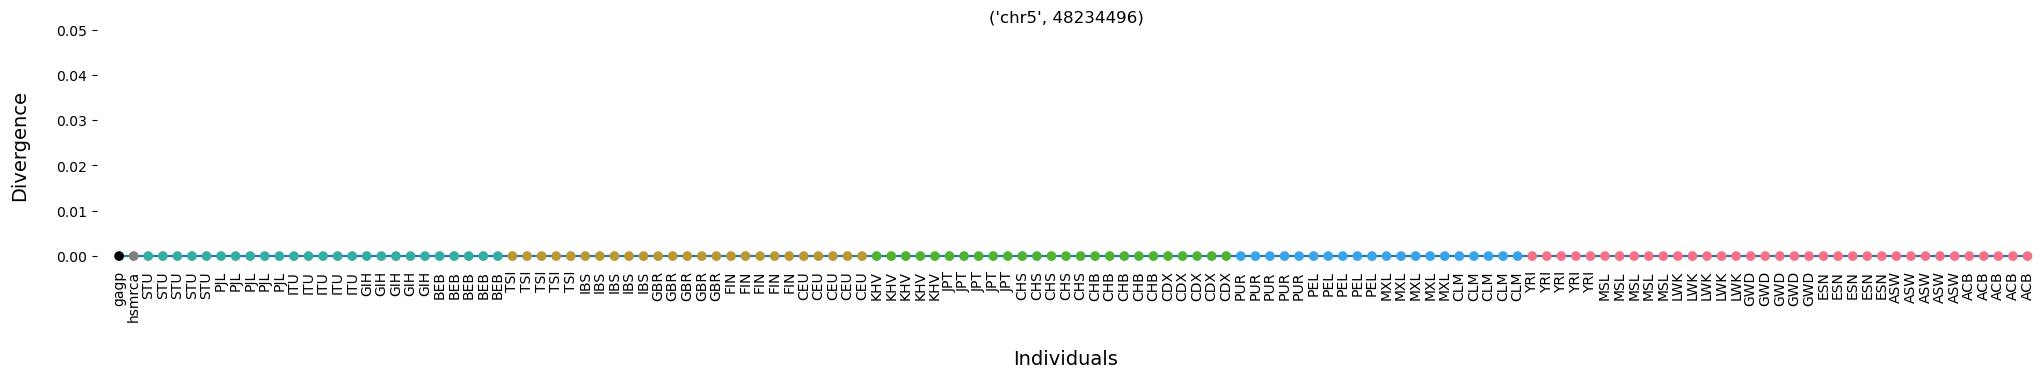

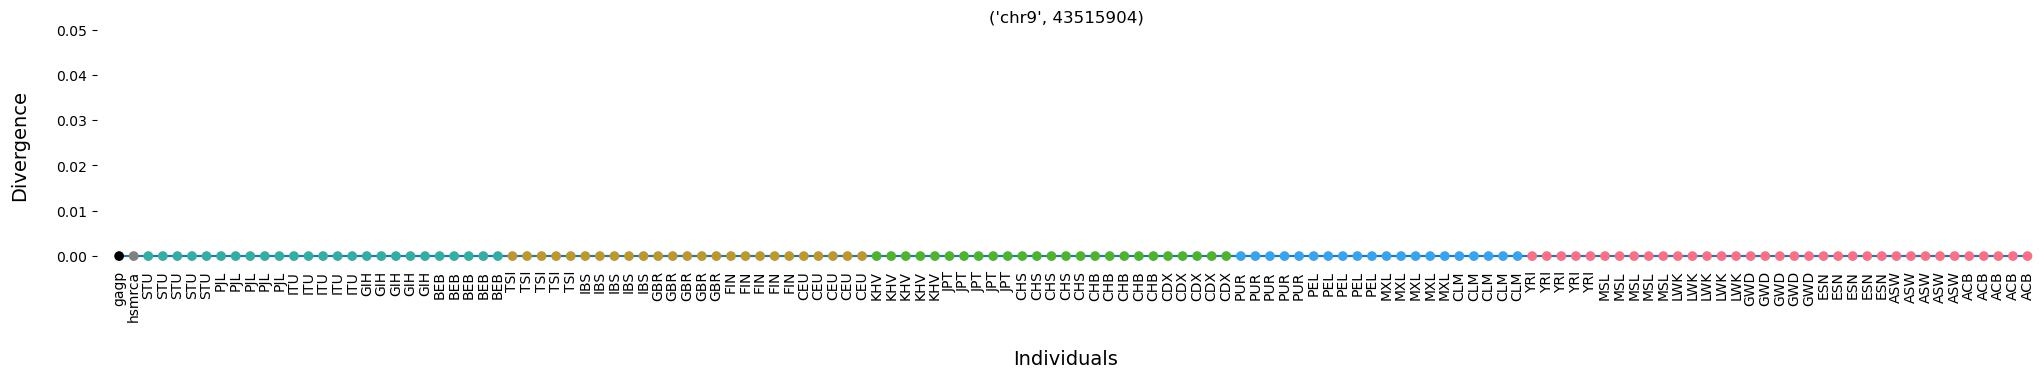

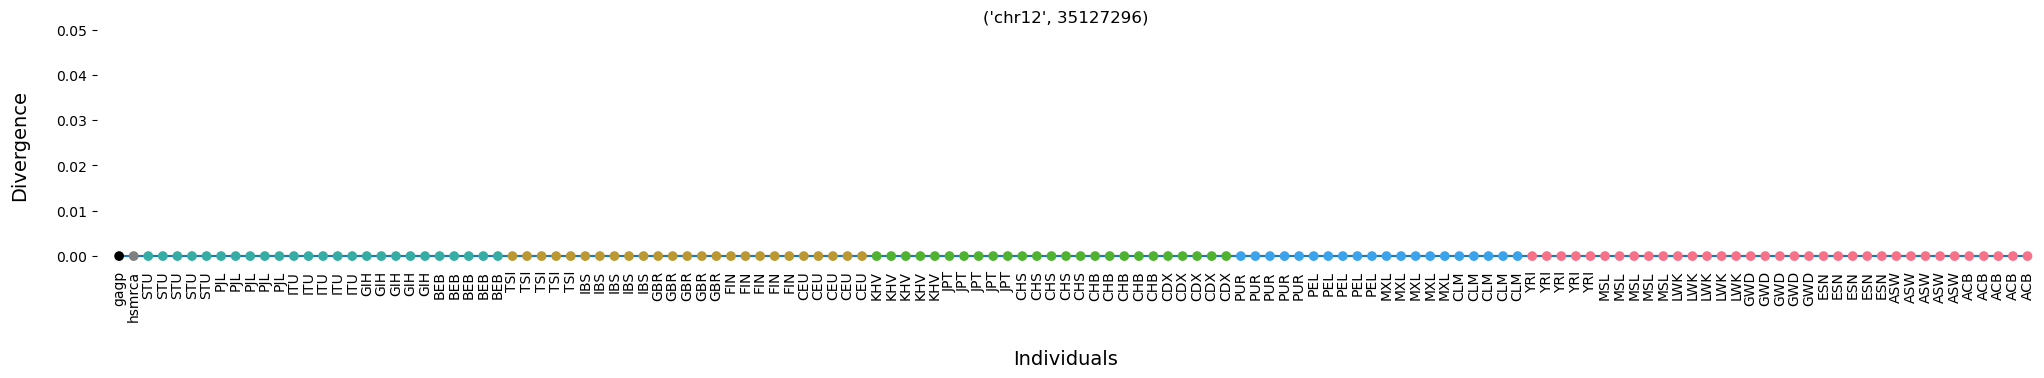

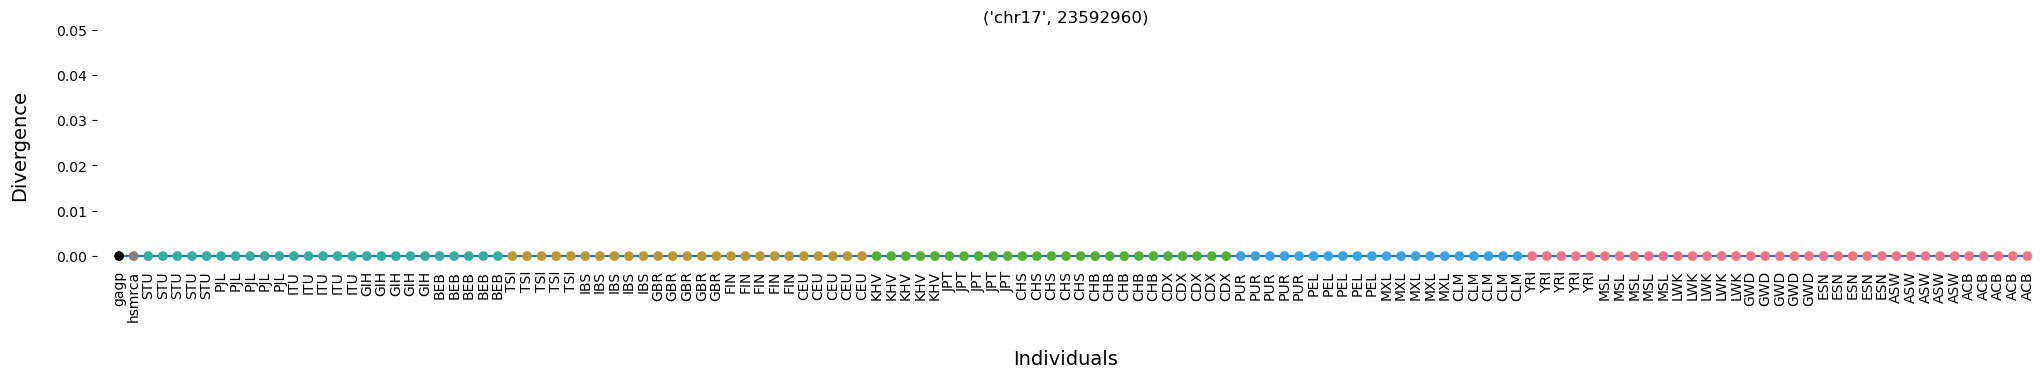

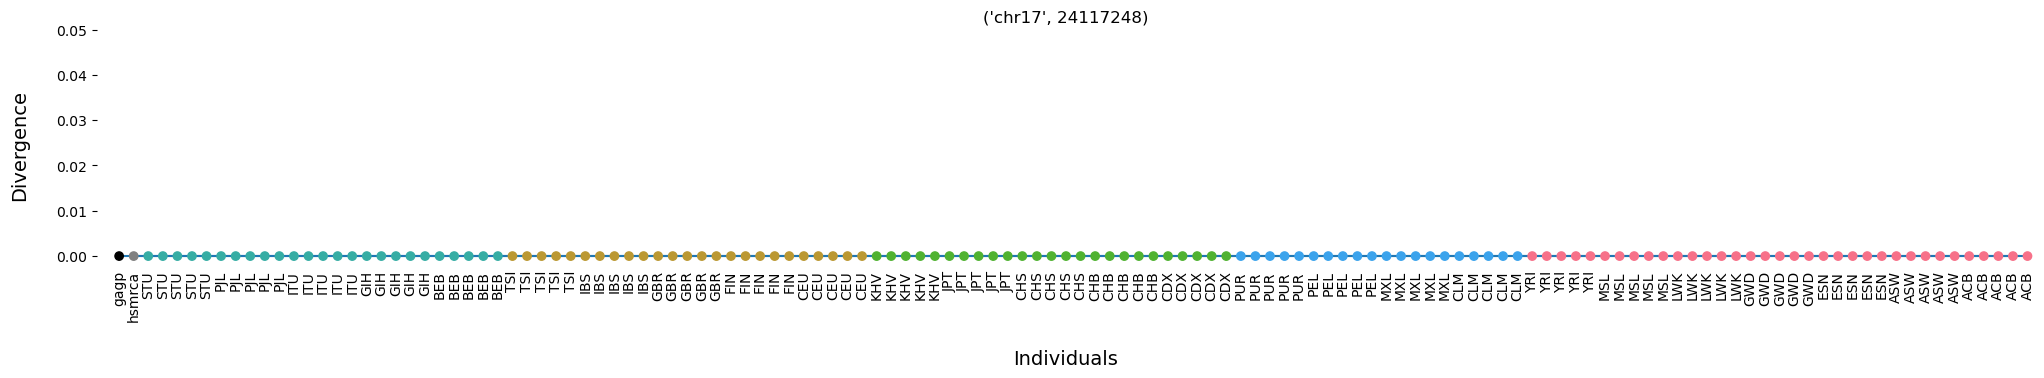

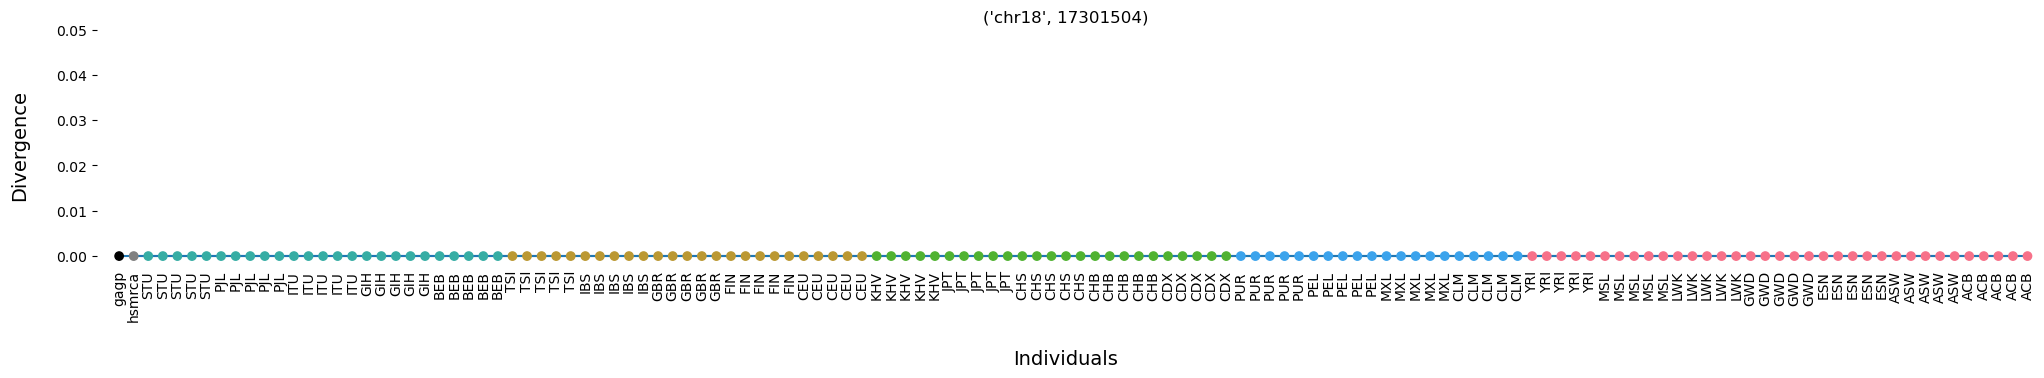

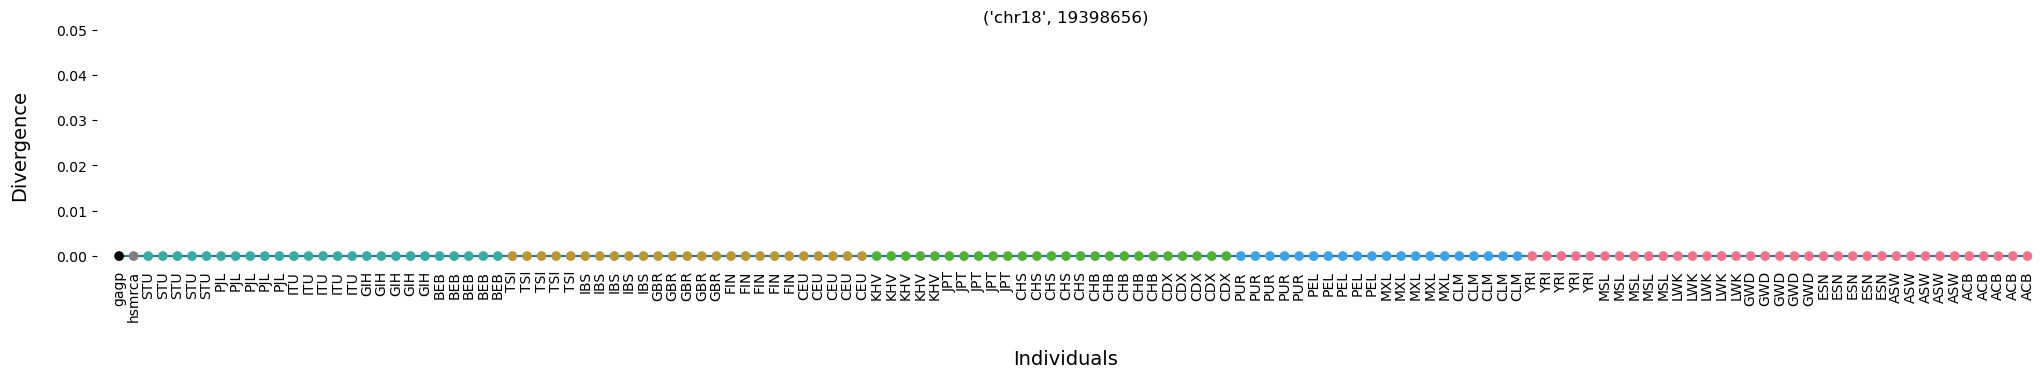

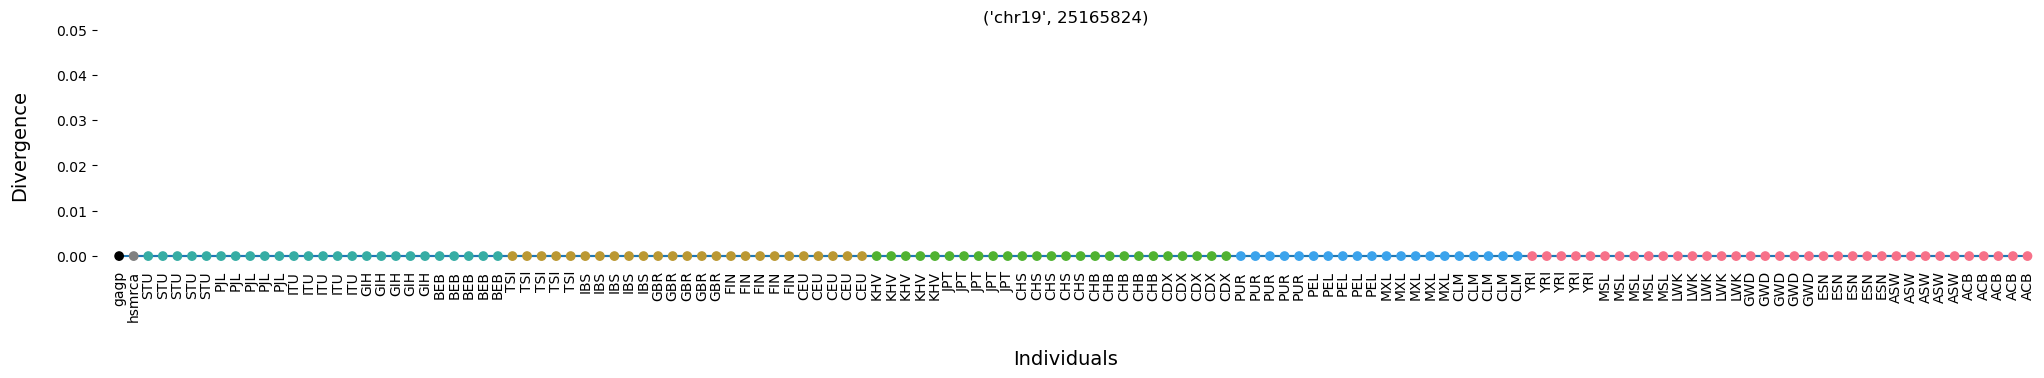

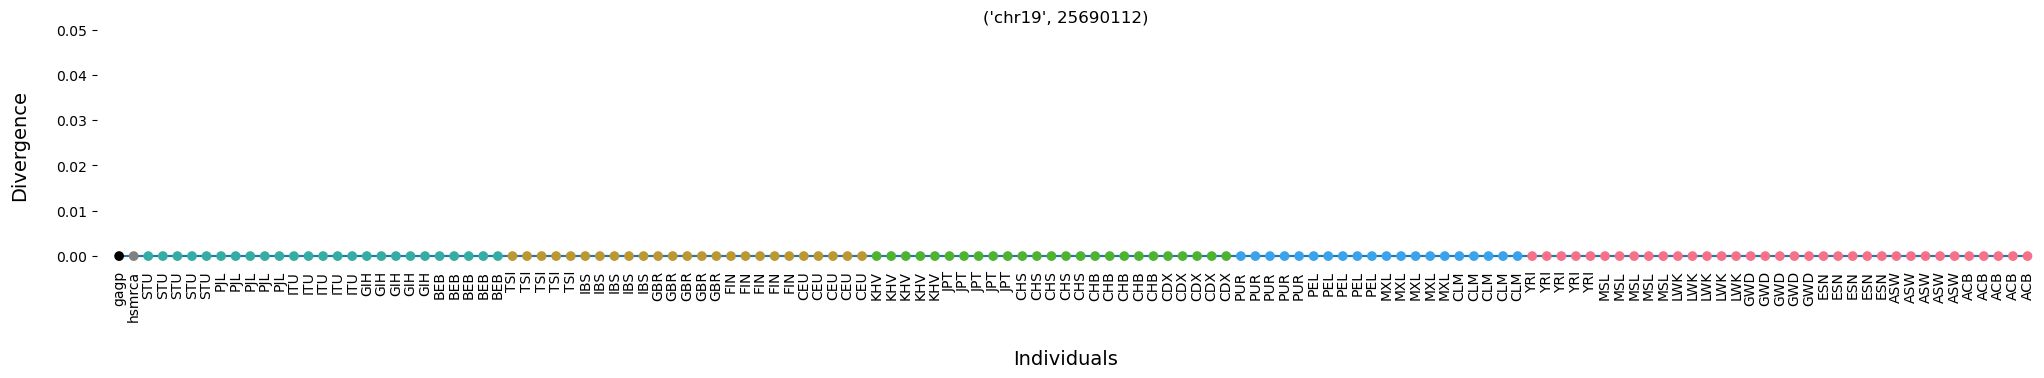

In [61]:
for w in mono[mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [62]:
test.loc[mono[mono.eq(True).any(1)].index]

C0   C1   C2   C3   C4  depth  pure_super  pure_sub  \
(chr1, 122683392)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr1, 123207680)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr1, 123731968)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr3, 92274688)   132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr5, 47710208)   132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr5, 48234496)   132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr9, 43515904)   132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr12, 35127296)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr17, 23592960)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr17, 24117248)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr18, 17301504)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr18, 19398656)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr19, 25165824)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   
(chr19, 25690112)  132.0  0.0  0.0  0.0  0.0    0.0       False     False   

                  super  sub  cluster_size  num_clusters  
(chr1, 122683392)   NaN  NaN           132             1  
(chr1, 123207680)   NaN  NaN           132             1  
(chr1, 123731968)   NaN  NaN           132             1  
(chr3, 92274688)    NaN  NaN           132             1  
(chr5, 47710208)    NaN  NaN           132             1  
(chr5, 48234496)    NaN  NaN           132             1  
(chr9, 43515904)    NaN  NaN           132             1  
(chr12, 35127296)   NaN  NaN           132             1  
(chr17, 23592960)   NaN  NaN           132             1  
(chr17, 24117248)   NaN  NaN           132             1  
(chr18, 17301504)   NaN  NaN           132             1  
(chr18, 19398656)   NaN  NaN           132             1  
(chr19, 25165824)   NaN  NaN           132             1  
(chr19, 25690112)   NaN  NaN           132             1

In [63]:
sub_pops = {key: [] for key in sub_idx}
for i in idx:
    if (i != 'hsmrca') & (i!='gagp'):
        pop = i[4:7]
    else:
        pop = i
    sub_pops[pop].append(i)

In [64]:
sub_mono = pd.DataFrame(index = windows_tuples, columns = sub_pops.keys())
count = 0
for w in tree_complete.keys():
    if count%100 == 0:
        print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in sub_pops.keys():
        status = T.check_monophyly(values=sub_pops[p], target_attr="name")[0]
        sub_mono.at[w,p] = status
    count += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


In [65]:
sub_mono[sub_mono.eq(True).any(1)]

ACB    ASW    ESN    GWD    LWK    MSL    YRI    CLM  \
(chr1, 122683392)   True  False  False  False  False  False  False  False   
(chr1, 123207680)   True  False  False  False  False  False  False  False   
(chr1, 123731968)   True  False  False  False  False  False  False  False   
(chr3, 92274688)    True  False  False  False  False  False  False  False   
(chr5, 47710208)    True  False  False  False  False  False  False  False   
(chr5, 48234496)    True  False  False  False  False  False  False  False   
(chr9, 43515904)    True  False  False  False  False  False  False  False   
(chr12, 35127296)   True  False  False  False  False  False  False  False   
(chr17, 23592960)   True  False  False  False  False  False  False  False   
(chr17, 24117248)   True  False  False  False  False  False  False  False   
(chr18, 17301504)   True  False  False  False  False  False  False  False   
(chr18, 19398656)   True  False  False  False  False  False  False  False   
(chr19, 25165824)   True  False  False  False  False  False  False  False   
(chr19, 25690112)   True  False  False  False  False  False  False  False   
(chr21, 44564480)  False  False  False  False  False  False  False  False   

                     MXL    PEL  ...    GBR    IBS    TSI    BEB    GIH  \
(chr1, 122683392)  False  False  ...  False  False  False  False  False   
(chr1, 123207680)  False  False  ...  False  False  False  False  False   
(chr1, 123731968)  False  False  ...  False  False  False  False  False   
(chr3, 92274688)   False  False  ...  False  False  False  False  False   
(chr5, 47710208)   False  False  ...  False  False  False  False  False   
(chr5, 48234496)   False  False  ...  False  False  False  False  False   
(chr9, 43515904)   False  False  ...  False  False  False  False  False   
(chr12, 35127296)  False  False  ...  False  False  False  False  False   
(chr17, 23592960)  False  False  ...  False  False  False  False  False   
(chr17, 24117248)  False  False  ...  False  False  False  False  False   
(chr18, 17301504)  False  False  ...  False  False  False  False  False   
(chr18, 19398656)  False  False  ...  False  False  False  False  False   
(chr19, 25165824)  False  False  ...  False  False  False  False  False   
(chr19, 25690112)  False  False  ...  False  False  False  False  False   
(chr21, 44564480)  False   True  ...  False  False  False  False  False   

                     ITU    PJL    STU hsmrca   gagp  
(chr1, 122683392)  False  False  False  False  False  
(chr1, 123207680)  False  False  False  False  False  
(chr1, 123731968)  False  False  False  False  False  
(chr3, 92274688)   False  False  False  False  False  
(chr5, 47710208)   False  False  False  False  False  
(chr5, 48234496)   False  False  False  False  False  
(chr9, 43515904)   False  False  False  False  False  
(chr12, 35127296)  False  False  False  False  False  
(chr17, 23592960)  False  False  False  False  False  
(chr17, 24117248)  False  False  False  False  False  
(chr18, 17301504)  False  False  False  False  False  
(chr18, 19398656)  False  False  False  False  False  
(chr19, 25165824)  False  False  False  False  False  
(chr19, 25690112)  False  False  False  False  False  
(chr21, 44564480)  False  False  False  False  False  

[15 rows x 28 columns]

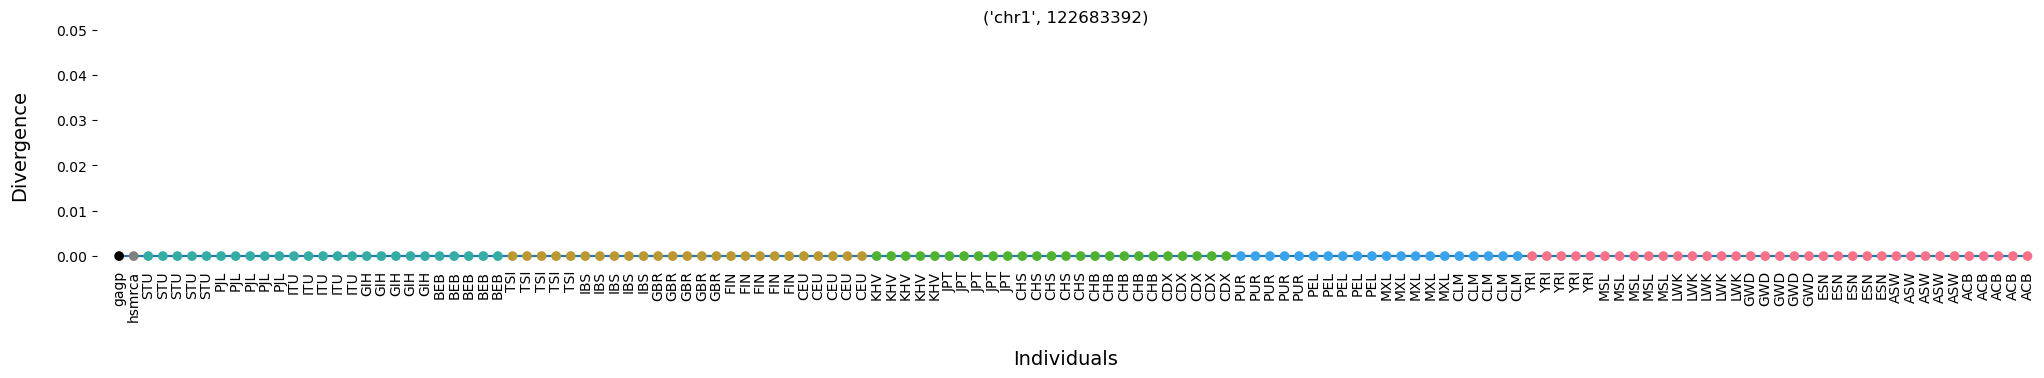

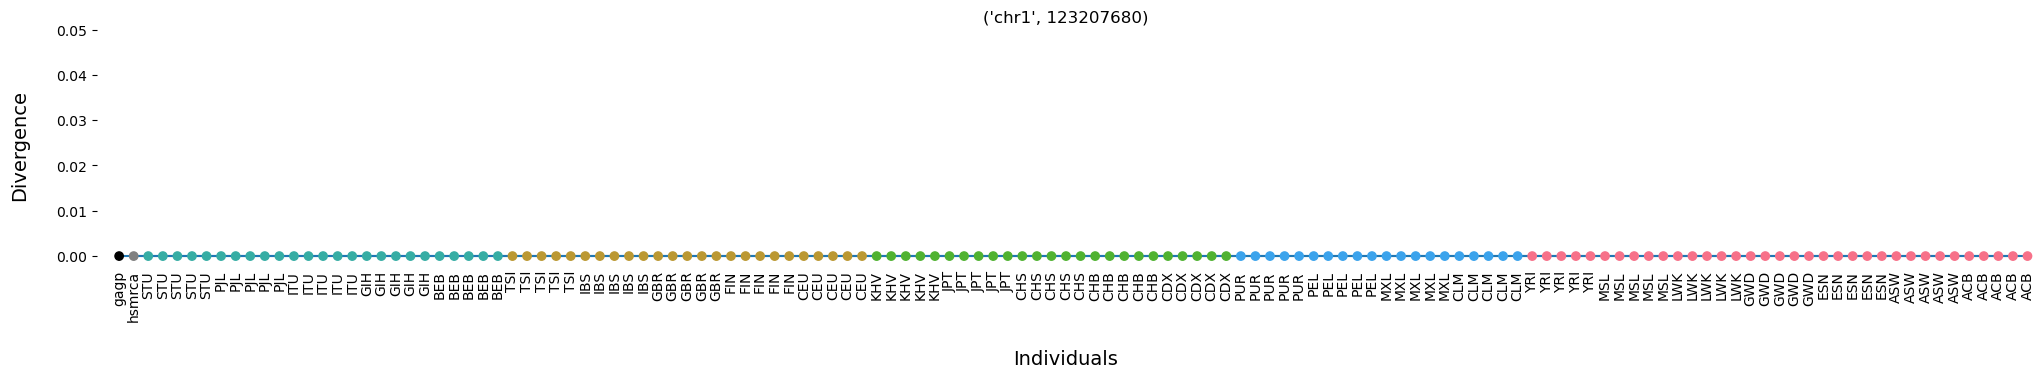

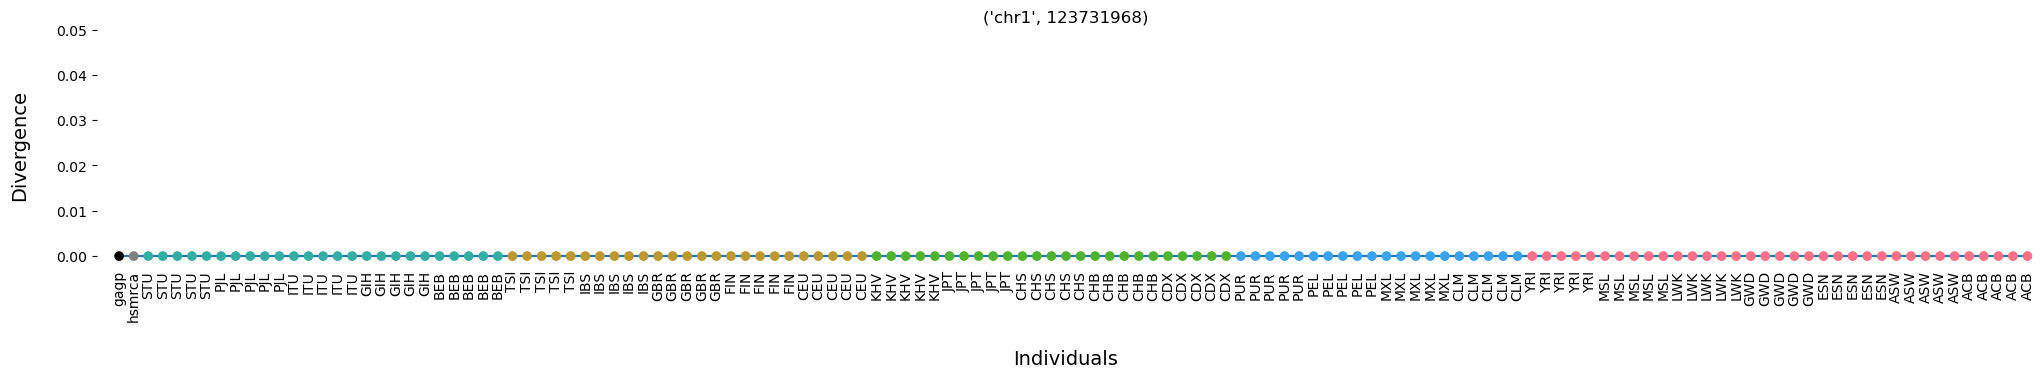

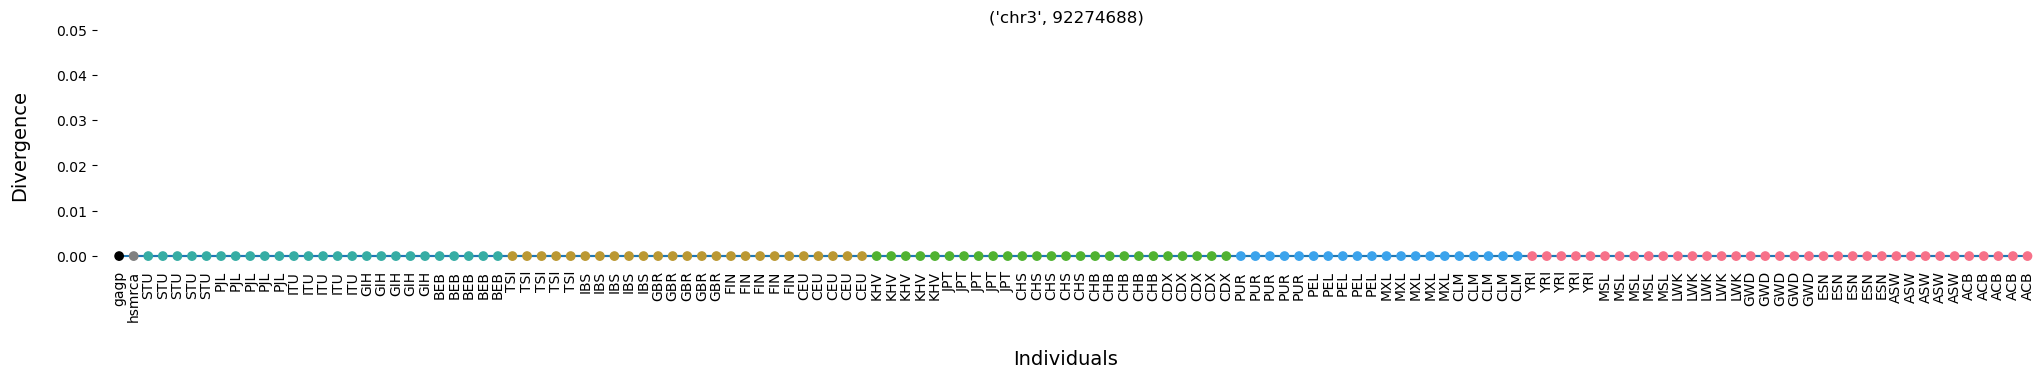

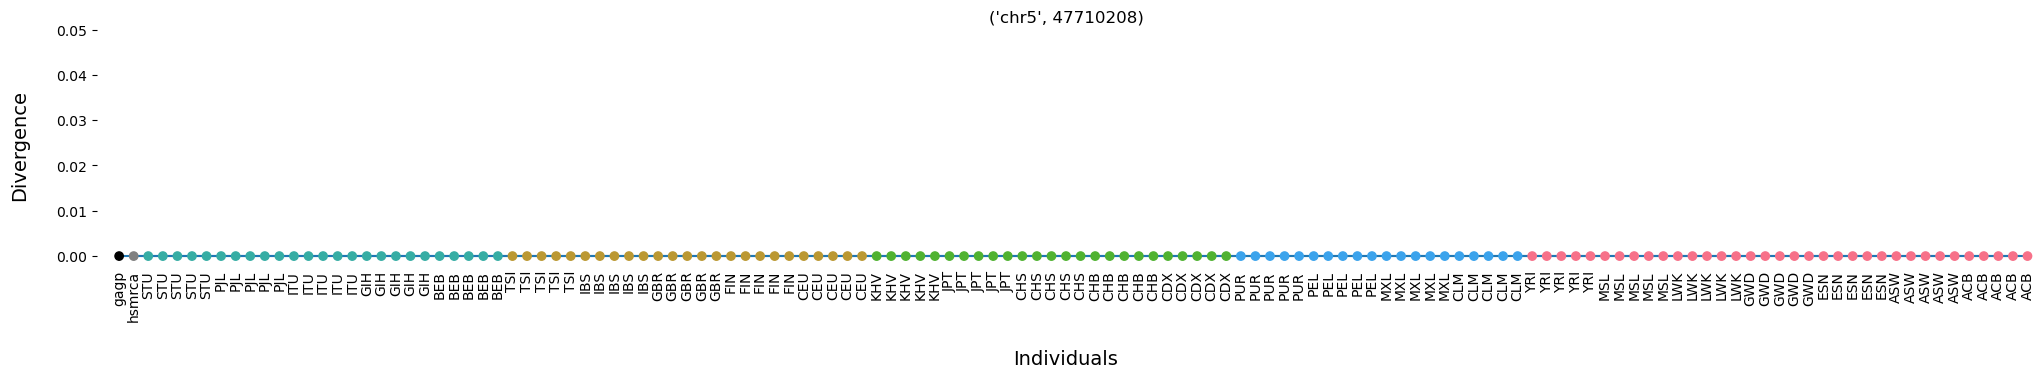

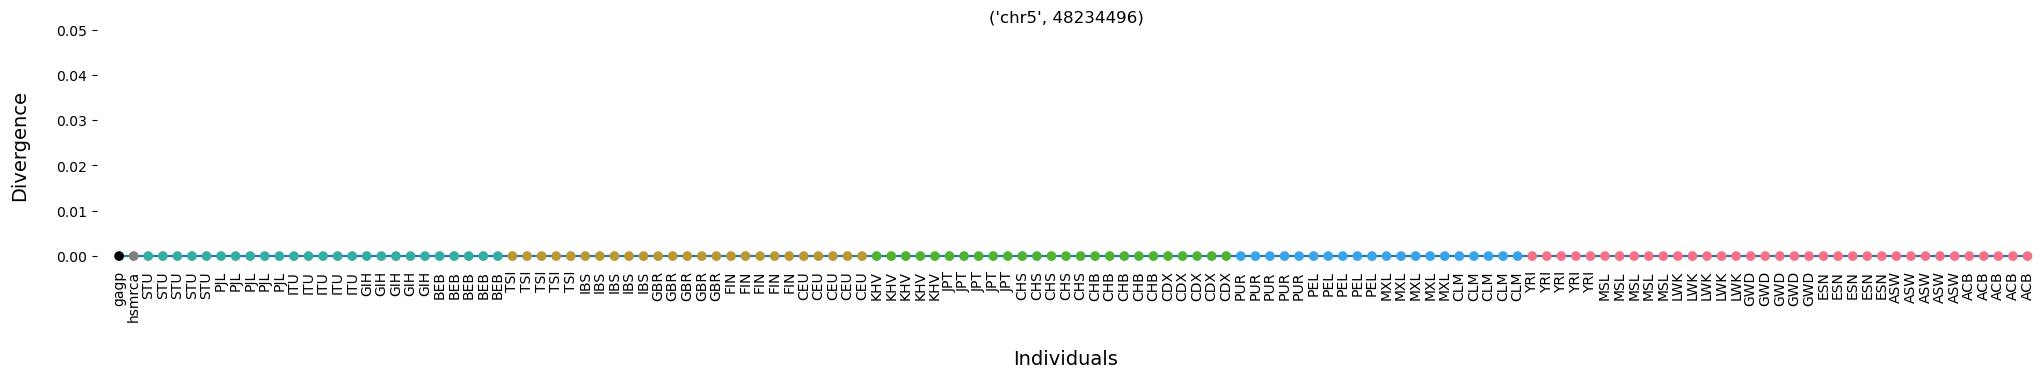

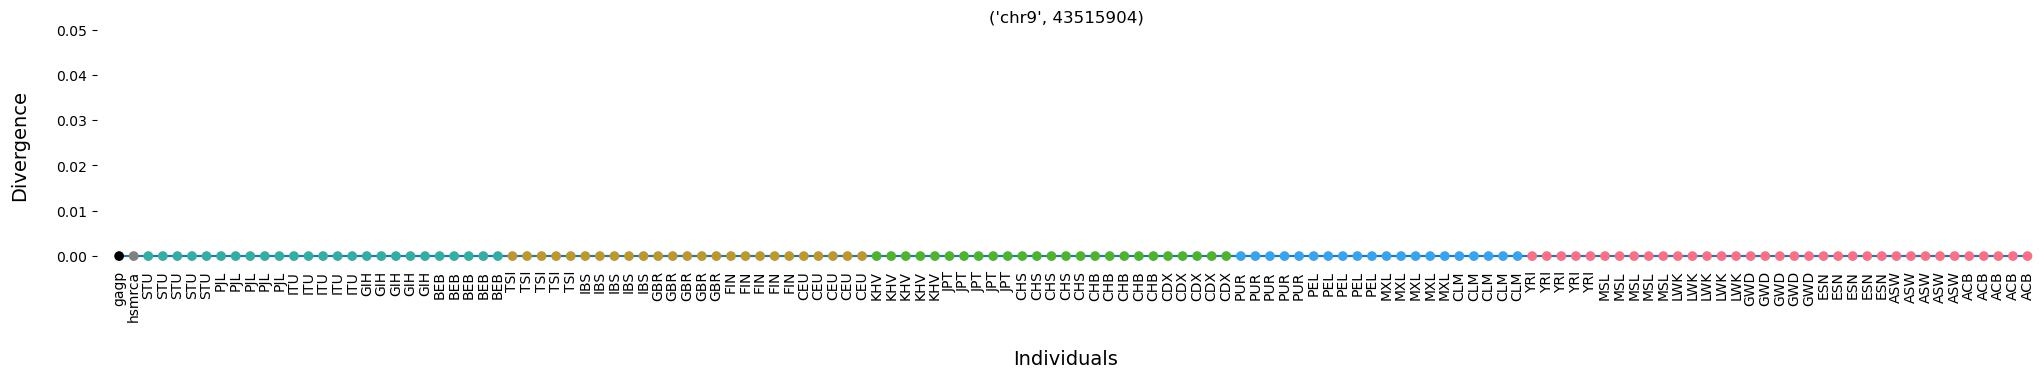

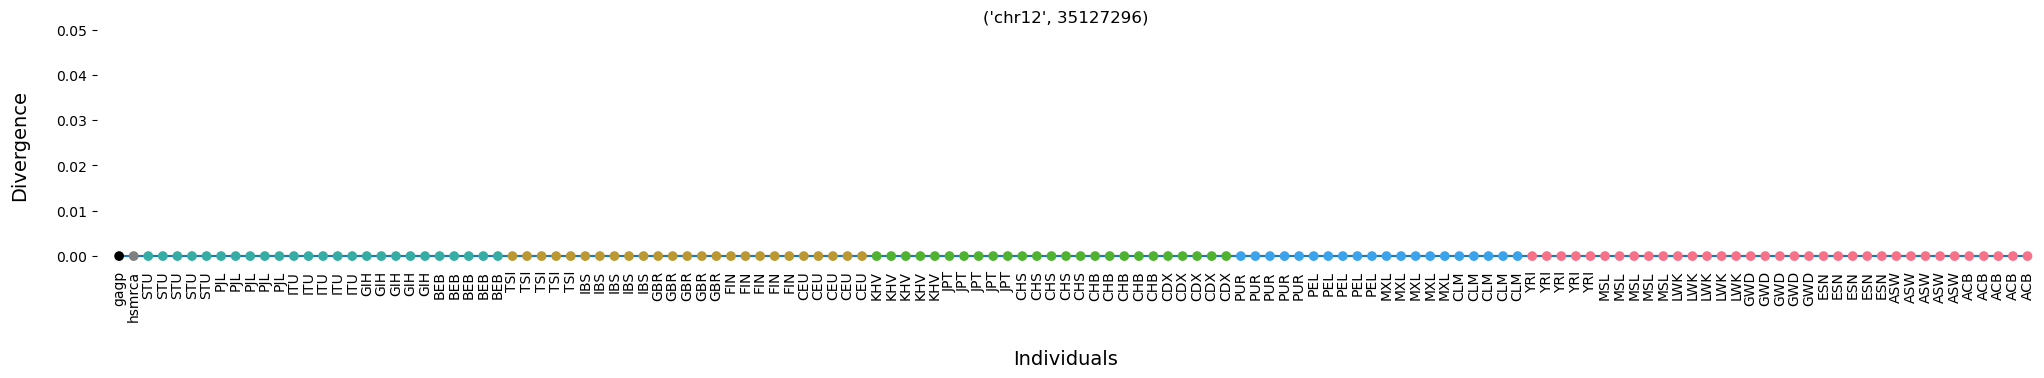

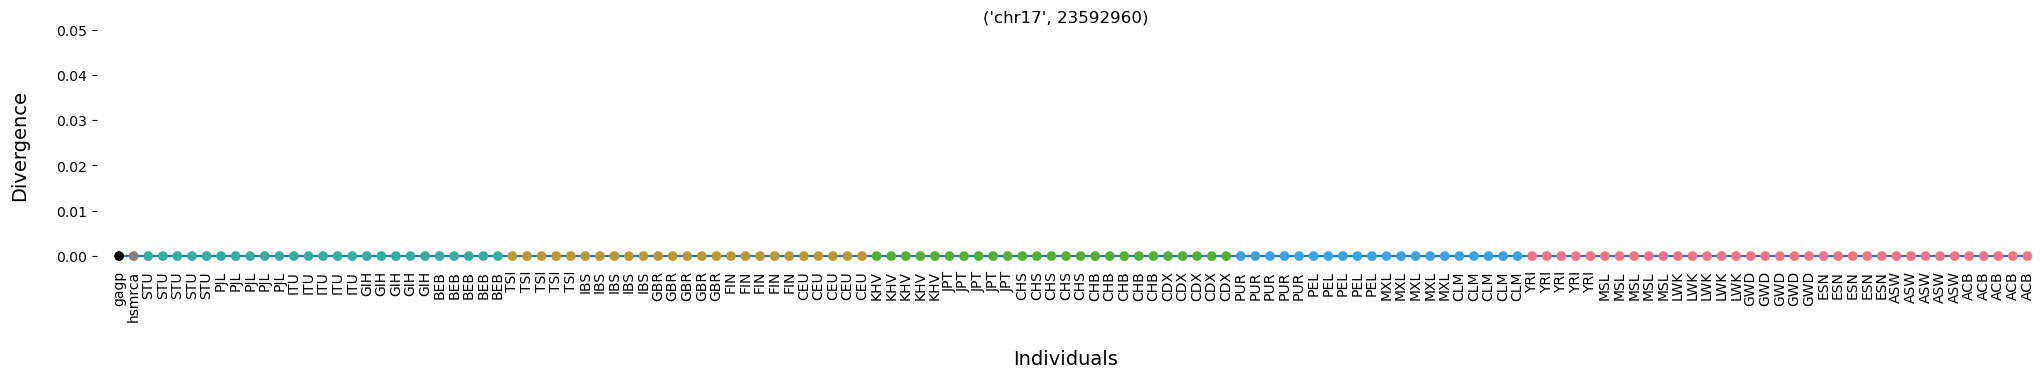

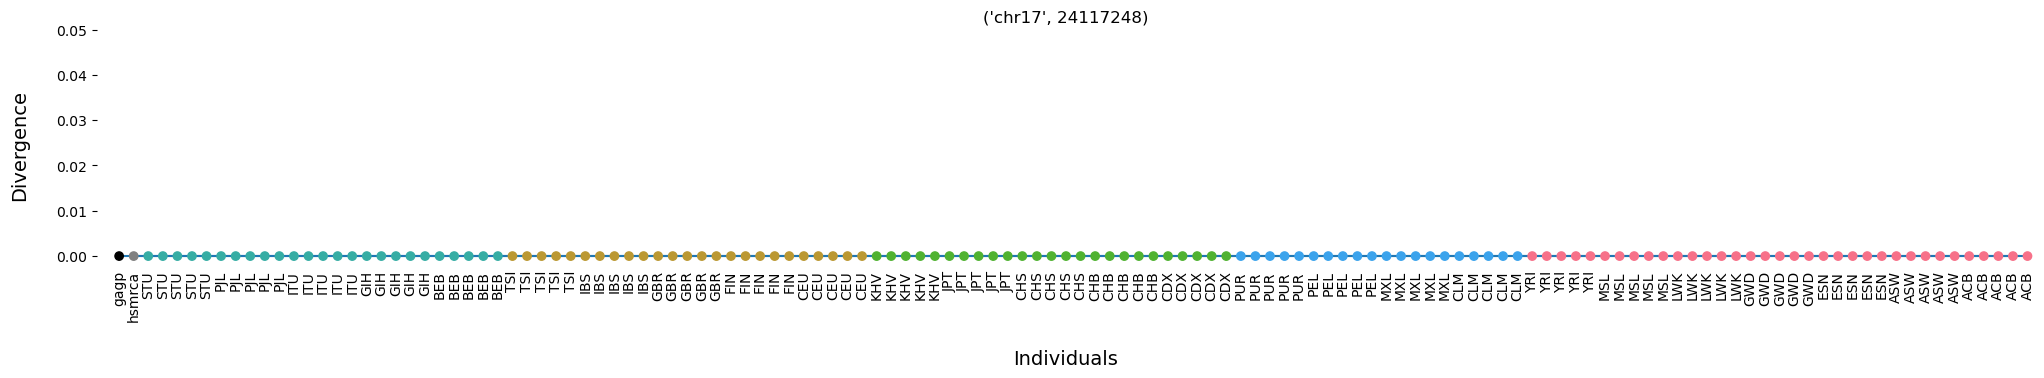

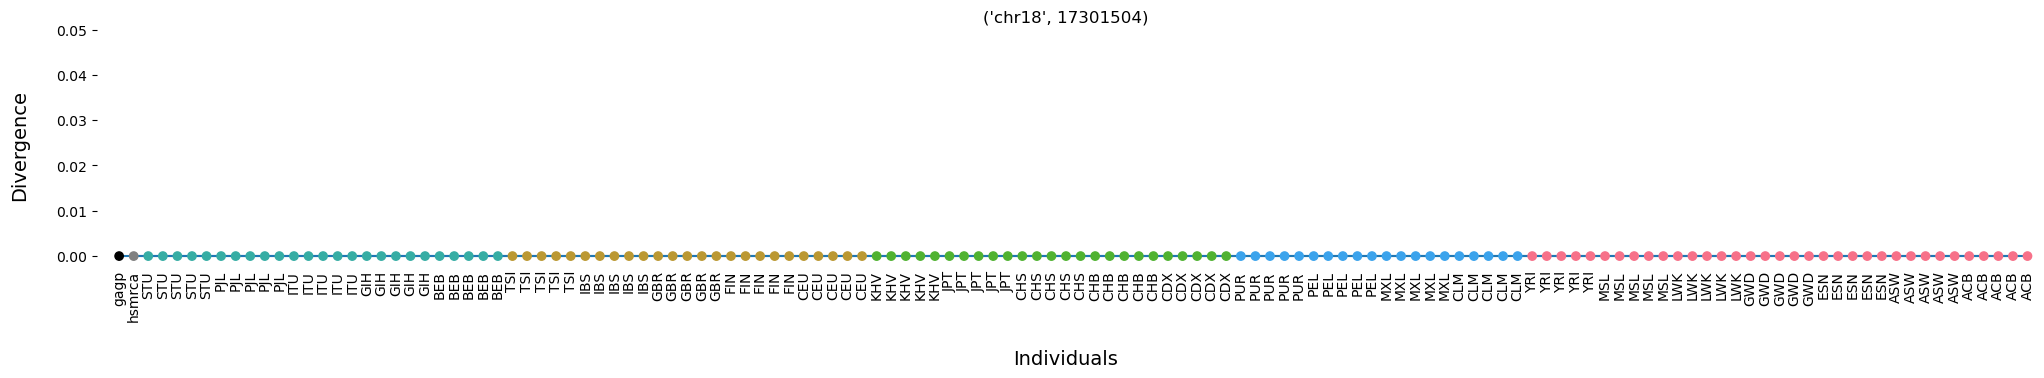

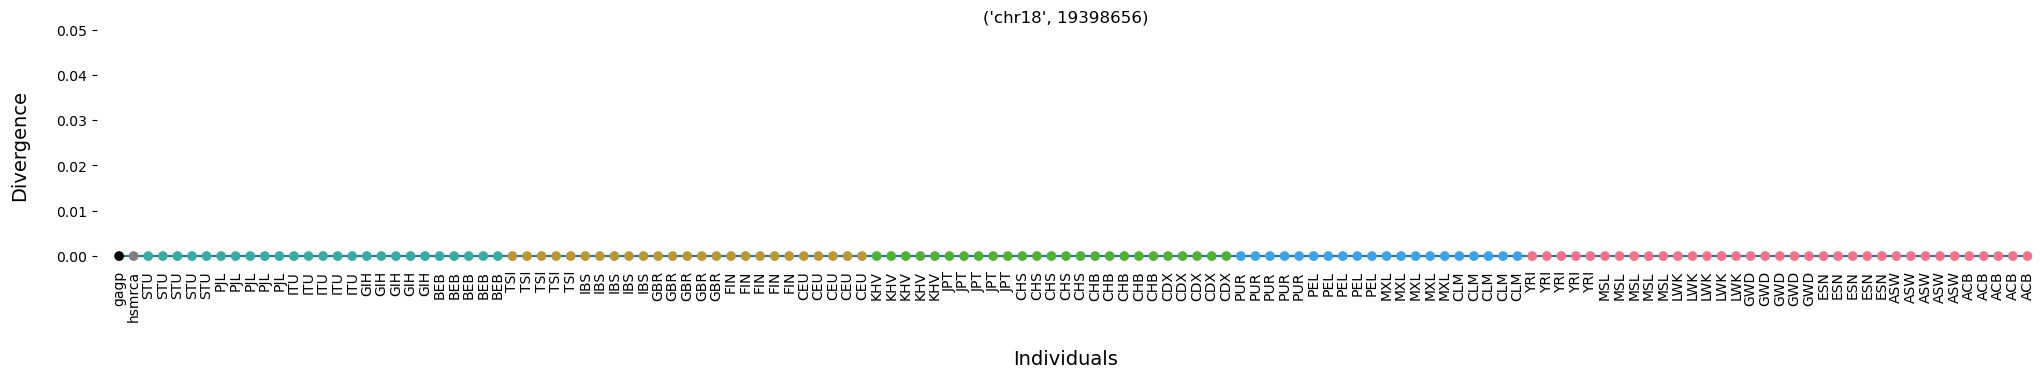

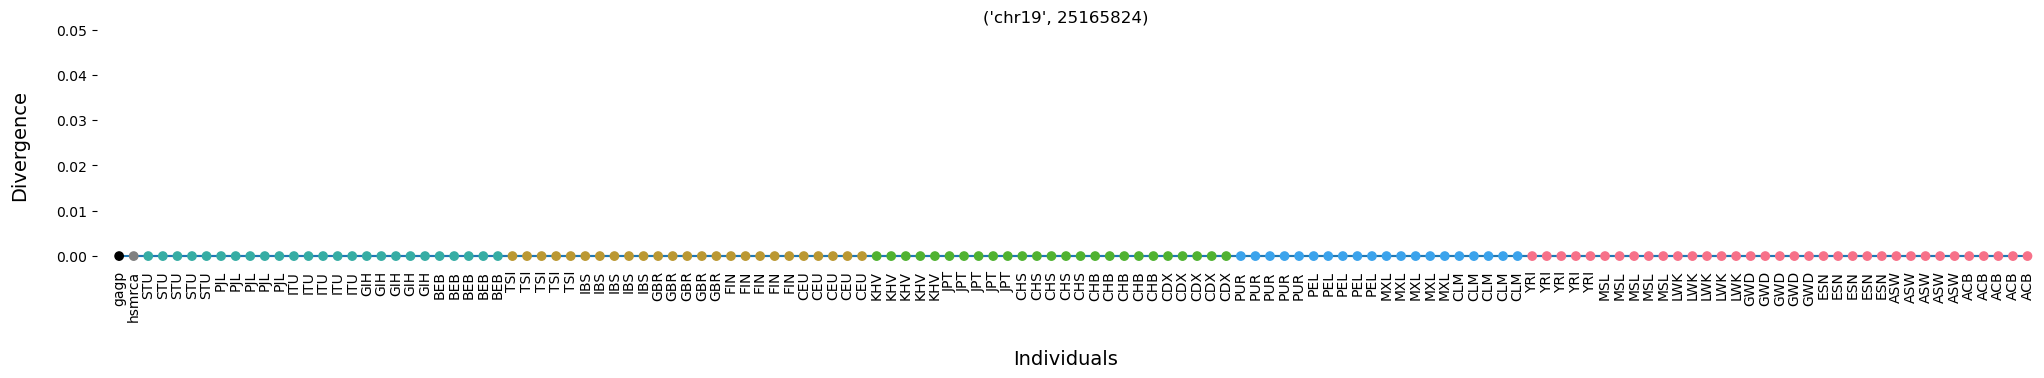

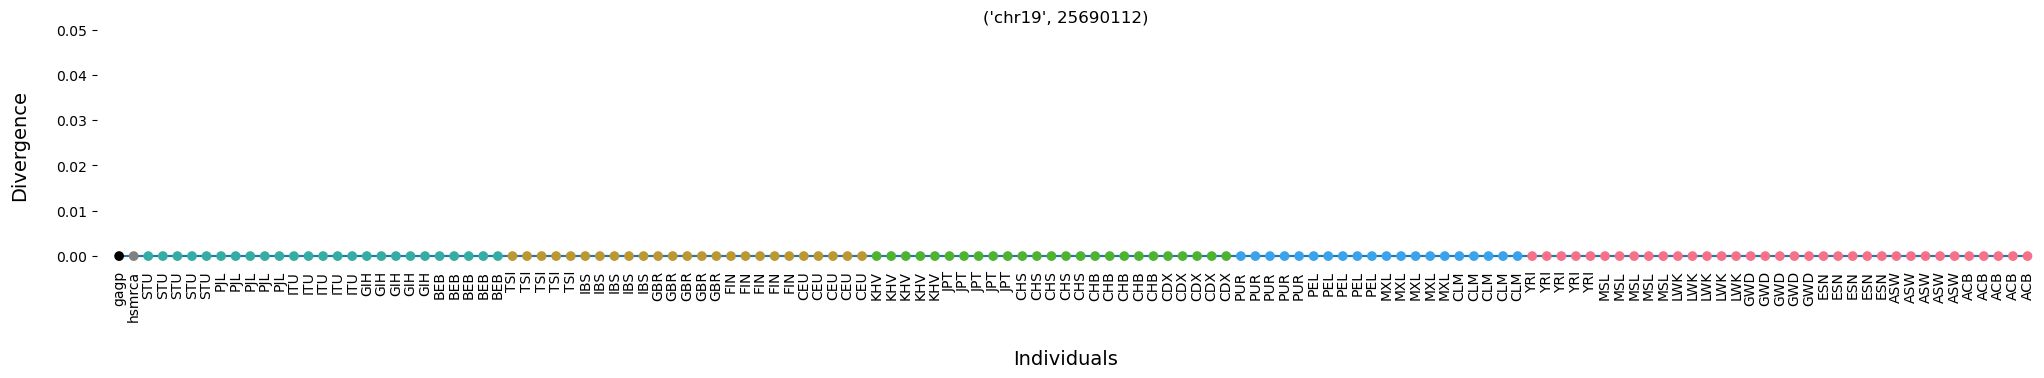

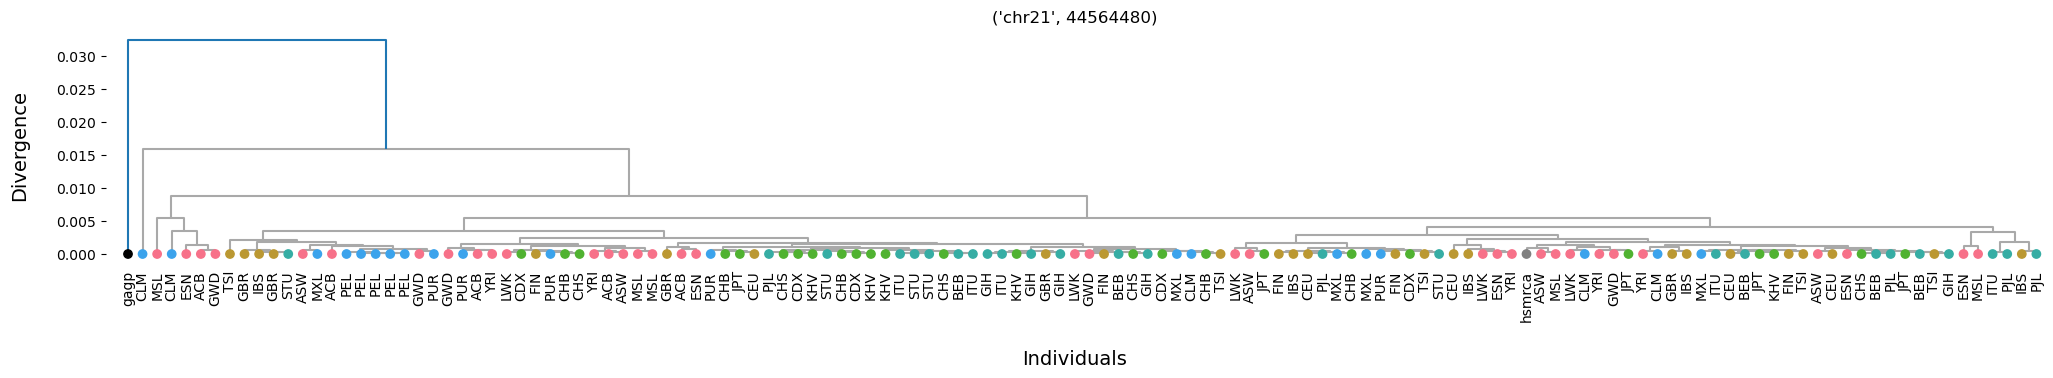

In [66]:
for w in sub_mono[sub_mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [67]:
trees['avg']

Tree node '' (0x7fcd5fec7dc)

### compare trees

In [68]:
w = ('chr1', 1048576)

In [69]:
trees['avg'].compare(trees[w]).keys()

dict_keys(['rf', 'max_rf', 'ref_edges_in_source', 'source_edges_in_ref', 'effective_tree_size', 'norm_rf', 'treeko_dist', 'source_subtrees', 'common_edges', 'source_edges', 'ref_edges'])

In [70]:
tree_comp_stats = pd.DataFrame(columns=['rf','max_rf','norm_rf','ref_edges_in_source','source_edges_in_ref'])
for w in trees.keys():
    if w != 'avg':
        print(w)
        comp = trees['avg'].compare(trees[w])
        rf = comp['rf']
        max_rf = comp['max_rf']
        norm = comp['norm_rf']
        rs = comp['ref_edges_in_source']
        sr = comp['source_edges_in_ref']
        
        tmp = pd.Series([rf, max_rf, norm, rs, sr], name=w, index=['rf','max_rf','norm_rf','ref_edges_in_source','source_edges_in_ref'])
        tree_comp_stats = tree_comp_stats.append(tmp)

('chr1', 1048576)
('chr1', 1572864)
('chr1', 3145728)
('chr1', 3670016)
('chr1', 4194304)
('chr1', 4718592)
('chr1', 5242880)
('chr1', 5767168)
('chr1', 6291456)
('chr1', 6815744)
('chr1', 7340032)
('chr1', 7864320)
('chr1', 8388608)
('chr1', 8912896)
('chr1', 9437184)
('chr1', 9961472)
('chr1', 10485760)
('chr1', 11010048)
('chr1', 11534336)
('chr1', 13107200)
('chr1', 13631488)
('chr1', 14155776)
('chr1', 14680064)
('chr1', 15204352)
('chr1', 15728640)
('chr1', 17301504)
('chr1', 17825792)
('chr1', 18350080)
('chr1', 18874368)
('chr1', 19398656)
('chr1', 19922944)
('chr1', 20447232)
('chr1', 20971520)
('chr1', 21495808)
('chr1', 22020096)
('chr1', 22544384)
('chr1', 23068672)
('chr1', 23592960)
('chr1', 24117248)
('chr1', 24641536)
('chr1', 25165824)
('chr1', 25690112)
('chr1', 26214400)
('chr1', 26738688)
('chr1', 27262976)
('chr1', 27787264)
('chr1', 28311552)
('chr1', 29884416)
('chr1', 30408704)
('chr1', 30932992)
('chr1', 31457280)
('chr1', 31981568)
('chr1', 32505856)
('chr1', 

<Axes: >

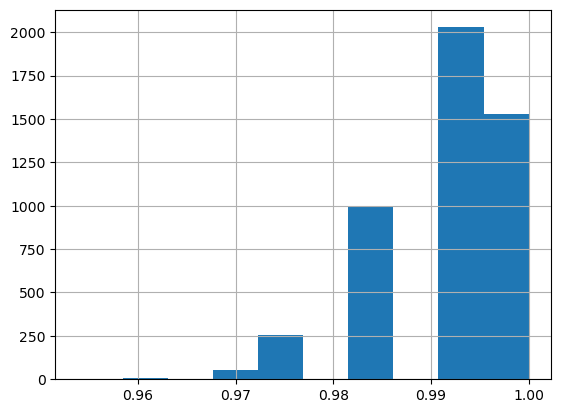

In [71]:
tree_comp_stats.norm_rf.hist()

<Axes: >

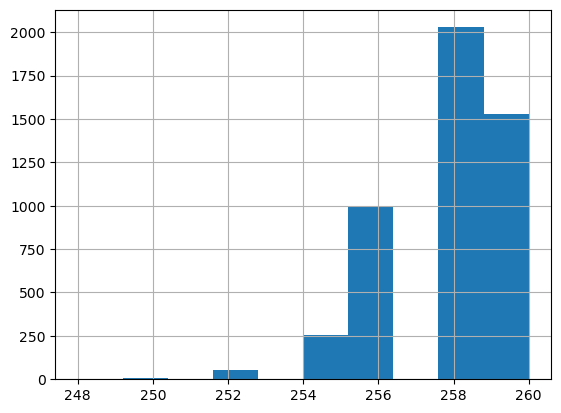

In [72]:
tree_comp_stats.rf.hist()

<Axes: >

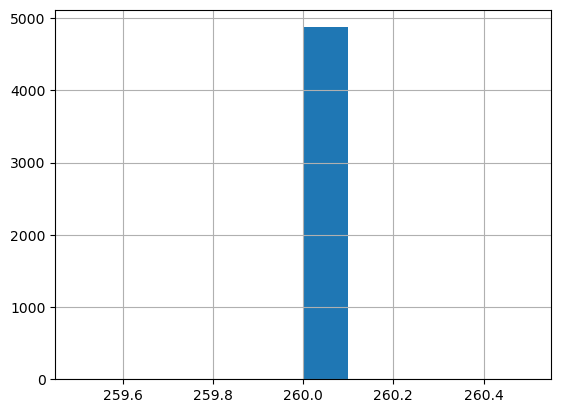

In [73]:
tree_comp_stats.max_rf.hist()

<Axes: >

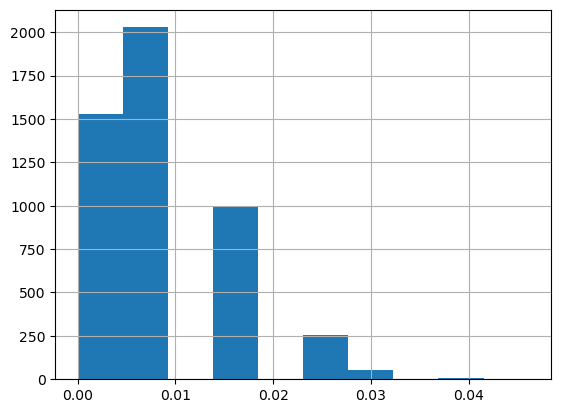

In [74]:
tree_comp_stats.ref_edges_in_source.hist()

<Axes: >

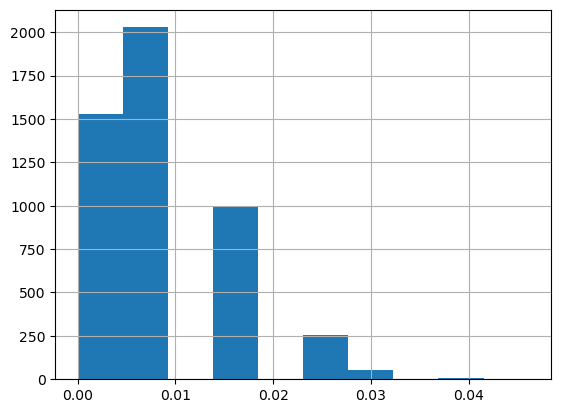

In [75]:
tree_comp_stats.source_edges_in_ref.hist()

In [79]:
tree_comp_stats.sort_values(by=['norm_rf']).head()

rf  max_rf   norm_rf  ref_edges_in_source  \
(chr14, 100139008)  248.0   260.0  0.953846             0.046154   
(chr2, 9437184)     248.0   260.0  0.953846             0.046154   
(chr12, 62914560)   250.0   260.0  0.961538             0.038462   
(chr2, 61865984)    250.0   260.0  0.961538             0.038462   
(chr2, 100139008)   250.0   260.0  0.961538             0.038462   

                    source_edges_in_ref  
(chr14, 100139008)             0.046154  
(chr2, 9437184)                0.046154  
(chr12, 62914560)              0.038462  
(chr2, 61865984)               0.038462  
(chr2, 100139008)              0.038462

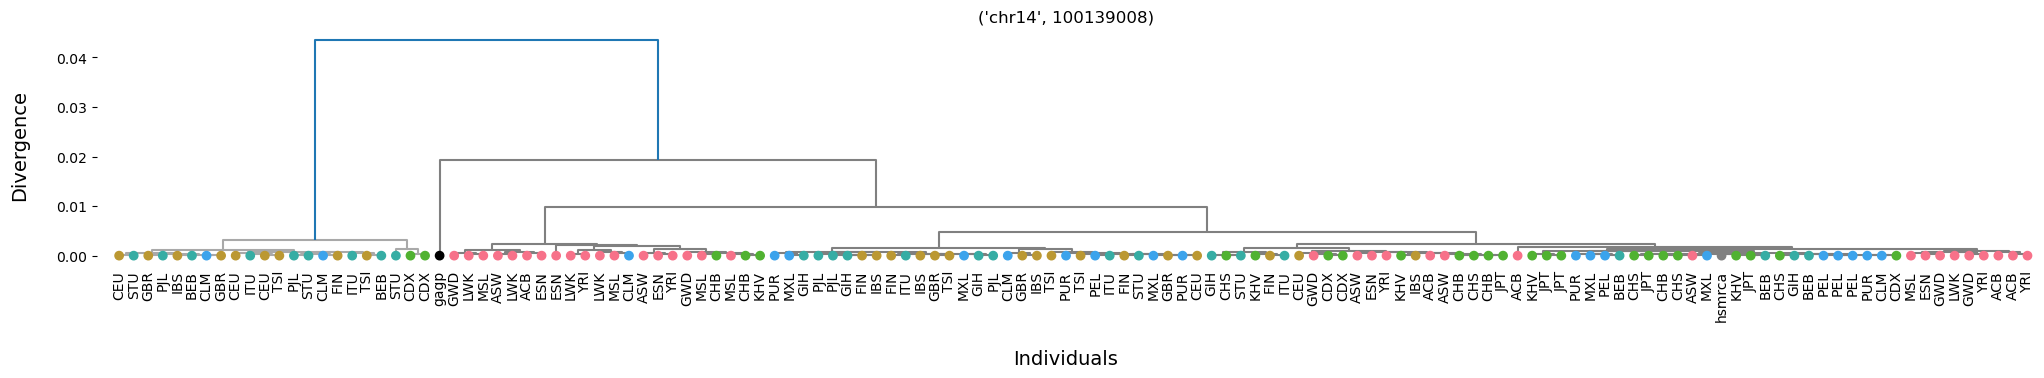

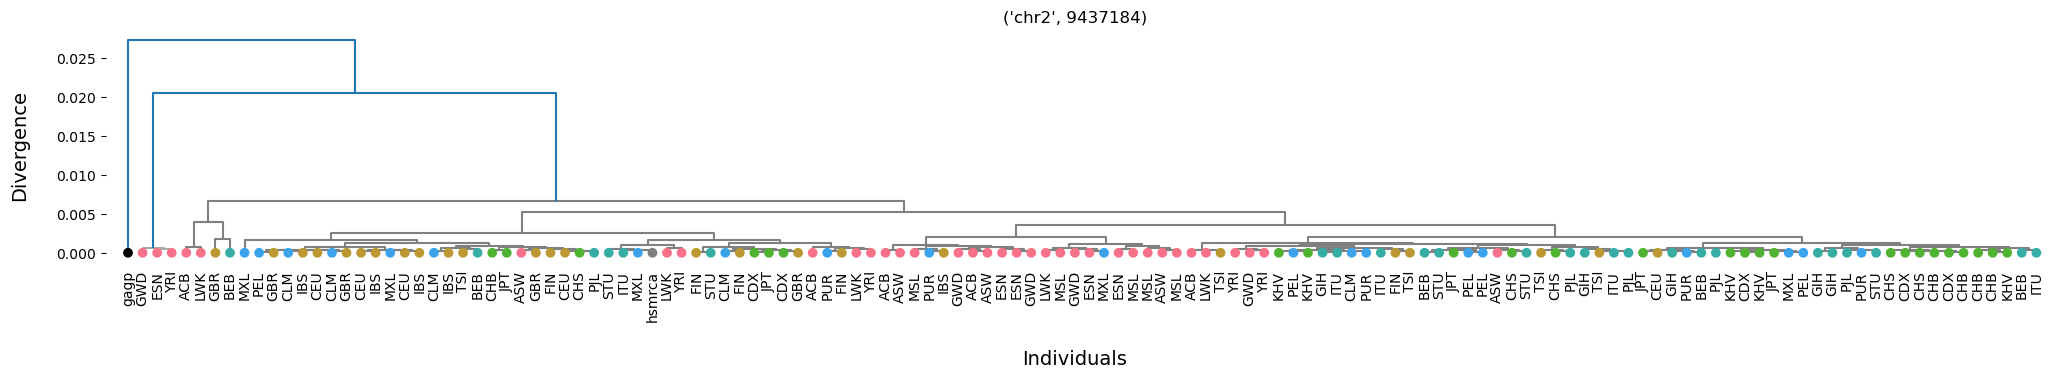

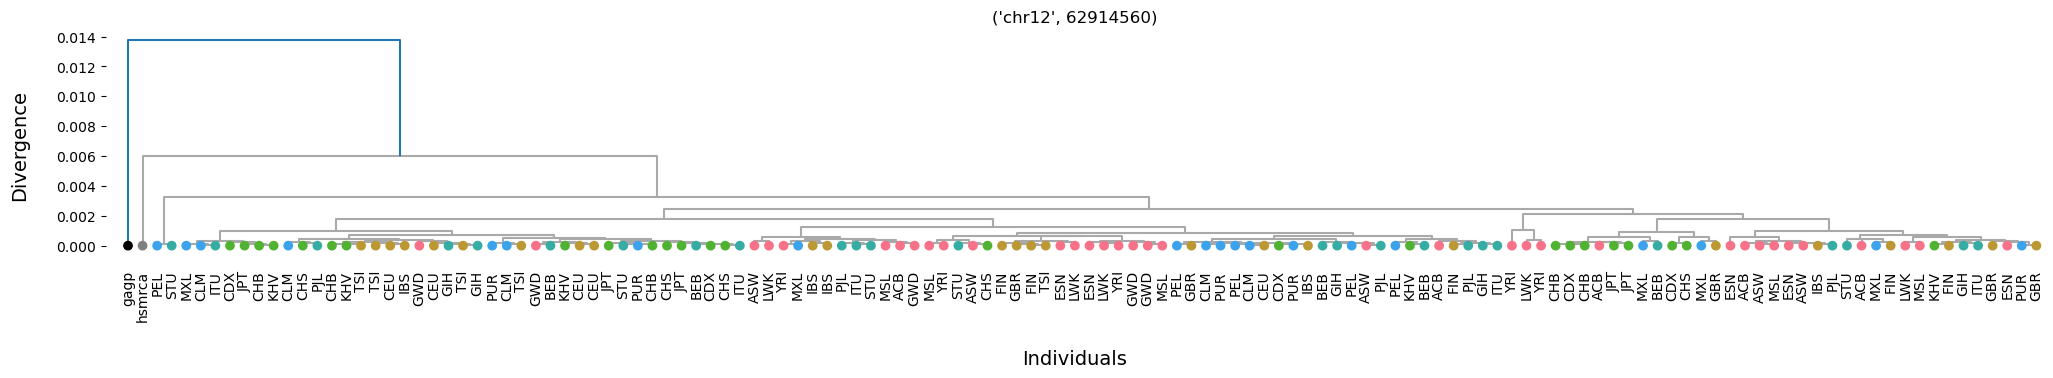

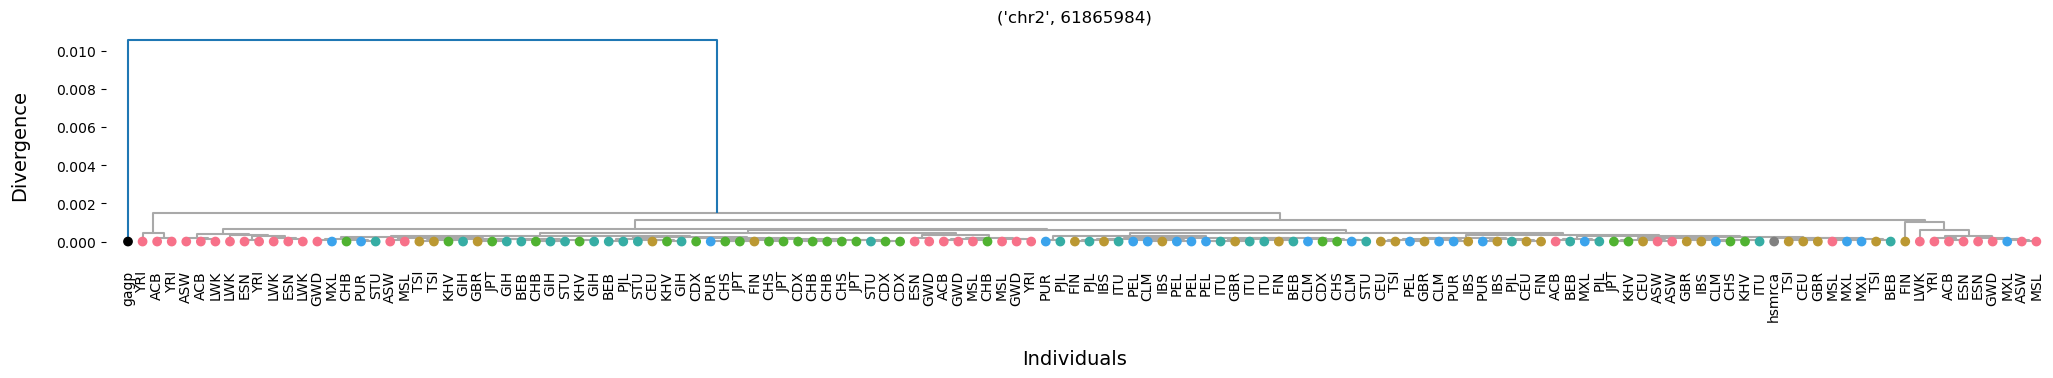

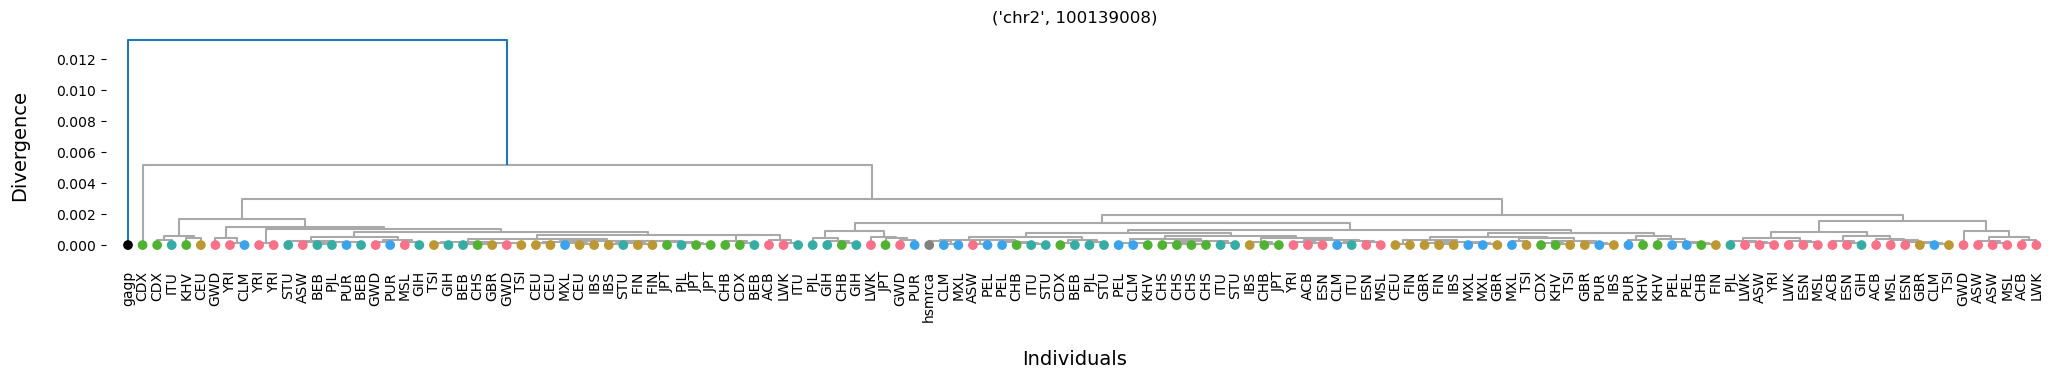

In [80]:
for w in tree_comp_stats.sort_values(by=['norm_rf']).head().index:
    get_window_dendrogram(w,idx)

# Hist for Colin